In [ ]:
!pip install mat73 opencv-python numpy scipy matplotlib statannotations scikit-learn pandas>=2.2 seaborn plotly umap-learn hdbscan torch torchvision tqdm scprep
!pip install --upgrade pip

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [3]:
# import libraries
import os
os.environ["SCIPY_ARRAY_API"] = "1" 
import sys
sys.path.append("../")
from natsort import natsorted
from tifffile import imread
import pandas as pd 
from skimage import measure
import numpy as np
import matplotlib.pyplot as plt
import mat73
import cv2 as cv
import imageio
import math as mt
import scipy.io
from tqdm import tqdm
import os
from nmco.nuclear_features import (
    global_morphology as BG,
    img_texture as IT,
    int_dist_features as IDF,
    boundary_local_curvature as BLC,
    radial_analysis as RA
)

import pickle
import skimage 
import seaborn as sns
import matplotlib.patches as mpatches
from statannotations.Annotator import Annotator
import napari
import pickle
from skimage.transform import rescale, resize, downscale_local_mean
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from utilities import confidence_ellipse
from sklearn.manifold import TSNE

In [4]:
nmco_features_filtered_live=pd.read_csv('nmco_features_filtered_jumbled_26th_aug.csv',index_col =0)

nmco_features_filtered_live

with open('pathalogy.pkl', 'rb') as f:
    pathalogy=pickle.load(f)    
with open('recon_list.pkl', 'rb') as f:
    recon_list=pickle.load(f)   
with open('latent_list.pkl', 'rb') as f:
    latent_list=pickle.load(f)
with open('patient_id.pkl', 'rb') as f:
    patient_id=pickle.load(f)    
    
    
latent_list_df = pd.concat(latent_list,ignore_index=True)
latent_list_df_lab=latent_list_df.copy()
latent_list_df_lab['pathalogy']=pathalogy
splitted=pathalogy.str.split("_",expand=True)
latent_list_df_lab['treatment']=splitted[1]
latent_list_df_lab['disease']=splitted[0]
latent_list_df_lab['patient_id']=patient_id   

In [5]:
nmco_features_filtered_live

Unnamed: 0.1  Unnamed: 0  min_calliper  max_calliper  \
49241         49241       49241            19            25   
28987         28987       28987            26            31   
50310         50310       50310            24            28   
36292         36292       36292            24            28   
17132         17132       17132            20            24   
...             ...         ...           ...           ...   
37898         37898       37898            16            23   
55491         55491       55491            15            19   
40759         40759       40759            16            19   
41755         41755       41755            17            20   
43343         43343       43343            14            22   

       smallest_largest_calliper  min_radius  max_radius  med_radius  \
49241                   0.760000    7.537010   12.276579   10.597783   
28987                   0.838710    0.403128   16.774623   12.708127   
50310                   0.857143   10.746345   13.764896   12.350940   
36292                   0.857143   10.835895   13.499463   12.353904   
17132                   0.833333    8.283725   11.817571   10.091342   
...                          ...         ...         ...         ...   
37898                   0.695652    6.355464   11.317482    8.806850   
55491                   0.789474    6.369901    8.857498    7.833384   
40759                   0.842105    6.159579    9.466861    8.302517   
41755                   0.850000    7.365328    9.361704    8.453453   
43343                   0.636364    5.925497   11.066778    7.953406   

       avg_radius  d25_radius  ...  HOstdnodevol  HOtotnodevol  patient_id  \
49241   10.284180    9.508854  ...        2.6508       17.7500          67   
28987   11.545278   10.136984  ...        4.1661       26.9375          64   
50310   12.321868   11.814453  ...        2.9163       25.1250          69   
36292   12.247788   11.695951  ...        2.9197       25.6250          35   
17132    9.971836    9.540704  ...        2.5463       12.5625          46   
...           ...         ...  ...           ...           ...         ...   
37898    8.736037    7.545655  ...        2.2258       20.0625          37   
55491    7.788821    7.408292  ...        3.1815        9.0000          82   
40759    8.202241    7.988138  ...        4.6040       11.3750          45   
41755    8.383671    8.030220  ...        3.3466       11.5000          45   
43343    8.087249    7.008674  ...        2.2823       18.6875          45   

       constriction_size      disease     disease_constric  \
49241         compressed     Diabetic  Diabetic_compressed   
28987         compressed     Diabetic  Diabetic_compressed   
50310         compressed     Diabetic  Diabetic_compressed   
36292         compressed     Diabetic  Diabetic_compressed   
17132         compressed     Diabetic  Diabetic_compressed   
...                  ...          ...                  ...   
37898            control  Prediabetic  Prediabetic_control   
55491            control  Prediabetic  Prediabetic_control   
40759            control  Prediabetic  Prediabetic_control   
41755            control  Prediabetic  Prediabetic_control   
43343            control  Prediabetic  Prediabetic_control   

       patient_id_constric  quality_check  live_dead_test  % Live Dead  
49241        67_compressed          False            live            1  
28987        64_compressed          False            live            1  
50310        69_compressed          False            live            1  
36292        35_compressed          False            live            1  
17132        46_compressed          False            live            1  
...                    ...            ...             ...          ...  
37898           37_control          False            live            1  
55491           82_control          False            live            1  
40759           45_control          False     

In [207]:
latent_list_df_lab

0         1         2         3         4         5         6  \
0     -0.775855 -0.579041  0.178261 -0.039549  1.195166  0.635584 -0.358270   
1     -0.806034 -0.748656  0.228849 -0.124374  0.915284 -0.196162  1.331597   
2     -0.432152 -0.779219 -0.323395  0.121705  0.918390 -0.299292 -0.133833   
3      0.982082  1.092106  1.427155  0.737559  1.322002  0.208665  0.601432   
4     -0.328930 -1.031835  0.690449 -0.043489  1.348866  0.255961 -0.057754   
...         ...       ...       ...       ...       ...       ...       ...   
48022 -1.168475 -0.202077  0.452993 -0.317935  1.242794  0.777082  1.173879   
48023 -1.432750 -0.351266  0.657320  1.221173  1.252507  1.391435  0.781465   
48024 -1.890509  0.395298 -0.061375 -0.291399  0.480684  0.939626  0.927283   
48025 -1.675604 -0.653714  0.345402 -0.162523  1.019981  1.123209  0.248833   
48026 -0.339652  0.504728  0.310743  0.240349  0.724050  1.247312  0.588893   

              7         8         9  ...      1018      1019      1020  \
0     -1.173094  0.310790 -0.156750  ... -0.510591 -0.574329  0.157568   
1     -1.322215  1.177916  0.814246  ...  0.726365 -1.478189  0.151298   
2     -1.379319  0.166249 -0.773379  ...  0.722752 -0.872781  0.279550   
3     -1.093692  0.375364  0.242572  ...  0.658538 -1.769201  0.891931   
4     -0.631018 -0.402830  0.329916  ... -0.720090 -1.757252 -0.517794   
...         ...       ...       ...  ...       ...       ...       ...   
48022 -0.358091 -0.226757 -0.898895  ...  0.952927 -1.774714 -0.610886   
48023 -0.387757  0.710523  0.030868  ... -0.442382 -1.337567  1.422160   
48024 -1.060284 -0.368105 -0.334766  ...  0.515350 -1.285093 -0.178142   
48025 -0.821753 -0.482186 -0.441845  ... -0.191140 -0.837813  0.080616   
48026 -1.182382  0.231718  1.344448  ... -0.473086  0.018201  0.214949   

           1021      1022      1023            pathalogy   treatment  \
0     -0.642874 -0.041947  0.121262  Diabetic_compressed  compressed   
1     -1.748573  0.233710  0.652742  Diabetic_compressed  compressed   
2     -0.302171  1.139330 -0.505154  Diabetic_compressed  compressed   
3     -1.483705  0.503828 -0.069620  Diabetic_compressed  compressed   
4     -1.678177 -0.129346 -1.353678  Diabetic_compressed  compressed   
...         ...       ...       ...                  ...         ...   
48022 -1.145523 -0.870107 -0.446982  Prediabetic_control     control   
48023 -0.173863  0.020941  0.248681  Prediabetic_control     control   
48024 -0.502306  0.185181 -0.822216  Prediabetic_control     control   
48025 -0.410553 -0.571894 -0.734310  Prediabetic_control     control   
48026 -0.369675 -0.585672 -0.132596  Prediabetic_control     control   

           disease     patient_id  
0         Diabetic  67_compressed  
1         Diabetic  64_compressed  
2         Diabetic  69_compressed  
3         Diabetic  35_compressed  
4         Diabetic  46_compressed  
...            ...            ...  
48022  Prediabetic     37_control  
48023  Prediabetic     82_control  
48024  Prediabetic     45_control  
48025  Prediabetic     45_control  
48026  Prediabetic     45_control  

[48027 rows x 1028 columns]

In [208]:
patient_id

0        67_compressed
1        64_compressed
2        69_compressed
3        35_compressed
4        46_compressed
             ...      
48022       37_control
48023       82_control
48024       45_control
48025       45_control
48026       45_control
Length: 48027, dtype: object

In [209]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler

latent_list_df_unlab=latent_list_df_lab.drop(['pathalogy','treatment','disease','patient_id'],axis=1)
scaler = StandardScaler()
latent_list_df_scaled=scaler.fit_transform(latent_list_df_unlab)
latent_list_df_scaled_unlab=pd.DataFrame(latent_list_df_scaled,columns=latent_list_df_unlab.columns.values)

latent_list_df_scaled_lab=latent_list_df_scaled_unlab
latent_list_df_scaled_lab['pathalogy']=latent_list_df_lab['pathalogy']
latent_list_df_scaled_lab['treatment']=latent_list_df_lab['treatment']
latent_list_df_scaled_lab['disease']=latent_list_df_lab['disease']
latent_list_df_scaled_lab['patient_id']=latent_list_df_lab['patient_id']

latent_list_df_scaled_lab


0         1         2         3         4         5         6  \
0     -0.515059 -0.807160 -0.709240 -0.238692  0.721275  0.314582 -1.367301   
1     -0.552279 -1.077652 -0.617962 -0.371099  0.275680 -0.949160  1.604399   
2     -0.091159 -1.126392 -1.614396  0.013018  0.280623 -1.105855 -0.972619   
3      1.653061  1.857886  1.544185  0.974335  0.923208 -0.334072  0.320374   
4      0.036149 -1.529250  0.214920 -0.244842  0.965977 -0.262212 -0.838831   
...         ...       ...       ...       ...       ...       ...       ...   
48022 -0.999290 -0.205999 -0.213532 -0.673239  0.797102  0.529572  1.327047   
48023 -1.325228 -0.443917  0.155144  1.729230  0.812566  1.463010  0.636970   
48024 -1.889797  0.746659 -1.141623 -0.631817 -0.416239  0.776539  0.893397   
48025 -1.624748 -0.926243 -0.407660 -0.430647  0.442366  1.055473 -0.299685   
48026  0.022925  0.921171 -0.470197  0.198215 -0.028782  1.244032  0.298324   

              7         8         9  ...      1018      1019      1020  \
0     -0.538853  0.296437 -0.548474  ... -1.244240  1.025767  0.080103   
1     -0.799582  1.714870  0.943359  ...  0.482640 -0.222404  0.072402   
2     -0.899424  0.059998 -1.495859  ...  0.477596  0.613624  0.229932   
3     -0.400024  0.402067  0.065043  ...  0.387949 -0.624272  0.982113   
4      0.408929 -0.870893  0.199238  ... -1.536716 -0.607772 -0.749437   
...         ...       ...       ...  ...       ...       ...       ...   
48022  0.886122 -0.582875 -1.688701  ...  0.798937 -0.631885 -0.863781   
48023  0.834253  0.950315 -0.260219  ... -1.149015 -0.028215  1.633388   
48024 -0.341613 -0.814090 -0.821977  ...  0.188048  0.044248 -0.332246   
48025  0.075442 -1.000702 -0.986492  ... -0.798263  0.661913 -0.014416   
48026 -0.555094  0.167092  1.757958  ... -1.191880  1.844012  0.150584   

           1021      1022      1023            pathalogy   treatment  \
0      0.234422  0.163989  0.032722  Diabetic_compressed  compressed   
1     -1.374658  0.609686  0.915367  Diabetic_compressed  compressed   
2      0.730234  2.073943 -1.007587  Diabetic_compressed  compressed   
3     -0.989206  1.046427 -0.284283  Diabetic_compressed  compressed   
4     -1.272213  0.022676 -2.416755  Diabetic_compressed  compressed   
...         ...       ...       ...                  ...         ...   
48022 -0.497063 -1.175028 -0.910978  Prediabetic_control     control   
48023  0.916954  0.265668  0.244330  Prediabetic_control     control   
48024  0.438985  0.531222 -1.534142  Prediabetic_control     control   
48025  0.572509 -0.692860 -1.388152  Prediabetic_control     control   
48026  0.631998 -0.715137 -0.388867  Prediabetic_control     control   

           disease     patient_id  
0         Diabetic  67_compressed  
1         Diabetic  64_compressed  
2         Diabetic  69_compressed  
3         Diabetic  35_compressed  
4         Diabetic  46_compressed  
...            ...            ...  
48022  Prediabetic     37_control  
48023  Prediabetic     82_control  
48024  Prediabetic     45_control  
48025  Prediabetic     45_control  
48026  Prediabetic     45_control  

[48027 rows x 1028 columns]

/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Diabetic


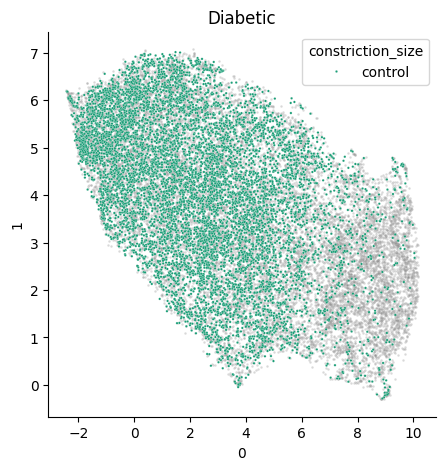

Healthy


Hypertension


Prediabetic


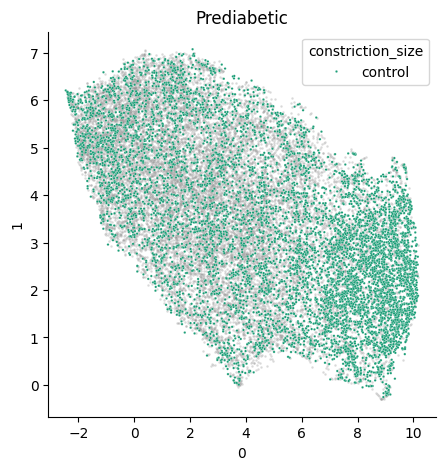

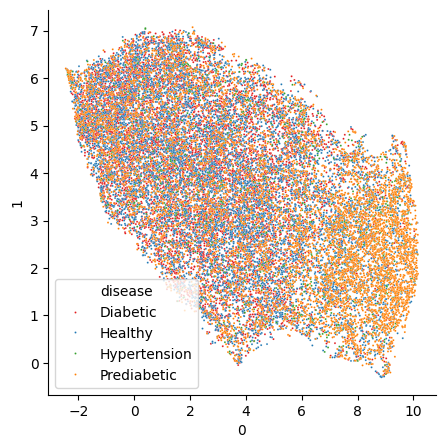

In [210]:

latent_list_df_lab

latent_list_df_lab_control=latent_list_df_lab[latent_list_df_lab['treatment']=='control']
latent_list_df_control=latent_list_df_lab_control.drop(['treatment','patient_id','disease','pathalogy'],axis=1)

import umap
reducer = umap.UMAP(random_state=250)

embedding_control = reducer.fit_transform(latent_list_df_control)
embedding_control.shape
embedding_control=pd.DataFrame(embedding_control)
embedding_control.index=latent_list_df_lab_control.index
embedding_control['patient_id']=latent_list_df_lab_control['patient_id']
embedding_control['constriction_size']=latent_list_df_lab_control['treatment']
embedding_control['disease']=latent_list_df_lab_control['disease']
embedding_control['disease_constric']=latent_list_df_lab_control['pathalogy']

for disease in np.unique(embedding_control['disease']):
    print(disease)
    plt.figure(figsize=(5, 5))
    masking_condition=embedding_control['disease']==disease
    sns.scatterplot(data=embedding_control[~masking_condition],x=0,y=1,s=3,color="gray", alpha=0.3)
    sns.scatterplot(data=embedding_control[masking_condition],x=0,y=1,s=3,hue="constriction_size",palette="Dark2")
    sns.despine() 
    plt.title(disease)
    plt.show()
    
paired_palette = sns.color_palette("Paired", n_colors=8)
control_palette = [paired_palette[5],paired_palette[1],paired_palette[3],paired_palette[7]]

plt.figure(figsize=(5, 5))
sns.scatterplot(data=embedding_control,x=0,y=1,s=2,hue="disease",palette=control_palette)
sns.despine() 
plt.show()

In [211]:
embedding_control

0         1  patient_id constriction_size      disease  \
6061  -1.907141  5.498038  64_control           control     Diabetic   
6062   1.021793  3.778707  80_control           control     Diabetic   
6063   0.743706  4.690286  46_control           control     Diabetic   
6064   2.647586  2.466934  46_control           control     Diabetic   
6065   1.670743  4.260341  35_control           control     Diabetic   
...         ...       ...         ...               ...          ...   
48022  5.109960  5.688972  37_control           control  Prediabetic   
48023  8.124804  0.310678  82_control           control  Prediabetic   
48024  8.843842  1.922960  45_control           control  Prediabetic   
48025  9.550538  2.446589  45_control           control  Prediabetic   
48026  1.349694  1.776919  45_control           control  Prediabetic   

          disease_constric  
6061      Diabetic_control  
6062      Diabetic_control  
6063      Diabetic_control  
6064      Diabetic_control  
6065      Diabetic_control  
...                    ...  
48022  Prediabetic_control  
48023  Prediabetic_control  
48024  Prediabetic_control  
48025  Prediabetic_control  
48026  Prediabetic_control  

[25196 rows x 6 columns]

In [212]:
def sample_algo(lists):
    
    balanced_list=[]   
    cell_count_mat=[]
    balanced_no=[]
    balanced_list_count=[]
    for a_list in lists:
        cell_count=sum(a_list)
        cell_count_mat.append(cell_count)
        balance=a_list-a_list.mean()
        balance[balance<0]=0
        balanced_list.append(a_list-balance)
        balanced_list_count.append(sum(a_list-balance))
        balanced_no.append(len(a_list))
        
    residue=(np.array(balanced_list_count)-min(np.array(balanced_list_count)))
    
    while max(residue)>5:
        final_balanced_list=[]
        final_balanced_list_count=[]
        new_residue=[]
        for a_residue,a_list in zip(residue,balanced_list):
            if a_residue>1:
                t=a_list.max()
                balance=a_list-t+1
                balance[balance<0]=0
                a_residue=a_residue-balance.sum()
                a_list=a_list-balance
                final_balanced_list.append(a_list)
                final_balanced_list_count.append((a_list).sum())
                new_residue.append(a_residue)
            else:
                new_residue.append(a_residue)
                final_balanced_list.append(a_list)
                final_balanced_list_count.append((a_list).sum())
        residue=np.array(new_residue)
        balanced_list=final_balanced_list
        
    return(balanced_list)

import numpy as np
import pandas as pd
import igraph as ig
import leidenalg
from sklearn.metrics import adjusted_rand_score
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
from sklearn.neighbors import NearestNeighbors

def consensus_leiden_dense(
    df,
    n_neighbors: int = 10,
    n_runs: int = 30,
    resolution: float = 1.0,
    seed0: int = 0,
    distance: str = "euclidean",
    threshold: float = 0.8,
):
    """
    Run consensus Leiden clustering on a dataframe of shape (cells, features).

    Parameters
    ----------
    df : pd.DataFrame
        Input data, rows=cells, cols=features.
    n_neighbors : int
        Number of neighbors for kNN graph.
    n_runs : int
        Number of Leiden runs with different seeds.
    resolution : float
        Resolution parameter for Leiden.
    seed0 : int
        Base random seed for reproducibility.
    distance : str
        Distance metric for sklearn NearestNeighbors.
    threshold : float
        Co-association threshold for consensus clustering.

    Returns
    -------
    labels_consensus : np.ndarray
        Final consensus cluster labels (string form).
    stability : dict
        Mean and std ARI of runs vs consensus, plus metadata.
    all_labels : np.ndarray
        Labels from all runs (n_runs × n_cells).
    """

    X = df#.values.astype(np.float32)
    n_cells = X.shape[0]

    # --- Build kNN graph once ---
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, metric=distance).fit(X)
    knn = nbrs.kneighbors_graph(X, mode="connectivity")

    sources, targets = knn.nonzero()
    g = ig.Graph(directed=False)
    g.add_vertices(n_cells)
    g.add_edges(list(zip(sources, targets)))

    # --- Multiple Leiden runs ---
    labels_runs = np.zeros((n_runs, n_cells), dtype=int)
    for r in range(n_runs):
        part = leidenalg.find_partition(
            g,
            leidenalg.RBConfigurationVertexPartition,
            resolution_parameter=resolution,
            seed=seed0 + r,
        )
        labels_runs[r] = np.array(part.membership)

    # --- Build co-association matrix ---
    P = np.zeros((n_cells, n_cells), dtype=np.float32)
    for r in range(n_runs):
        labs = labels_runs[r]
        for c in np.unique(labs):
            idx = np.where(labs == c)[0]
            P[np.ix_(idx, idx)] += 1.0
    P /= n_runs

    # --- Hierarchical consensus ---
    D = 1.0 - P
    Dv = squareform(D, checks=False)
    Z = linkage(Dv, method="average")
    flat = fcluster(Z, t=1-threshold, criterion="distance")
    labels_consensus = flat.astype(str)

    # --- Stability diagnostics ---
    aris = [adjusted_rand_score(labels_runs[r], flat) for r in range(n_runs)]
    stability = {
        "mean_ARI_to_consensus": float(np.mean(aris)),
        "std_ARI_to_consensus": float(np.std(aris)),
        "n_runs": n_runs,
        "resolution": resolution,
        "threshold": threshold,
        "n_neighbors": n_neighbors,
    }

    return labels_consensus, stability, labels_runs

from sklearn.metrics import recall_score, roc_auc_score, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import check_random_state
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import numpy as np

def global_cv_vs_permutation_null_by_class(
    df,
    target: str,
    drop_cols,
    class_labels,
    cv_splits: int = 5,
    n_permutations: int = 200,
    random_state: int = 42,
    n_est: int = 300,
    max_feat: int = 20,
):
    """
    Multiclass observed CV metrics vs permutation null (label-shuffled).
    Returns:
      results: dict with overall + per-class observed metrics and null distributions
      y_true: 1D array of true labels (aligned to rows in df)
      y_pred: 1D array of CV out-of-sample predicted labels
      y_proba: 2D array of CV out-of-sample class probabilities (n_samples x n_classes)
      classes: array of class labels in column order of y_proba
    """
    X = df.drop(columns=drop_cols, axis=1).copy()
    y = df[target].values
    classes = np.array(class_labels)  # preserve desired order if provided

    pipe = Pipeline(steps=[
        ("smote", SMOTE(random_state=random_state)),
        ("rf", RandomForestClassifier(
            n_estimators=n_est,
            max_features=max_feat,
            random_state=random_state
        ))
    ])

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    rng = check_random_state(random_state)

    # ---- Observed CV predictions (each sample predicted exactly once, out-of-sample)
    y_pred = cross_val_predict(pipe, X, y, cv=cv, method="predict")
    y_proba = cross_val_predict(pipe, X, y, cv=cv, method="predict_proba")

    # Align class order in y_proba columns to `classes`
    # (cross_val_predict uses the estimator's classes_; enforce reordering just in case)
    # Fit once to get the learned class order
    pipe.fit(X, y)
    learned_order = pipe.named_steps["rf"].classes_
    print(learned_order)
    # If the learned class order differs, reorder columns accordingly
    if not np.array_equal(learned_order, classes):
        # map from learned_order -> position in `classes`
        reorder_idx = [np.where(classes == c)[0][0] for c in learned_order]
        # Build y_proba in the canonical `classes` order
        y_proba_aligned = np.zeros_like(y_proba)
        for src_j, cls in enumerate(learned_order):
            dst_j = np.where(classes == cls)[0][0]
            y_proba_aligned[:, dst_j] = y_proba[:, src_j]
        y_proba = y_proba_aligned

    results = {}

    # ---- Overall metrics
    acc_obs = accuracy_score(y, y_pred)
    y_bin = label_binarize(y, classes=classes)
    auc_macro_obs = roc_auc_score(y_bin, y_proba, multi_class="ovr", average="macro")

    results["overall"] = {
        "acc_obs": acc_obs,
        "auc_macro_obs": auc_macro_obs,
        "acc_perm": [],
        "auc_macro_perm": []
    }

    # ---- Per-class (OvR) metrics
    for i, c in enumerate(classes):
        y_true_bin = (y == c).astype(int)
        y_pred_bin = (y_pred == c).astype(int)
        recall_c = recall_score(y_true_bin, y_pred_bin)  # class-wise recall
        auc_c = roc_auc_score(y_true_bin, y_proba[:, i]) # OvR AUC for class c
        results[f"class:{c}"] = {
            "recall_obs": recall_c,
            "auc_obs": auc_c,
            "recall_perm": [],
            "auc_perm": []
        }

    # ---- Permutation null distributions
    for b in range(n_permutations):
        y_perm = rng.permutation(y)
        y_pred_perm = cross_val_predict(pipe, X, y_perm, cv=cv, method="predict")
        y_proba_perm = cross_val_predict(pipe, X, y_perm, cv=cv, method="predict_proba")

        # Overall
        results["overall"]["acc_perm"].append(accuracy_score(y_perm, y_pred_perm))
        y_bin_perm = label_binarize(y_perm, classes=classes)
        results["overall"]["auc_macro_perm"].append(
            roc_auc_score(y_bin_perm, y_proba_perm, multi_class="ovr", average="macro")
        )

        # Per-class
        for i, c in enumerate(classes):
            y_true_bin = (y_perm == c).astype(int)
            y_pred_bin = (y_pred_perm == c).astype(int)
            results[f"class:{c}"]["recall_perm"].append(
                recall_score(y_true_bin, y_pred_bin)
            )
            results[f"class:{c}"]["auc_perm"].append(
                roc_auc_score(y_true_bin, y_proba_perm[:, i])
            )

    # Convert lists to arrays
    for k in results.keys():
        for key in results[k]:
            if isinstance(results[k][key], list):
                results[k][key] = np.array(results[k][key])

    return results, y, y_pred, y_proba, classes

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_multiclass_roc_from_cv(y_true, y_proba, classes, title="Multiclass ROC (CV out-of-sample)"):
    # One-vs-rest ROC per class + micro-average
    from sklearn.preprocessing import label_binarize
    y_bin = label_binarize(y_true, classes=classes)

    plt.figure(figsize=(5,5))
    for i, c in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{c} (AUC={roc_auc:.2f})")

    # micro-average
    fpr, tpr, _ = roc_curve(y_bin.ravel(), y_proba.ravel())
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, 'k--', lw=1.5, label=f"micro-average (AUC={roc_auc:.2f})")

    plt.plot([0,1],[0,1],'k:', lw=1)
    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(title, pad=20)
    sns.despine()
    plt.legend(frameon=False,  fontsize=12, borderaxespad=0.0)
    plt.tight_layout()
    plt.ylim(0,1)
    plt.show()

def plot_cv_vs_null_by_class(results, class_labels, title="Observed CV vs Null by Class"):
    labels, obs_acc, null_acc, null_acc_err = [], [], [], []
    obs_auc, null_auc, null_auc_err = [], [], []

    # Overall first
    labels.append("Overall")
    obs_acc.append(results["overall"]["acc_obs"])
    null_acc.append(np.mean(results["overall"]["acc_perm"]))
    null_acc_err.append(np.std(results["overall"]["acc_perm"]))
    obs_auc.append(results["overall"]["auc_macro_obs"])
    null_auc.append(np.mean(results["overall"]["auc_macro_perm"]))
    null_auc_err.append(np.std(results["overall"]["auc_macro_perm"]))

    # Classes
    for c in class_labels:
        r = results[f"class:{c}"]
        labels.append(str(c))
        obs_acc.append(r["recall_obs"])
        null_acc.append(np.mean(r["recall_perm"]))
        null_acc_err.append(np.std(r["recall_perm"]))
        obs_auc.append(r["auc_obs"])
        null_auc.append(np.mean(r["auc_perm"]))
        null_auc_err.append(np.std(r["auc_perm"]))

    x = np.arange(len(labels))
    width = 0.35

    # Accuracy/Recall plot
    plt.figure(figsize=(5,5))
    plt.bar(x - width/2, obs_acc, width, label="Observed Recall/Accuracy")
    plt.bar(x + width/2, null_acc, width, yerr=null_acc_err, capsize=4, label="Null Recall/Accuracy")
    plt.xticks(x, labels, rotation=30, fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylabel("Score", fontsize=12)
    plt.xlabel("Pathology and Overall", fontsize=12)
    plt.title(title + " (Recall / Accuracy)", pad=20)
    plt.legend(frameon=False,  fontsize=12, borderaxespad=0.0)
    sns.despine()
    plt.tight_layout()
    plt.ylim(0,1)
    plt.show()

    # AUC plot
    plt.figure(figsize=(5,5))
    plt.bar(x - width/2, obs_auc, width, label="Observed AUC")
    plt.bar(x + width/2, null_auc, width, yerr=null_auc_err, capsize=4, label="Null AUC")
    plt.xticks(x, labels, rotation=30, fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylabel("ROC-AUC", fontsize=12)
    plt.xlabel("Pathology and Overall", fontsize=12)
    plt.title(title + " (OvR AUC)", pad=20)
    # remove the legend border and background
    plt.legend(frameon=False,  fontsize=12, borderaxespad=0.0)
    sns.despine()
    plt.tight_layout()
    plt.ylim(0,1)
    plt.show()

In [213]:
latent_list_df_lab_control=latent_list_df_lab[latent_list_df_lab['treatment']=='control']
latent_list_df_lab_control = latent_list_df_lab_control[latent_list_df_lab_control['disease'] != "Hypertension"]
latent_list_df_lab_control_ulab=latent_list_df_lab_control.drop(['patient_id','treatment','disease','pathalogy'],axis=1)
latent_list_df_lab_control_ulab



0         1         2         3         4         5         6     \
6061   1.085100  0.043746  0.599473  0.606141  0.916404 -0.080682  0.754474   
6062  -0.323676 -0.225890  0.288633 -0.646063  0.683326  0.785588  0.370811   
6063  -0.933963  0.044166  0.937842 -0.626115  1.140554  0.869508  0.155773   
6064  -0.378162  0.288925  0.669372  0.279169  1.082925  0.257058  0.629754   
6065  -1.137652  0.316876  0.270395 -0.201411  0.439668  1.097938  0.395168   
...         ...       ...       ...       ...       ...       ...       ...   
48022 -1.168475 -0.202077  0.452993 -0.317935  1.242794  0.777082  1.173879   
48023 -1.432750 -0.351266  0.657320  1.221173  1.252507  1.391435  0.781465   
48024 -1.890509  0.395298 -0.061375 -0.291399  0.480684  0.939626  0.927283   
48025 -1.675604 -0.653714  0.345402 -0.162523  1.019981  1.123209  0.248833   
48026 -0.339652  0.504728  0.310743  0.240349  0.724050  1.247312  0.588893   

           7         8         9     ...      1014      1015      1016  \
6061  -0.707997  0.272114  0.081705  ... -0.204382 -0.106913 -1.107980   
6062  -0.703317  0.189317  0.572318  ...  1.817881  0.627279 -0.923595   
6063  -1.158844 -0.075066 -0.056026  ...  0.215826  1.386008 -0.830246   
6064  -0.981822  0.382657 -0.323707  ...  0.796010  1.571259 -0.547281   
6065  -0.563098  0.248879  1.374772  ... -0.027714  2.146362 -0.687075   
...         ...       ...       ...  ...       ...       ...       ...   
48022 -0.358091 -0.226757 -0.898895  ... -0.093475  2.195216 -1.397228   
48023 -0.387757  0.710523  0.030868  ... -0.280483  0.310612 -1.351416   
48024 -1.060284 -0.368105 -0.334766  ...  0.147774  1.136934 -0.247726   
48025 -0.821753 -0.482186 -0.441845  ... -0.271883  1.211474 -1.281788   
48026 -1.182382  0.231718  1.344448  ... -0.419182  1.500237  0.349719   

           1017      1018      1019      1020      1021      1022      1023  
6061   0.077446  1.541040 -1.408363  0.221000 -1.216308 -1.145159  1.348103  
6062  -0.147076 -0.162309 -1.033060 -0.174177  0.455565 -0.630059  0.452728  
6063   0.689366  0.019696 -2.170849 -0.286766  0.540076  0.251059 -0.781829  
6064   0.243890 -0.491695 -1.426417 -0.541967 -1.147912 -0.157463  0.223068  
6065  -0.683620  0.230578 -1.468401  0.836199 -0.210600 -0.435047 -0.282744  
...         ...       ...       ...       ...       ...       ...       ...  
48022 -0.160560  0.952927 -1.774714 -0.610886 -1.145523 -0.870107 -0.446982  
48023  0.558567 -0.442382 -1.337567  1.422160 -0.173863  0.020941  0.248681  
48024  0.095432  0.515350 -1.285093 -0.178142 -0.502306  0.185181 -0.822216  
48025 -0.032664 -0.191140 -0.837813  0.080616 -0.410553 -0.571894 -0.734310  
48026 -0.105705 -0.473086  0.018201  0.214949 -0.369675 -0.585672 -0.132596  

[24214 rows x 1024 columns]

In [214]:
latent_list_df_lab_control.groupby('patient_id').count()[0]


patient_id
103_control     125
105_control     710
106_control     442
107_control     458
108_control     772
109_control     638
110_control     392
111_control    2418
112_control     459
113_control     412
114_control      51
15_control        5
22_control       72
23_control      282
26_control      457
2_control        15
30_control      145
35_control      337
37_control      409
39_control       83
40_control       49
41_control       16
43_control       28
44_control      704
45_control     3331
46_control     1898
47_control       16
48_control       30
51_control      331
52_control      512
55_control      225
60_control      479
61_control      263
62_control      299
63_control       16
64_control      377
65_control     1477
66_control      163
67_control      431
69_control      431
6_control        59
73_control      198
74_control      175
76_control      274
78_control      199
80_control     1187
82_control      129
85_control      733
86_control      164
91_contro

In [215]:
latent_list_df_lab_control

0         1         2         3         4         5         6  \
6061   1.085100  0.043746  0.599473  0.606141  0.916404 -0.080682  0.754474   
6062  -0.323676 -0.225890  0.288633 -0.646063  0.683326  0.785588  0.370811   
6063  -0.933963  0.044166  0.937842 -0.626115  1.140554  0.869508  0.155773   
6064  -0.378162  0.288925  0.669372  0.279169  1.082925  0.257058  0.629754   
6065  -1.137652  0.316876  0.270395 -0.201411  0.439668  1.097938  0.395168   
...         ...       ...       ...       ...       ...       ...       ...   
48022 -1.168475 -0.202077  0.452993 -0.317935  1.242794  0.777082  1.173879   
48023 -1.432750 -0.351266  0.657320  1.221173  1.252507  1.391435  0.781465   
48024 -1.890509  0.395298 -0.061375 -0.291399  0.480684  0.939626  0.927283   
48025 -1.675604 -0.653714  0.345402 -0.162523  1.019981  1.123209  0.248833   
48026 -0.339652  0.504728  0.310743  0.240349  0.724050  1.247312  0.588893   

              7         8         9  ...      1018      1019      1020  \
6061  -0.707997  0.272114  0.081705  ...  1.541040 -1.408363  0.221000   
6062  -0.703317  0.189317  0.572318  ... -0.162309 -1.033060 -0.174177   
6063  -1.158844 -0.075066 -0.056026  ...  0.019696 -2.170849 -0.286766   
6064  -0.981822  0.382657 -0.323707  ... -0.491695 -1.426417 -0.541967   
6065  -0.563098  0.248879  1.374772  ...  0.230578 -1.468401  0.836199   
...         ...       ...       ...  ...       ...       ...       ...   
48022 -0.358091 -0.226757 -0.898895  ...  0.952927 -1.774714 -0.610886   
48023 -0.387757  0.710523  0.030868  ... -0.442382 -1.337567  1.422160   
48024 -1.060284 -0.368105 -0.334766  ...  0.515350 -1.285093 -0.178142   
48025 -0.821753 -0.482186 -0.441845  ... -0.191140 -0.837813  0.080616   
48026 -1.182382  0.231718  1.344448  ... -0.473086  0.018201  0.214949   

           1021      1022      1023            pathalogy  treatment  \
6061  -1.216308 -1.145159  1.348103     Diabetic_control    control   
6062   0.455565 -0.630059  0.452728     Diabetic_control    control   
6063   0.540076  0.251059 -0.781829     Diabetic_control    control   
6064  -1.147912 -0.157463  0.223068     Diabetic_control    control   
6065  -0.210600 -0.435047 -0.282744     Diabetic_control    control   
...         ...       ...       ...                  ...        ...   
48022 -1.145523 -0.870107 -0.446982  Prediabetic_control    control   
48023 -0.173863  0.020941  0.248681  Prediabetic_control    control   
48024 -0.502306  0.185181 -0.822216  Prediabetic_control    control   
48025 -0.410553 -0.571894 -0.734310  Prediabetic_control    control   
48026 -0.369675 -0.585672 -0.132596  Prediabetic_control    control   

           disease  patient_id  
6061      Diabetic  64_control  
6062      Diabetic  80_control  
6063      Diabetic  46_control  
6064      Diabetic  46_control  
6065      Diabetic  35_control  
...            ...         ...  
48022  Prediabetic  37_control  
48023  Prediabetic  82_control  
48024  Prediabetic  45_control  
48025  Prediabetic  45_control  
48026  Prediabetic  45_control  

[24214 rows x 1028 columns]

In [216]:
each_patho_cell_count=[]
each_patho_individual_count=[]
each_pat_id_count=[]

for a_disease in np.unique(latent_list_df_lab_control['disease']):
    disease_subset=latent_list_df_lab_control[latent_list_df_lab_control['disease']==a_disease]
    each_patho_cell_count.append(len(disease_subset))
    individual_count=len(np.unique(disease_subset['patient_id']))
    each_patho_individual_count.append(individual_count)
    each_pat_id_cells=disease_subset.groupby('patient_id').count()
    each_pat_id_count.append(each_pat_id_cells[0])
    
each_pat_id_count_mod=[each_pat_id_count[0],each_pat_id_count[1],each_pat_id_count[2]]
balanced_list=sample_algo(each_pat_id_count_mod)
balanced_list=pd.concat(balanced_list)

sampling_matrix=pd.DataFrame({'patient_id':balanced_list.index,'sampling':balanced_list.values.astype(int)})

latent_list_df_lab_control['balanced_sample']=0
sampled_df_list=[]

for pat_id in np.unique(latent_list_df_lab_control['patient_id']): 
    to_be_sampled=latent_list_df_lab_control[latent_list_df_lab_control['patient_id']==pat_id]
    sample_size=sampling_matrix.sampling[sampling_matrix['patient_id']==pat_id]

    if sample_size.values:
        sample_size=int(sample_size.values)
        sampled_df=to_be_sampled.sample(sample_size,ignore_index=False,random_state=14)
        sampled_index=list(sampled_df.index.values)
        latent_list_df_lab_control.loc[sampled_index,'balanced_sample']=1
        

latent_list_df_lab_control_ulab=latent_list_df_lab_control.drop(['patient_id','treatment','disease','pathalogy'],axis=1)
latent_list_df_lab_control_ulab

/tmp/ipykernel_2211394/1255615806.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sample_size=int(sample_size.values)
/tmp/ipykernel_2211394/1255615806.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sample_size=int(sample_size.values)
/tmp/ipykernel_2211394/1255615806.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sample_size=int(sample_size.values)
/tmp/ipykernel_2211394/1255615806.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to

0         1         2         3         4         5         6  \
6061   1.085100  0.043746  0.599473  0.606141  0.916404 -0.080682  0.754474   
6062  -0.323676 -0.225890  0.288633 -0.646063  0.683326  0.785588  0.370811   
6063  -0.933963  0.044166  0.937842 -0.626115  1.140554  0.869508  0.155773   
6064  -0.378162  0.288925  0.669372  0.279169  1.082925  0.257058  0.629754   
6065  -1.137652  0.316876  0.270395 -0.201411  0.439668  1.097938  0.395168   
...         ...       ...       ...       ...       ...       ...       ...   
48022 -1.168475 -0.202077  0.452993 -0.317935  1.242794  0.777082  1.173879   
48023 -1.432750 -0.351266  0.657320  1.221173  1.252507  1.391435  0.781465   
48024 -1.890509  0.395298 -0.061375 -0.291399  0.480684  0.939626  0.927283   
48025 -1.675604 -0.653714  0.345402 -0.162523  1.019981  1.123209  0.248833   
48026 -0.339652  0.504728  0.310743  0.240349  0.724050  1.247312  0.588893   

              7         8         9  ...      1015      1016      1017  \
6061  -0.707997  0.272114  0.081705  ... -0.106913 -1.107980  0.077446   
6062  -0.703317  0.189317  0.572318  ...  0.627279 -0.923595 -0.147076   
6063  -1.158844 -0.075066 -0.056026  ...  1.386008 -0.830246  0.689366   
6064  -0.981822  0.382657 -0.323707  ...  1.571259 -0.547281  0.243890   
6065  -0.563098  0.248879  1.374772  ...  2.146362 -0.687075 -0.683620   
...         ...       ...       ...  ...       ...       ...       ...   
48022 -0.358091 -0.226757 -0.898895  ...  2.195216 -1.397228 -0.160560   
48023 -0.387757  0.710523  0.030868  ...  0.310612 -1.351416  0.558567   
48024 -1.060284 -0.368105 -0.334766  ...  1.136934 -0.247726  0.095432   
48025 -0.821753 -0.482186 -0.441845  ...  1.211474 -1.281788 -0.032664   
48026 -1.182382  0.231718  1.344448  ...  1.500237  0.349719 -0.105705   

           1018      1019      1020      1021      1022      1023  \
6061   1.541040 -1.408363  0.221000 -1.216308 -1.145159  1.348103   
6062  -0.162309 -1.033060 -0.174177  0.455565 -0.630059  0.452728   
6063   0.019696 -2.170849 -0.286766  0.540076  0.251059 -0.781829   
6064  -0.491695 -1.426417 -0.541967 -1.147912 -0.157463  0.223068   
6065   0.230578 -1.468401  0.836199 -0.210600 -0.435047 -0.282744   
...         ...       ...       ...       ...       ...       ...   
48022  0.952927 -1.774714 -0.610886 -1.145523 -0.870107 -0.446982   
48023 -0.442382 -1.337567  1.422160 -0.173863  0.020941  0.248681   
48024  0.515350 -1.285093 -0.178142 -0.502306  0.185181 -0.822216   
48025 -0.191140 -0.837813  0.080616 -0.410553 -0.571894 -0.734310   
48026 -0.473086  0.018201  0.214949 -0.369675 -0.585672 -0.132596   

       balanced_sample  
6061                 0  
6062                 0  
6063                 0  
6064                 0  
6065                 0  
...                ...  
48022                1  
48023                1  
48024                0  
48025                0  
48026                0  

[24214 rows x 1025 columns]

['1' '10' '100' '101' '102' '103' '104' '105' '106' '107' '108' '109' '11'
 '110' '111' '112' '113' '114' '115' '116' '117' '118' '119' '12' '120'
 '121' '13' '14' '15' '16' '17' '18' '19' '2' '20' '21' '22' '23' '24'
 '25' '26' '27' '28' '29' '3' '30' '31' '32' '33' '34' '35' '36' '37' '38'
 '39' '4' '40' '41' '42' '43' '44' '45' '46' '47' '48' '49' '5' '50' '51'
 '52' '53' '54' '55' '56' '57' '58' '59' '6' '60' '61' '62' '63' '64' '65'
 '66' '67' '68' '69' '7' '70' '71' '72' '73' '74' '75' '76' '77' '78' '79'
 '8' '80' '81' '82' '83' '84' '85' '86' '87' '88' '89' '9' '90' '91' '92'
 '93' '94' '95' '96' '97' '98' '99']
[1674    2   91    1    1    1    1    3   10    2  637   20   11   69
   23    2    1    3  299   61  173    2    7    3  157    1    2    3
    6  373    6   21    2    1    3 2265    1    1   99   19   10  108
    1    2    1    1    1    1    3    3    2    1   18    7    1    1
    2    6    6    5   83   17  202   12    1   52  171    1   14 1081
   64   20    5  

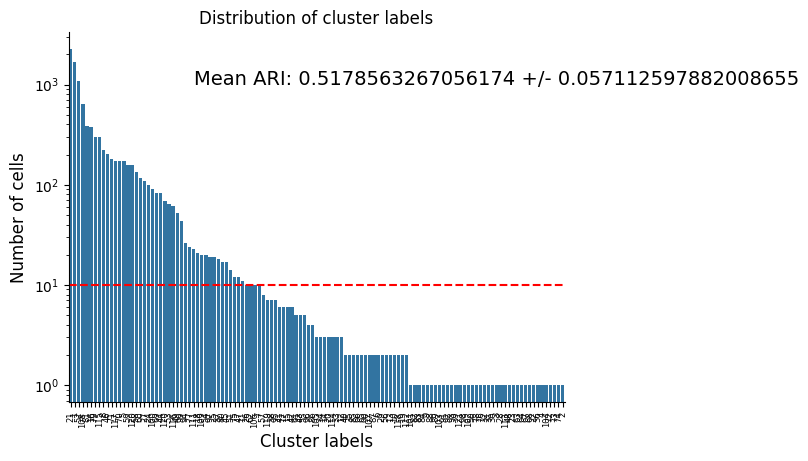

{'mean_ARI_to_consensus': 0.5178563267056174, 'std_ARI_to_consensus': 0.057112597882008655, 'n_runs': 50, 'resolution': 0.6, 'threshold': 0.8, 'n_neighbors': 50}
28
9456
9936
9456
['1' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '2' '20' '21' '22'
 '23' '24' '25' '26' '27' '28' '29' '3' '30' '31' '4' '5' '6' '7' '8' '9']
[   2   49    2 1652    1    1    1    1    3  199  539    1   54   99
  970    1  301    1  536    1    1  211 1879  322    1  187   22   15
    1 2402    1]
[  49 1652  199  539   54   99  970  301  536  211 1879  322  187 2402]
14


{'mean_ARI_to_consensus': 0.711625171281474, 'std_ARI_to_consensus': 0.06845774464445978, 'n_runs': 50, 'resolution': 0.6, 'threshold': 0.8, 'n_neighbors': 50}
14
9400
9456
9400
['1' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '2' '20' '21' '22'
 '23' '3' '4' '5' '6' '7' '8' '9']
[1879  330    6  148    2 1327    1    1  382   32  616  155   61    1
   22    6  183  201    1    1 2397    1 1647]
[1879  330  148 1327  382   32  616  155   61  183  201 2397 1647]
13


{'mean_ARI_to_consensus': 0.7655417305748188, 'std_ARI_to_consensus': 0.07248543829608337, 'n_runs': 50, 'resolution': 0.6, 'threshold': 0.8, 'n_neighbors': 50}
13
9358
9400
9358
['1' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '2' '3' '4' '5' '6'
 '7' '8' '9']
[1881   51  416    3 2397    1  194    2  574   82  953  129  279    4
 1694  636    4   57    1]
[1881   51  416 2397  194  574   82  953  129  279 1694  636   57]
13


{'mean_ARI_to_consensus': 0.7614456522241682, 'std_ARI_to_consensus': 0.0740264814948268, 'n_runs': 50, 'resolution': 0.6, 'threshold': 0.8, 'n_neighbors': 50}
13
9343
9358
9343
['1' '10' '11' '12' '13' '14' '15' '2' '3' '4' '5' '6' '7' '8' '9']
[  94   94   25  587    6   51  455 1575 2397  134 1879   59    1   19
 1967]
[  94   94  587   51  455 1575 2397  134 1879   59 1967]
11


{'mean_ARI_to_consensus': 0.8242049402133267, 'std_ARI_to_consensus': 0.10481040146033432, 'n_runs': 50, 'resolution': 0.6, 'threshold': 0.8, 'n_neighbors': 50}
11
9292
9343
9292
['1' '10' '11' '2' '3' '4' '5' '6' '7' '8' '9']
[  95    2 1608 1888   49 1967  601  441 2397   49  195]
[  95 1608 1888   49 1967  601  441 2397   49  195]
10


{'mean_ARI_to_consensus': 0.8546443369160629, 'std_ARI_to_consensus': 0.09879235630157143, 'n_runs': 50, 'resolution': 0.6, 'threshold': 0.8, 'n_neighbors': 50}
10
9290
9292
9290
['1' '10' '11' '12' '2' '3' '4' '5' '6' '7' '8' '9']
[2397  605  422   19   49 1603  200 1937    5   86 1966    1]
[2397  605  422   49 1603  200 1937   86 1966]
9


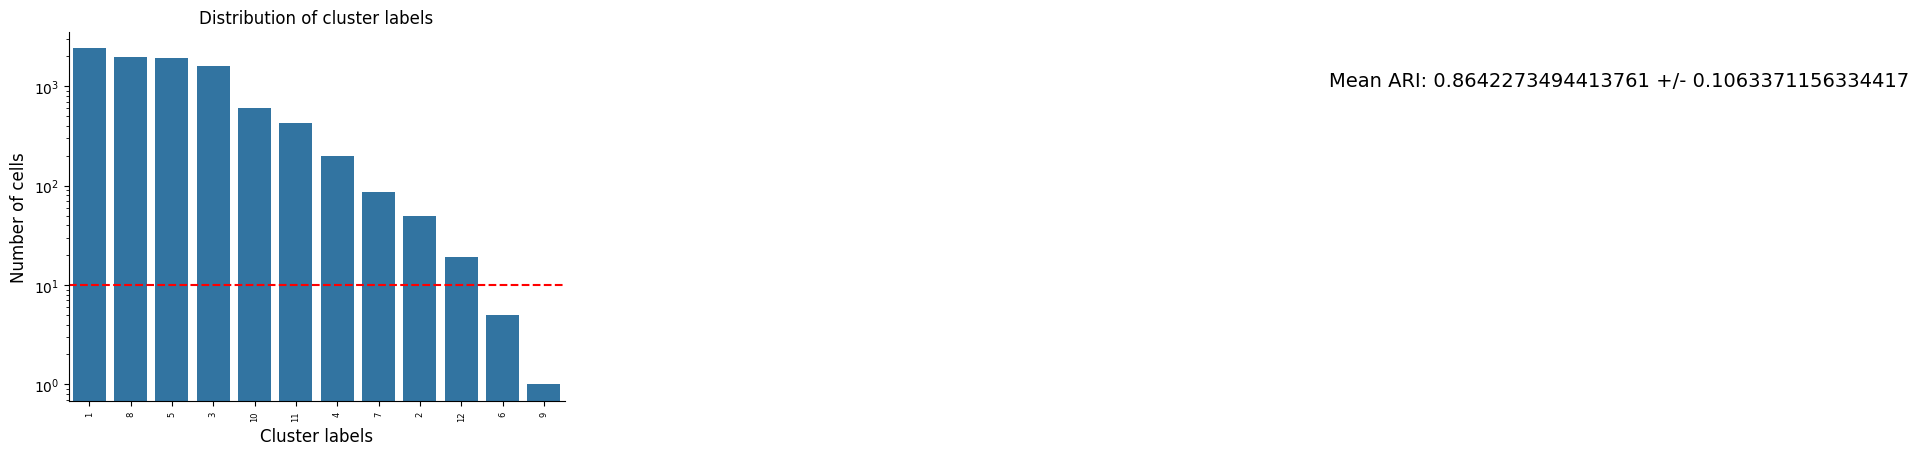

{'mean_ARI_to_consensus': 0.8642273494413761, 'std_ARI_to_consensus': 0.1063371156334417, 'n_runs': 50, 'resolution': 0.6, 'threshold': 0.8, 'n_neighbors': 50}
9
9265
9290
9265
['1' '10' '11' '12' '2' '3' '4' '5' '6' '7' '8' '9']
[1526  411  591  111  130  196 2397   47 1890    3 1962    1]
[1526  411  591  111  130  196 2397   47 1890 1962]
10


{'mean_ARI_to_consensus': 0.8382305699882296, 'std_ARI_to_consensus': 0.11403867797118246, 'n_runs': 50, 'resolution': 0.6, 'threshold': 0.8, 'n_neighbors': 50}
10
9261
9265
9261
['1' '2' '3' '4' '5' '6' '7' '8' '9']
[  96 1930 1962  195 2397  418  606   48 1609]
[  96 1930 1962  195 2397  418  606   48 1609]
9


{'mean_ARI_to_consensus': 0.8532584937637138, 'std_ARI_to_consensus': 0.10201149252456362, 'n_runs': 50, 'resolution': 0.6, 'threshold': 0.8, 'n_neighbors': 50}
9
9261
9261
9261
['1' '2' '3' '4' '5' '6' '7' '8' '9']
[  96 1930 1962  195 2397  418  606   48 1609]
[  96 1930 1962  195 2397  418  606   48 1609]
9


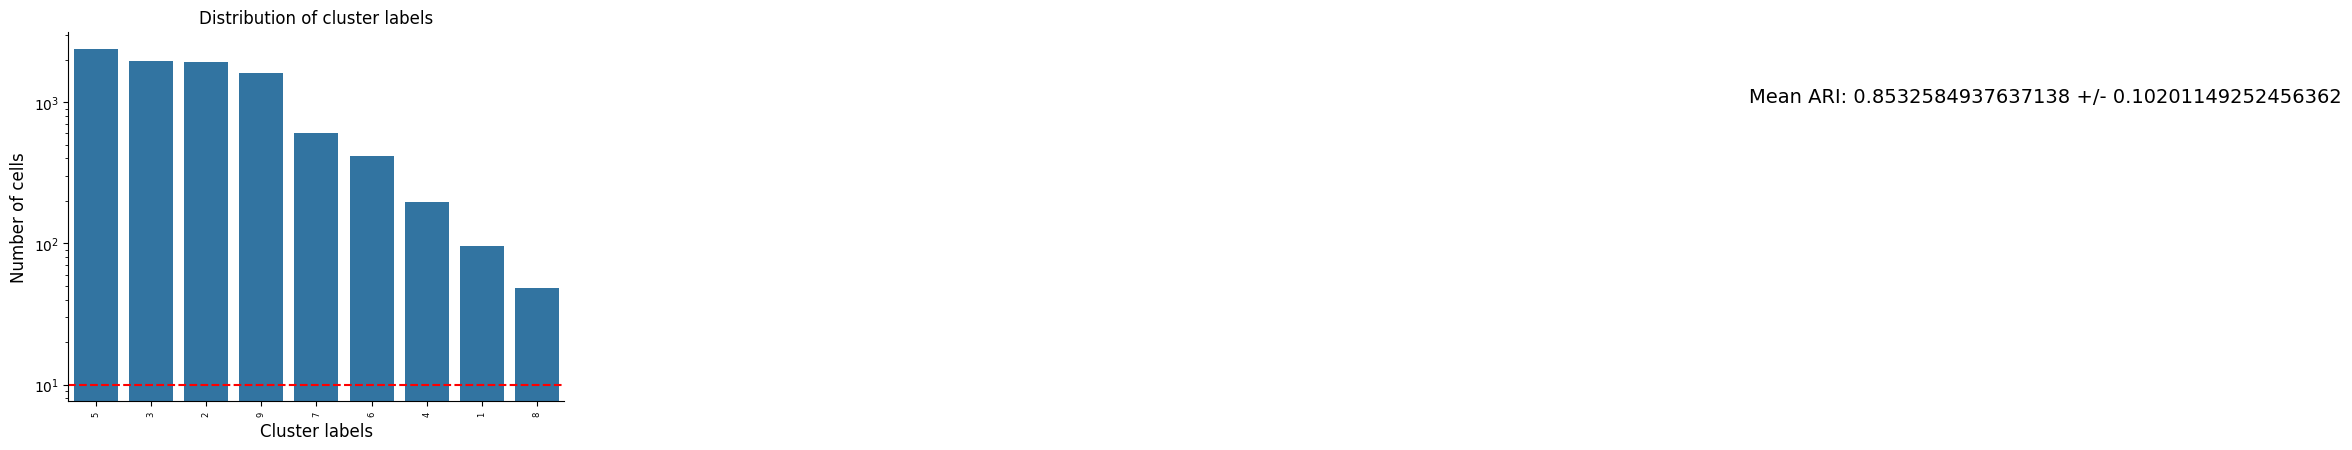

{'mean_ARI_to_consensus': 0.8532584937637138, 'std_ARI_to_consensus': 0.10201149252456362, 'n_runs': 50, 'resolution': 0.6, 'threshold': 0.8, 'n_neighbors': 50}
9
9261
9261
9261


In [217]:
latent_list_df_lab_control_ulab_bal=latent_list_df_lab_control_ulab[latent_list_df_lab_control_ulab['balanced_sample']==1]
latent_list_df_lab_control_ulab_bal=latent_list_df_lab_control_ulab_bal.drop(['balanced_sample'],axis=1)
for_clusters=latent_list_df_lab_control_ulab_bal
stability_list=[]
for i in range(10):
    labels, stability, all_labels = consensus_leiden_dense(
        for_clusters,
        n_neighbors=50,
        n_runs=50,
        resolution=0.6,
        threshold=0.8,
    )
    unique_labels, unique_counts = np.unique(labels, return_counts=True)
    print(unique_labels)
    print(unique_counts)
    unique_counts_gt_10=unique_counts[unique_counts>30]
    print(unique_counts_gt_10)
    print(len(unique_counts_gt_10))

    labels_counts = pd.DataFrame({'labels': unique_labels, 'counts': unique_counts})
    order = labels_counts.sort_values(by='counts', ascending=False)['labels']
    sns.barplot(x = labels_counts['labels'], y = labels_counts['counts'], data=labels_counts, order=order)
    plt.xlabel('Cluster labels')
    plt.ylabel('Number of cells')
    plt.title('Distribution of cluster labels')
    plt.xlabel('Cluster labels', fontsize=12)
    plt.ylabel('Number of cells', fontsize=12)
    plt.xticks(fontsize=6, rotation=90)
    plt.title('Distribution of cluster labels')
    #draw a line at 10
    plt.axhline(y=10, color='red', linestyle='--')
    sns.despine()
    plt.yscale('log')
    # annotate the mean ARI of the stability
    plt.text(30, 1000, 'Mean ARI: ' + str(stability['mean_ARI_to_consensus'])+' +/- ' + str(stability['std_ARI_to_consensus']), fontsize=14)
    plt.show()

    print(stability)
    stability_list.append(stability)

    unique_counts_gt_10=unique_counts[unique_counts>30]

    print(len(unique_counts_gt_10))
    print(sum(unique_counts_gt_10))
    print(sum(unique_counts))

    unique_labels[unique_counts >= 30]
    sum(unique_counts[unique_counts >= 30])

    keep_labels = unique_labels[unique_counts >= 30]
    setB = set(keep_labels)
    idx = [i for i, x in enumerate(labels) if x in setB]
    for_clusters=for_clusters.iloc[idx,:]
    print(len(for_clusters))



    


In [223]:
labels

array(['5', '7', '9', ..., '2', '7', '2'], dtype='<U11')

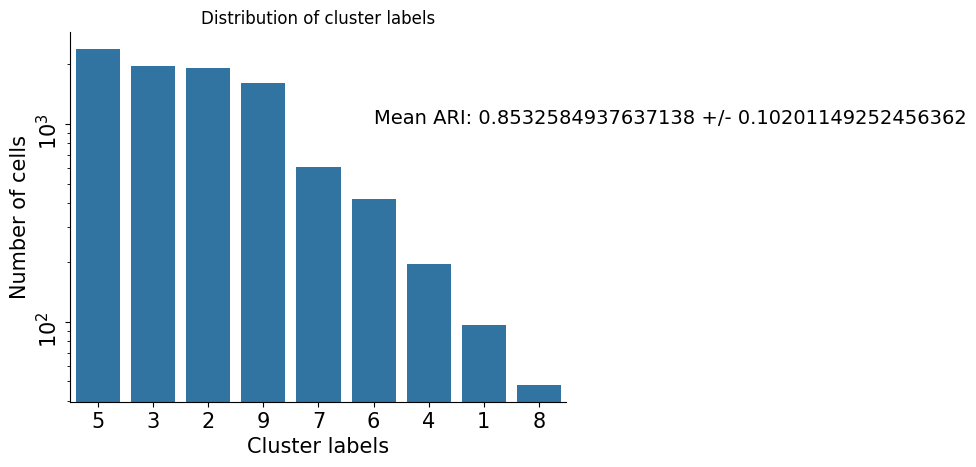

9261

In [220]:
# latent_list_df_lab_control_ulab_bal
# keep_labels

labels_counts = pd.DataFrame({'labels': unique_labels, 'counts': unique_counts})
order = labels_counts.sort_values(by='counts', ascending=False)['labels']
sns.barplot(x = labels_counts['labels'], y = labels_counts['counts'], data=labels_counts, order=order)
plt.xlabel('Cluster labels')
plt.ylabel('Number of cells')
plt.title('Distribution of cluster labels')
plt.xlabel('Cluster labels', fontsize=15)
plt.ylabel('Number of cells', fontsize=15)
plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15, rotation=90)
plt.title('Distribution of cluster labels')
#draw a line at 10
#plt.axhline(y=30, color='red', linestyle='--')
sns.despine()
plt.yscale('log')
# annotate the mean ARI of the stability
plt.text(5, 1000, 'Mean ARI: ' + str(stability['mean_ARI_to_consensus'])+' +/- ' + str(stability['std_ARI_to_consensus']), fontsize=14)
plt.show()

# for_clusters
len(idx)

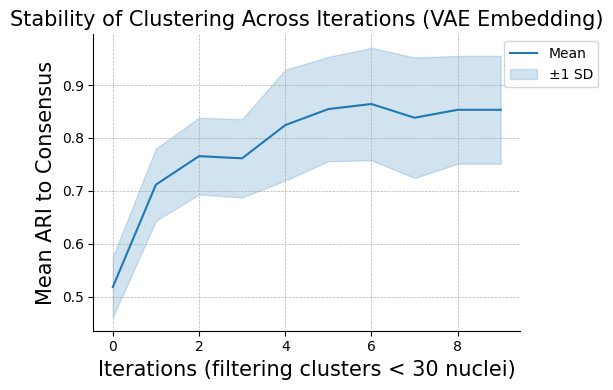

In [224]:
stability_stats = pd.DataFrame(stability_list)
stability_stats
import matplotlib.pyplot as plt

# assume df has columns: 'x', 'mean', 'std'
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(stability_stats.index, stability_stats['mean_ARI_to_consensus'], color='tab:blue', label='Mean')
ax.fill_between(
    stability_stats.index,
    stability_stats['mean_ARI_to_consensus'] - stability_stats['std_ARI_to_consensus'],
    stability_stats['mean_ARI_to_consensus'] + stability_stats['std_ARI_to_consensus'],
    color='tab:blue',
    alpha=0.2,
    label='±1 SD'
)

ax.set_xlabel('Iterations (filtering clusters < 30 nuclei)', fontsize = 15)
ax.set_ylabel('Mean ARI to Consensus', fontsize = 15)
ax.set_title('Stability of Clustering Across Iterations (VAE Embedding)', fontsize = 15)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1), fontsize=10)
ax.grid(True, linestyle='--', linewidth=0.5)
sns.despine()
plt.tight_layout()
plt.show()

In [225]:
latent_list_df_lab_control_ulab_bal
for_clusters

0         1         2         3         4         5         6     \
6070  -0.126488 -0.601086  1.511624 -0.202848  1.018331  0.708240  0.474916   
6072  -0.912429  0.277590 -0.325058 -0.789928  0.867110  1.035311  0.598648   
6076   0.266504 -0.201821  0.672869 -0.179502  0.705694 -0.052834 -0.472677   
6079  -0.666693 -0.420844  0.275390 -1.085743  0.753978  0.840505  0.708350   
6080  -0.886165 -0.496722  0.502099 -0.145352  0.856247  0.156329  0.786899   
...         ...       ...       ...       ...       ...       ...       ...   
48016 -0.961765 -0.283965  0.669445  0.686917 -0.356890  0.370267  1.004903   
48017 -1.082994 -0.432188  0.309158  0.829913  1.213373  0.270981  0.931427   
48019 -0.541443  0.605502  0.878419  0.865016  0.948599  0.935529  0.469789   
48022 -1.168475 -0.202077  0.452993 -0.317935  1.242794  0.777082  1.173879   
48023 -1.432750 -0.351266  0.657320  1.221173  1.252507  1.391435  0.781465   

           7         8         9     ...      1014      1015      1016  \
6070  -0.992645  0.593537  0.285177  ... -0.018681  0.390487 -0.670086   
6072  -0.871096 -0.208733 -0.418615  ... -0.423802  1.349307 -0.431221   
6076  -0.272036 -0.144319 -0.265375  ...  0.368923  1.417949 -0.619438   
6079  -0.094013  0.108004  0.543792  ...  0.663192  0.553577 -0.896470   
6080  -0.967341 -0.218601  0.068543  ...  0.707996  0.230495 -0.696642   
...         ...       ...       ...  ...       ...       ...       ...   
48016 -0.901623 -0.237537 -0.586098  ...  0.130671  0.223393 -1.400378   
48017 -1.101567  0.481204  0.236068  ... -0.226760  0.794020 -0.822238   
48019 -0.541661  0.462426  0.076081  ...  0.085308 -0.230569 -1.318788   
48022 -0.358091 -0.226757 -0.898895  ... -0.093475  2.195216 -1.397228   
48023 -0.387757  0.710523  0.030868  ... -0.280483  0.310612 -1.351416   

           1017      1018      1019      1020      1021      1022      1023  
6070  -0.250116  0.722530 -0.014005  0.195168 -0.233393 -0.067743  0.251545  
6072  -0.350582  0.677479 -1.567805 -0.760987 -0.282977 -1.063093 -0.265417  
6076   0.499579 -0.296631 -1.753492  0.712790 -1.024546  0.303948 -0.004849  
6079   0.522265 -0.405458 -1.943481  0.252007 -0.462630  0.252746  0.816639  
6080  -0.178817  0.116794 -2.216630  0.125201 -1.022745 -0.870068  0.343902  
...         ...       ...       ...       ...       ...       ...       ...  
48016 -0.500272  0.638478 -1.084164  0.452375 -1.521562 -0.059562  0.477941  
48017 -0.060781  0.754120 -1.736187  0.407165 -1.290243 -0.436443 -0.088391  
48019  0.492565  0.354520 -1.150743  0.603909 -0.392356 -0.394095 -0.075373  
48022 -0.160560  0.952927 -1.774714 -0.610886 -1.145523 -0.870107 -0.446982  
48023  0.558567 -0.442382 -1.337567  1.422160 -0.173863  0.020941  0.248681  

[9261 rows x 1024 columns]

In [ ]:
for_clusters_clustered = for_clusters.copy()
# latent_list_df_lab_control['label_leiden']
for_clusters_clustered['labels_leiden'] = labels
for_clusters_clustered


0         1         2         3         4         5         6  \
6070  -0.126488 -0.601086  1.511624 -0.202848  1.018331  0.708240  0.474916   
6072  -0.912429  0.277590 -0.325058 -0.789928  0.867110  1.035311  0.598648   
6076   0.266504 -0.201821  0.672869 -0.179502  0.705694 -0.052834 -0.472677   
6079  -0.666693 -0.420844  0.275390 -1.085743  0.753978  0.840505  0.708350   
6080  -0.886165 -0.496722  0.502099 -0.145352  0.856247  0.156329  0.786899   
...         ...       ...       ...       ...       ...       ...       ...   
48016 -0.961765 -0.283965  0.669445  0.686917 -0.356890  0.370267  1.004903   
48017 -1.082994 -0.432188  0.309158  0.829913  1.213373  0.270981  0.931427   
48019 -0.541443  0.605502  0.878419  0.865016  0.948599  0.935529  0.469789   
48022 -1.168475 -0.202077  0.452993 -0.317935  1.242794  0.777082  1.173879   
48023 -1.432750 -0.351266  0.657320  1.221173  1.252507  1.391435  0.781465   

              7         8         9  ...      1015      1016      1017  \
6070  -0.992645  0.593537  0.285177  ...  0.390487 -0.670086 -0.250116   
6072  -0.871096 -0.208733 -0.418615  ...  1.349307 -0.431221 -0.350582   
6076  -0.272036 -0.144319 -0.265375  ...  1.417949 -0.619438  0.499579   
6079  -0.094013  0.108004  0.543792  ...  0.553577 -0.896470  0.522265   
6080  -0.967341 -0.218601  0.068543  ...  0.230495 -0.696642 -0.178817   
...         ...       ...       ...  ...       ...       ...       ...   
48016 -0.901623 -0.237537 -0.586098  ...  0.223393 -1.400378 -0.500272   
48017 -1.101567  0.481204  0.236068  ...  0.794020 -0.822238 -0.060781   
48019 -0.541661  0.462426  0.076081  ... -0.230569 -1.318788  0.492565   
48022 -0.358091 -0.226757 -0.898895  ...  2.195216 -1.397228 -0.160560   
48023 -0.387757  0.710523  0.030868  ...  0.310612 -1.351416  0.558567   

           1018      1019      1020      1021      1022      1023  \
6070   0.722530 -0.014005  0.195168 -0.233393 -0.067743  0.251545   
6072   0.677479 -1.567805 -0.760987 -0.282977 -1.063093 -0.265417   
6076  -0.296631 -1.753492  0.712790 -1.024546  0.303948 -0.004849   
6079  -0.405458 -1.943481  0.252007 -0.462630  0.252746  0.816639   
6080   0.116794 -2.216630  0.125201 -1.022745 -0.870068  0.343902   
...         ...       ...       ...       ...       ...       ...   
48016  0.638478 -1.084164  0.452375 -1.521562 -0.059562  0.477941   
48017  0.754120 -1.736187  0.407165 -1.290243 -0.436443 -0.088391   
48019  0.354520 -1.150743  0.603909 -0.392356 -0.394095 -0.075373   
48022  0.952927 -1.774714 -0.610886 -1.145523 -0.870107 -0.446982   
48023 -0.442382 -1.337567  1.422160 -0.173863  0.020941  0.248681   

       labels_leiden  
6070               5  
6072               7  
6076               9  
6079               3  
6080               6  
...              ...  
48016              4  
48017              2  
48019              2  
48022              7  
48023              2  

[9261 rows x 1025 columns]

In [227]:
name_map = {"2": "C1", "1": "C2", "3": "C3", "6": "C4", "7": "C5",  "9": "C6", "4": "C7","5": "C8", "8": "C9"}
name_map
for_clusters_clustered["labels_leiden"] = for_clusters_clustered["labels_leiden"].replace(name_map)
for_clusters_clustered

0         1         2         3         4         5         6  \
6070  -0.126488 -0.601086  1.511624 -0.202848  1.018331  0.708240  0.474916   
6072  -0.912429  0.277590 -0.325058 -0.789928  0.867110  1.035311  0.598648   
6076   0.266504 -0.201821  0.672869 -0.179502  0.705694 -0.052834 -0.472677   
6079  -0.666693 -0.420844  0.275390 -1.085743  0.753978  0.840505  0.708350   
6080  -0.886165 -0.496722  0.502099 -0.145352  0.856247  0.156329  0.786899   
...         ...       ...       ...       ...       ...       ...       ...   
48016 -0.961765 -0.283965  0.669445  0.686917 -0.356890  0.370267  1.004903   
48017 -1.082994 -0.432188  0.309158  0.829913  1.213373  0.270981  0.931427   
48019 -0.541443  0.605502  0.878419  0.865016  0.948599  0.935529  0.469789   
48022 -1.168475 -0.202077  0.452993 -0.317935  1.242794  0.777082  1.173879   
48023 -1.432750 -0.351266  0.657320  1.221173  1.252507  1.391435  0.781465   

              7         8         9  ...      1015      1016      1017  \
6070  -0.992645  0.593537  0.285177  ...  0.390487 -0.670086 -0.250116   
6072  -0.871096 -0.208733 -0.418615  ...  1.349307 -0.431221 -0.350582   
6076  -0.272036 -0.144319 -0.265375  ...  1.417949 -0.619438  0.499579   
6079  -0.094013  0.108004  0.543792  ...  0.553577 -0.896470  0.522265   
6080  -0.967341 -0.218601  0.068543  ...  0.230495 -0.696642 -0.178817   
...         ...       ...       ...  ...       ...       ...       ...   
48016 -0.901623 -0.237537 -0.586098  ...  0.223393 -1.400378 -0.500272   
48017 -1.101567  0.481204  0.236068  ...  0.794020 -0.822238 -0.060781   
48019 -0.541661  0.462426  0.076081  ... -0.230569 -1.318788  0.492565   
48022 -0.358091 -0.226757 -0.898895  ...  2.195216 -1.397228 -0.160560   
48023 -0.387757  0.710523  0.030868  ...  0.310612 -1.351416  0.558567   

           1018      1019      1020      1021      1022      1023  \
6070   0.722530 -0.014005  0.195168 -0.233393 -0.067743  0.251545   
6072   0.677479 -1.567805 -0.760987 -0.282977 -1.063093 -0.265417   
6076  -0.296631 -1.753492  0.712790 -1.024546  0.303948 -0.004849   
6079  -0.405458 -1.943481  0.252007 -0.462630  0.252746  0.816639   
6080   0.116794 -2.216630  0.125201 -1.022745 -0.870068  0.343902   
...         ...       ...       ...       ...       ...       ...   
48016  0.638478 -1.084164  0.452375 -1.521562 -0.059562  0.477941   
48017  0.754120 -1.736187  0.407165 -1.290243 -0.436443 -0.088391   
48019  0.354520 -1.150743  0.603909 -0.392356 -0.394095 -0.075373   
48022  0.952927 -1.774714 -0.610886 -1.145523 -0.870107 -0.446982   
48023 -0.442382 -1.337567  1.422160 -0.173863  0.020941  0.248681   

       labels_leiden  
6070              C8  
6072              C5  
6076              C6  
6079              C3  
6080              C4  
...              ...  
48016             C7  
48017             C1  
48019             C1  
48022             C5  
48023             C1  

[9261 rows x 1025 columns]

In [228]:
for_clusters_clustered
latent_list_df_lab_control_ulab_bal['labels_leiden'] = for_clusters_clustered['labels_leiden']
latent_list_df_lab_control_ulab_bal['labels_leiden'] = latent_list_df_lab_control_ulab_bal['labels_leiden'].fillna('uc')
# latent_list_df_lab_control_ulab_bal[latent_list_df_lab_control_ulab_bal['labels_leiden'].isna()]['labels_leiden'] = "uc"
# latent_list_df_lab_control_ulab_bal

In [229]:
latent_list_df_lab_control_ulab_bal

0         1         2         3         4         5         6  \
6070  -0.126488 -0.601086  1.511624 -0.202848  1.018331  0.708240  0.474916   
6072  -0.912429  0.277590 -0.325058 -0.789928  0.867110  1.035311  0.598648   
6076   0.266504 -0.201821  0.672869 -0.179502  0.705694 -0.052834 -0.472677   
6078  -0.269873 -0.345175  0.165041  0.275785  0.209808  0.449189  1.208220   
6079  -0.666693 -0.420844  0.275390 -1.085743  0.753978  0.840505  0.708350   
...         ...       ...       ...       ...       ...       ...       ...   
48016 -0.961765 -0.283965  0.669445  0.686917 -0.356890  0.370267  1.004903   
48017 -1.082994 -0.432188  0.309158  0.829913  1.213373  0.270981  0.931427   
48019 -0.541443  0.605502  0.878419  0.865016  0.948599  0.935529  0.469789   
48022 -1.168475 -0.202077  0.452993 -0.317935  1.242794  0.777082  1.173879   
48023 -1.432750 -0.351266  0.657320  1.221173  1.252507  1.391435  0.781465   

              7         8         9  ...      1015      1016      1017  \
6070  -0.992645  0.593537  0.285177  ...  0.390487 -0.670086 -0.250116   
6072  -0.871096 -0.208733 -0.418615  ...  1.349307 -0.431221 -0.350582   
6076  -0.272036 -0.144319 -0.265375  ...  1.417949 -0.619438  0.499579   
6078  -1.094848 -0.348027 -0.266369  ...  0.551929 -0.257545  0.135014   
6079  -0.094013  0.108004  0.543792  ...  0.553577 -0.896470  0.522265   
...         ...       ...       ...  ...       ...       ...       ...   
48016 -0.901623 -0.237537 -0.586098  ...  0.223393 -1.400378 -0.500272   
48017 -1.101567  0.481204  0.236068  ...  0.794020 -0.822238 -0.060781   
48019 -0.541661  0.462426  0.076081  ... -0.230569 -1.318788  0.492565   
48022 -0.358091 -0.226757 -0.898895  ...  2.195216 -1.397228 -0.160560   
48023 -0.387757  0.710523  0.030868  ...  0.310612 -1.351416  0.558567   

           1018      1019      1020      1021      1022      1023  \
6070   0.722530 -0.014005  0.195168 -0.233393 -0.067743  0.251545   
6072   0.677479 -1.567805 -0.760987 -0.282977 -1.063093 -0.265417   
6076  -0.296631 -1.753492  0.712790 -1.024546  0.303948 -0.004849   
6078   0.120701 -1.727961  0.312847 -0.961002 -0.210157  0.141203   
6079  -0.405458 -1.943481  0.252007 -0.462630  0.252746  0.816639   
...         ...       ...       ...       ...       ...       ...   
48016  0.638478 -1.084164  0.452375 -1.521562 -0.059562  0.477941   
48017  0.754120 -1.736187  0.407165 -1.290243 -0.436443 -0.088391   
48019  0.354520 -1.150743  0.603909 -0.392356 -0.394095 -0.075373   
48022  0.952927 -1.774714 -0.610886 -1.145523 -0.870107 -0.446982   
48023 -0.442382 -1.337567  1.422160 -0.173863  0.020941  0.248681   

       labels_leiden  
6070              C8  
6072              C5  
6076              C6  
6078              uc  
6079              C3  
...              ...  
48016             C7  
48017             C1  
48019             C1  
48022             C5  
48023             C1  

[9936 rows x 1025 columns]

In [232]:
latent_list_df_lab_control[['pathalogy','disease','patient_id','balanced_sample','label_leiden']].to_csv('vae_leiden_csv')

In [231]:
latent_list_df_lab_control['label_leiden'] = latent_list_df_lab_control_ulab_bal['labels_leiden']
latent_list_df_lab_control

0         1         2         3         4         5         6  \
6061   1.085100  0.043746  0.599473  0.606141  0.916404 -0.080682  0.754474   
6062  -0.323676 -0.225890  0.288633 -0.646063  0.683326  0.785588  0.370811   
6063  -0.933963  0.044166  0.937842 -0.626115  1.140554  0.869508  0.155773   
6064  -0.378162  0.288925  0.669372  0.279169  1.082925  0.257058  0.629754   
6065  -1.137652  0.316876  0.270395 -0.201411  0.439668  1.097938  0.395168   
...         ...       ...       ...       ...       ...       ...       ...   
48022 -1.168475 -0.202077  0.452993 -0.317935  1.242794  0.777082  1.173879   
48023 -1.432750 -0.351266  0.657320  1.221173  1.252507  1.391435  0.781465   
48024 -1.890509  0.395298 -0.061375 -0.291399  0.480684  0.939626  0.927283   
48025 -1.675604 -0.653714  0.345402 -0.162523  1.019981  1.123209  0.248833   
48026 -0.339652  0.504728  0.310743  0.240349  0.724050  1.247312  0.588893   

              7         8         9  ...      1020      1021      1022  \
6061  -0.707997  0.272114  0.081705  ...  0.221000 -1.216308 -1.145159   
6062  -0.703317  0.189317  0.572318  ... -0.174177  0.455565 -0.630059   
6063  -1.158844 -0.075066 -0.056026  ... -0.286766  0.540076  0.251059   
6064  -0.981822  0.382657 -0.323707  ... -0.541967 -1.147912 -0.157463   
6065  -0.563098  0.248879  1.374772  ...  0.836199 -0.210600 -0.435047   
...         ...       ...       ...  ...       ...       ...       ...   
48022 -0.358091 -0.226757 -0.898895  ... -0.610886 -1.145523 -0.870107   
48023 -0.387757  0.710523  0.030868  ...  1.422160 -0.173863  0.020941   
48024 -1.060284 -0.368105 -0.334766  ... -0.178142 -0.502306  0.185181   
48025 -0.821753 -0.482186 -0.441845  ...  0.080616 -0.410553 -0.571894   
48026 -1.182382  0.231718  1.344448  ...  0.214949 -0.369675 -0.585672   

           1023            pathalogy  treatment      disease  patient_id  \
6061   1.348103     Diabetic_control    control     Diabetic  64_control   
6062   0.452728     Diabetic_control    control     Diabetic  80_control   
6063  -0.781829     Diabetic_control    control     Diabetic  46_control   
6064   0.223068     Diabetic_control    control     Diabetic  46_control   
6065  -0.282744     Diabetic_control    control     Diabetic  35_control   
...         ...                  ...        ...          ...         ...   
48022 -0.446982  Prediabetic_control    control  Prediabetic  37_control   
48023  0.248681  Prediabetic_control    control  Prediabetic  82_control   
48024 -0.822216  Prediabetic_control    control  Prediabetic  45_control   
48025 -0.734310  Prediabetic_control    control  Prediabetic  45_control   
48026 -0.132596  Prediabetic_control    control  Prediabetic  45_control   

       balanced_sample  label_leiden  
6061                 0           NaN  
6062                 0           NaN  
6063                 0           NaN  
6064                 0           NaN  
6065                 0           NaN  
...                ...           ...  
48022                1            C5  
48023                1            C1  
48024                0           NaN  
48025                0           NaN  
48026                0           NaN  

[24214 rows x 1030 columns]

In [188]:
from datetime import datetime
import pickle
name_to_save = 'latent_list_df_lab_control'+datetime.now().strftime('%Y%m%d%H%M%S')+'.pkl'
pickle.dump(latent_list_df_lab_control, open(name_to_save, 'wb'))
latent_list_df_lab_control


0         1         2         3         4         5         6  \
6061   1.085100  0.043746  0.599473  0.606141  0.916404 -0.080682  0.754474   
6062  -0.323676 -0.225890  0.288633 -0.646063  0.683326  0.785588  0.370811   
6063  -0.933963  0.044166  0.937842 -0.626115  1.140554  0.869508  0.155773   
6064  -0.378162  0.288925  0.669372  0.279169  1.082925  0.257058  0.629754   
6065  -1.137652  0.316876  0.270395 -0.201411  0.439668  1.097938  0.395168   
...         ...       ...       ...       ...       ...       ...       ...   
48022 -1.168475 -0.202077  0.452993 -0.317935  1.242794  0.777082  1.173879   
48023 -1.432750 -0.351266  0.657320  1.221173  1.252507  1.391435  0.781465   
48024 -1.890509  0.395298 -0.061375 -0.291399  0.480684  0.939626  0.927283   
48025 -1.675604 -0.653714  0.345402 -0.162523  1.019981  1.123209  0.248833   
48026 -0.339652  0.504728  0.310743  0.240349  0.724050  1.247312  0.588893   

              7         8         9  ...      1020      1021      1022  \
6061  -0.707997  0.272114  0.081705  ...  0.221000 -1.216308 -1.145159   
6062  -0.703317  0.189317  0.572318  ... -0.174177  0.455565 -0.630059   
6063  -1.158844 -0.075066 -0.056026  ... -0.286766  0.540076  0.251059   
6064  -0.981822  0.382657 -0.323707  ... -0.541967 -1.147912 -0.157463   
6065  -0.563098  0.248879  1.374772  ...  0.836199 -0.210600 -0.435047   
...         ...       ...       ...  ...       ...       ...       ...   
48022 -0.358091 -0.226757 -0.898895  ... -0.610886 -1.145523 -0.870107   
48023 -0.387757  0.710523  0.030868  ...  1.422160 -0.173863  0.020941   
48024 -1.060284 -0.368105 -0.334766  ... -0.178142 -0.502306  0.185181   
48025 -0.821753 -0.482186 -0.441845  ...  0.080616 -0.410553 -0.571894   
48026 -1.182382  0.231718  1.344448  ...  0.214949 -0.369675 -0.585672   

           1023            pathalogy  treatment      disease  patient_id  \
6061   1.348103     Diabetic_control    control     Diabetic  64_control   
6062   0.452728     Diabetic_control    control     Diabetic  80_control   
6063  -0.781829     Diabetic_control    control     Diabetic  46_control   
6064   0.223068     Diabetic_control    control     Diabetic  46_control   
6065  -0.282744     Diabetic_control    control     Diabetic  35_control   
...         ...                  ...        ...          ...         ...   
48022 -0.446982  Prediabetic_control    control  Prediabetic  37_control   
48023  0.248681  Prediabetic_control    control  Prediabetic  82_control   
48024 -0.822216  Prediabetic_control    control  Prediabetic  45_control   
48025 -0.734310  Prediabetic_control    control  Prediabetic  45_control   
48026 -0.132596  Prediabetic_control    control  Prediabetic  45_control   

       balanced_sample  label_leiden  
6061                 0           NaN  
6062                 0           NaN  
6063                 0           NaN  
6064                 0           NaN  
6065                 0           NaN  
...                ...           ...  
48022                1            uc  
48023                1            uc  
48024                0           NaN  
48025                0           NaN  
48026                0           NaN  

[24214 rows x 1030 columns]

In [233]:
embedding_control_bal_view = embedding_control.copy()
embedding_control_bal_view['pathalogy'] = latent_list_df_lab_control['pathalogy']
embedding_control_bal_view['treatment'] = latent_list_df_lab_control['treatment']
embedding_control_bal_view['disease'] = latent_list_df_lab_control['disease']   
embedding_control_bal_view['patient_id'] = latent_list_df_lab_control['patient_id']
embedding_control_bal_view['balanced_sample'] = latent_list_df_lab_control['balanced_sample']
embedding_control_bal_view['label_leiden'] = latent_list_df_lab_control['label_leiden']
embedding_control_bal_view

0         1  patient_id constriction_size      disease  \
6061  -1.907141  5.498038  64_control           control     Diabetic   
6062   1.021793  3.778707  80_control           control     Diabetic   
6063   0.743706  4.690286  46_control           control     Diabetic   
6064   2.647586  2.466934  46_control           control     Diabetic   
6065   1.670743  4.260341  35_control           control     Diabetic   
...         ...       ...         ...               ...          ...   
48022  5.109960  5.688972  37_control           control  Prediabetic   
48023  8.124804  0.310678  82_control           control  Prediabetic   
48024  8.843842  1.922960  45_control           control  Prediabetic   
48025  9.550538  2.446589  45_control           control  Prediabetic   
48026  1.349694  1.776919  45_control           control  Prediabetic   

          disease_constric            pathalogy treatment  balanced_sample  \
6061      Diabetic_control     Diabetic_control   control              0.0   
6062      Diabetic_control     Diabetic_control   control              0.0   
6063      Diabetic_control     Diabetic_control   control              0.0   
6064      Diabetic_control     Diabetic_control   control              0.0   
6065      Diabetic_control     Diabetic_control   control              0.0   
...                    ...                  ...       ...              ...   
48022  Prediabetic_control  Prediabetic_control   control              1.0   
48023  Prediabetic_control  Prediabetic_control   control              1.0   
48024  Prediabetic_control  Prediabetic_control   control              0.0   
48025  Prediabetic_control  Prediabetic_control   control              0.0   
48026  Prediabetic_control  Prediabetic_control   control              0.0   

      label_leiden  
6061           NaN  
6062           NaN  
6063           NaN  
6064           NaN  
6065           NaN  
...            ...  
48022           C5  
48023           C1  
48024          NaN  
48025          NaN  
48026          NaN  

[25196 rows x 10 columns]

In [234]:
embedding_control_bal_view

0         1  patient_id constriction_size      disease  \
6061  -1.907141  5.498038  64_control           control     Diabetic   
6062   1.021793  3.778707  80_control           control     Diabetic   
6063   0.743706  4.690286  46_control           control     Diabetic   
6064   2.647586  2.466934  46_control           control     Diabetic   
6065   1.670743  4.260341  35_control           control     Diabetic   
...         ...       ...         ...               ...          ...   
48022  5.109960  5.688972  37_control           control  Prediabetic   
48023  8.124804  0.310678  82_control           control  Prediabetic   
48024  8.843842  1.922960  45_control           control  Prediabetic   
48025  9.550538  2.446589  45_control           control  Prediabetic   
48026  1.349694  1.776919  45_control           control  Prediabetic   

          disease_constric            pathalogy treatment  balanced_sample  \
6061      Diabetic_control     Diabetic_control   control              0.0   
6062      Diabetic_control     Diabetic_control   control              0.0   
6063      Diabetic_control     Diabetic_control   control              0.0   
6064      Diabetic_control     Diabetic_control   control              0.0   
6065      Diabetic_control     Diabetic_control   control              0.0   
...                    ...                  ...       ...              ...   
48022  Prediabetic_control  Prediabetic_control   control              1.0   
48023  Prediabetic_control  Prediabetic_control   control              1.0   
48024  Prediabetic_control  Prediabetic_control   control              0.0   
48025  Prediabetic_control  Prediabetic_control   control              0.0   
48026  Prediabetic_control  Prediabetic_control   control              0.0   

      label_leiden  
6061           NaN  
6062           NaN  
6063           NaN  
6064           NaN  
6065           NaN  
...            ...  
48022           C5  
48023           C1  
48024          NaN  
48025          NaN  
48026          NaN  

[25196 rows x 10 columns]

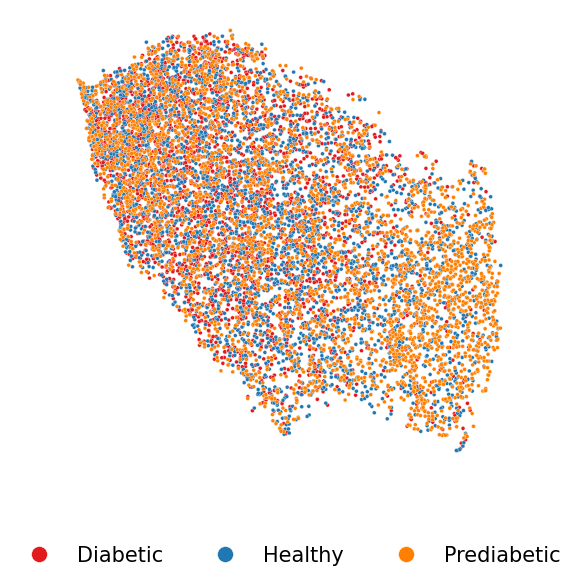

In [305]:
control_palette = [paired_palette[5],paired_palette[1],paired_palette[7]]

considered_cell_ids_1 = embedding_control_bal_view['balanced_sample'] !=0
embedding_control_bal_view_good_cells = embedding_control_bal_view[considered_cell_ids_1]
embedding_control_bal_view_good_cells

fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=embedding_control_bal_view_good_cells,x=0,y=1,s=8,hue="disease",palette=control_palette)
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.12),  # center horizontally, drop below axes
    ncol=4,                       # spread the handles in one row
    frameon=False,                # optional styling
    title='',                # optional label
    markerscale=4, 
    fontsize = 15
)
sns.despine(left=True, bottom=True)
plt.xticks([], [])
plt.yticks([], [])
plt.xlabel('')
plt.ylabel('')
plt.show()


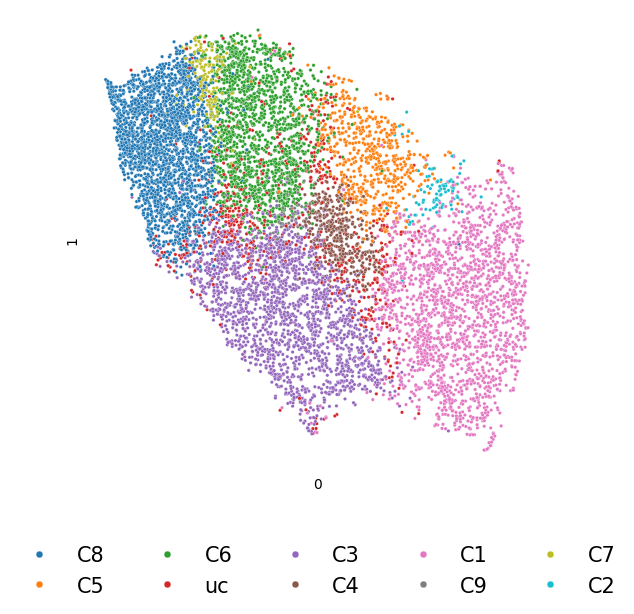

In [307]:
control_palette = [paired_palette[5],paired_palette[1],paired_palette[7]]

considered_cell_ids_1 = embedding_control_bal_view['balanced_sample'] !=0
considered_cell_ids_2 =  embedding_control_bal_view['label_leiden'].notna()
condidered_cell_ids = considered_cell_ids_2 & considered_cell_ids_1
embedding_control_bal_view_good_cells = embedding_control_bal_view[condidered_cell_ids]
embedding_control_bal_view_good_cells
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=embedding_control_bal_view_good_cells,x=0,y=1,s=6,hue="label_leiden",palette='tab10')

plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.12),  # center horizontally, drop below axes
    ncol=5,                       # spread the handles in one row
    frameon=False,                # optional styling
    title='',                # optional label
    markerscale=2,
    fontsize = 15
)
sns.despine(left=True, bottom=True)
plt.xticks([], [])
plt.yticks([], [])
plt.show()

In [308]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=embedding_control_bal_view_good_cells,x=0,y=1,s=8,hue="label_leiden",palette='tab10')

plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.12),  # center horizontally, drop below axes
    ncol=5,                       # spread the handles in one row
    frameon=False,                # optional styling
    title='',                # optional label
    markerscale=3
)
sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.ylabel('')
plt.xticks([], [])
plt.yticks([], [])
plt.show()


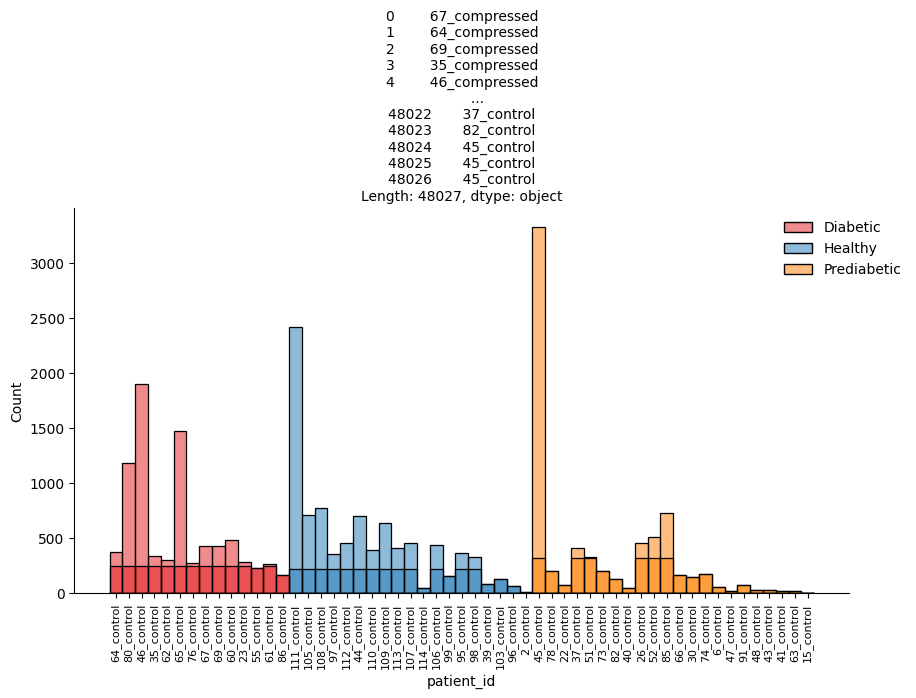

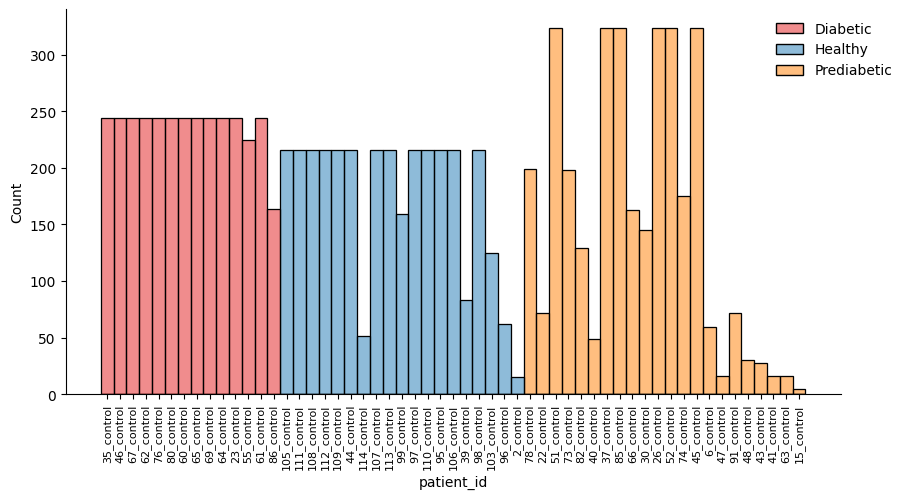

In [237]:
custom_paired_palette={
'Healthy': paired_palette[1],
'Diabetic':paired_palette[5],
'Prediabetic': paired_palette[7],  
}


for_plots=latent_list_df_lab_control[latent_list_df_lab_control['balanced_sample']==1]
fig,ax=plt.subplots(figsize=(10,5))
sns.histplot(latent_list_df_lab_control,x='patient_id',hue='disease',palette=custom_paired_palette)
sns.histplot(for_plots,x='patient_id',hue='disease',palette=custom_paired_palette)
sns.move_legend(ax,"upper left",bbox_to_anchor=(0.9,1),title=None,frameon=False,)
plt.xticks(rotation=90,fontsize=8)
sns.despine() 
plt.title(patient_id, fontsize=10)
plt.show()


fig,ax=plt.subplots(figsize=(10,5))
sns.histplot(for_plots,x='patient_id',hue='disease',palette=custom_paired_palette)
sns.move_legend(ax,"upper left",bbox_to_anchor=(0.9,1),title=None,frameon=False,)
plt.xticks(rotation=90,fontsize=8)
sns.despine() 
plt.show()




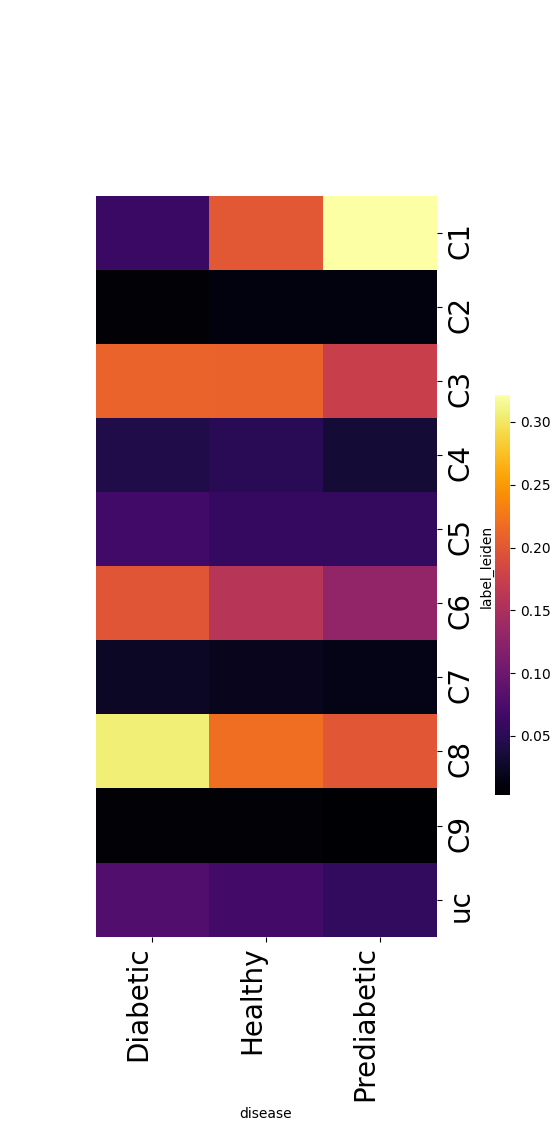

In [277]:
embedding_control_bal_view_good_cells

cluster_enrichement = embedding_control_bal_view_good_cells.groupby(['label_leiden','disease']).count()[0].reset_index().pivot(index='label_leiden',columns='disease',values=0)
cluster_enrichement_patho = cluster_enrichement/cluster_enrichement.sum(axis=0)
cluster_enrichement_patho
g = sns.clustermap(cluster_enrichement_patho,figsize=(5,10),row_cluster= False,col_cluster =  False,cmap='inferno',cbar_pos=(1, 0.2, 0.03, 0.4))
g.ax_heatmap.set_xticklabels(
    g.ax_heatmap.get_xticklabels(),
    rotation=90, ha="right",
    fontsize=20  # set your desired size
)
g.ax_heatmap.set_yticklabels(
    g.ax_heatmap.get_yticklabels(),
    fontsize=20
)

plt.show()

<Figure size 1000x500 with 0 Axes>

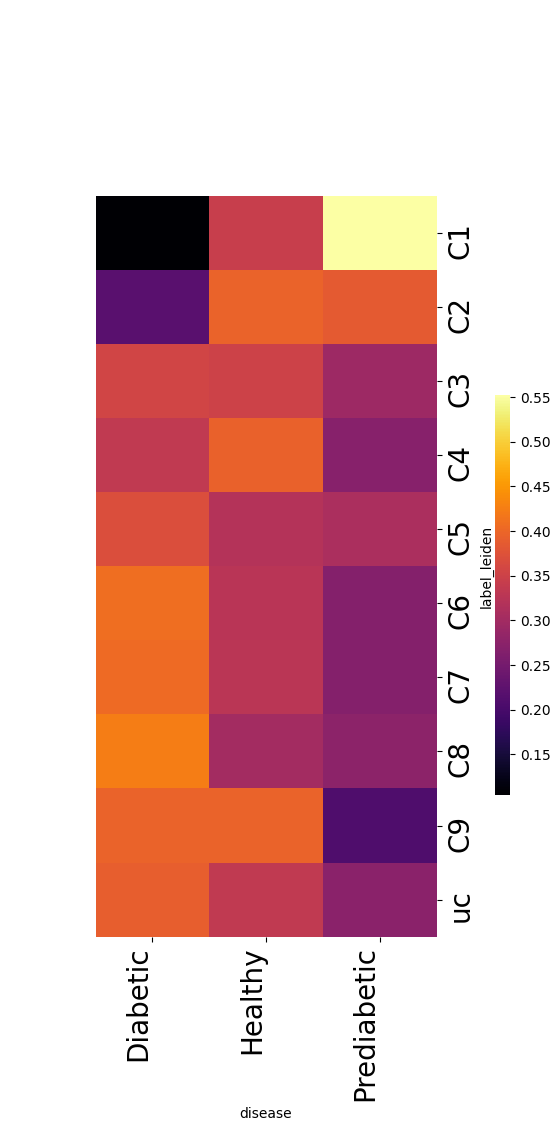

In [279]:
embedding_control_bal_view_good_cells

cluster_enrichement = embedding_control_bal_view_good_cells.groupby(['label_leiden','disease']).count()[0].reset_index().pivot(index='label_leiden',columns='disease',values=0)
cluster_enrichement_patho = cluster_enrichement.div(cluster_enrichement.sum(axis=1), axis=0)
cluster_enrichement_patho
plt.figure(figsize=(10, 5))
g = sns.clustermap(cluster_enrichement_patho,figsize=(5,10),row_cluster = False,col_cluster =  False,cmap='inferno',cbar_pos=(1, 0.2, 0.03, 0.4))
plt.xticks(fonstsize = 15)
g.ax_heatmap.set_xticklabels(
    g.ax_heatmap.get_xticklabels(),
    rotation=90, ha="right",
    fontsize=20  # set your desired size
)
g.ax_heatmap.set_yticklabels(
    g.ax_heatmap.get_yticklabels(),
    fontsize=20
)

plt.show()

In [244]:
embedding_control_df_balanced_enrichement = embedding_control_bal_view_good_cells.groupby(['label_leiden','patient_id']).count()[0].reset_index().pivot(index='label_leiden',columns='patient_id',values=0)
embedding_control_df_balanced_labels = embedding_control_bal_view_good_cells.groupby(['patient_id','disease']).count()[0].reset_index()
embedding_control_df_balanced_labels = embedding_control_df_balanced_labels[['patient_id','disease']]
embedding_control_df_balanced_enrichement_cluster = embedding_control_df_balanced_enrichement.replace(np.nan,0)/embedding_control_df_balanced_enrichement.sum(axis=0)
embedding_control_df_balanced_enrichement_cluster

embedding_control_df_balanced_enrichement_cluster_transpose = embedding_control_df_balanced_enrichement_cluster.T.reset_index()
embedding_control_df_balanced_enrichement_cluster_transpose
embedding_control_df_balanced_enrichement['disease'] = embedding_control_df_balanced_labels['disease']
embedding_control_df_balanced_enrichement_cluster_transpose = embedding_control_df_balanced_enrichement_cluster_transpose.merge(embedding_control_df_balanced_labels,on='patient_id',how='left')
embedding_control_df_balanced_enrichement_cluster_transpose
patients_to_filter = ['6_control', '48_control', '43_control', '47_control', '91_control', '41_control' ,'40_control', '63_control', '15_control', '22_control', '96_control','39_control', '114_control', '2_control', '39_control']
embedding_control_df_balanced_enrichement_cluster_transpose_filt = embedding_control_df_balanced_enrichement_cluster_transpose[~embedding_control_df_balanced_enrichement_cluster_transpose['patient_id'].isin(patients_to_filter)]
embedding_control_df_balanced_enrichement_cluster_transpose_filt

patient_id        C1        C2        C3        C4        C5        C6  \
0   103_control  0.152000  0.000000  0.384000  0.008000  0.032000  0.096000   
1   105_control  0.504630  0.037037  0.120370  0.032407  0.055556  0.101852   
2   106_control  0.115741  0.000000  0.240741  0.064815  0.083333  0.162037   
3   107_control  0.120370  0.013889  0.171296  0.101852  0.092593  0.143519   
4   108_control  0.476852  0.009259  0.148148  0.027778  0.050926  0.134259   
5   109_control  0.087963  0.009259  0.185185  0.037037  0.037037  0.171296   
6   110_control  0.018519  0.018519  0.226852  0.046296  0.064815  0.277778   
7   111_control  0.074074  0.009259  0.277778  0.078704  0.069444  0.212963   
8   112_control  0.050926  0.013889  0.291667  0.087963  0.060185  0.208333   
9   113_control  0.351852  0.009259  0.203704  0.055556  0.060185  0.087963   
13   23_control  0.065574  0.020492  0.209016  0.012295  0.081967  0.180328   
14   26_control  0.203704  0.018519  0.212963  0.037037  0.033951  0.148148   
16   30_control  0.351724  0.013793  0.151724  0.013793  0.062069  0.200000   
17   35_control  0.057377  0.000000  0.127049  0.032787  0.057377  0.196721   
18   37_control  0.280864  0.018519  0.194444  0.027778  0.070988  0.098765   
23   44_control  0.500000  0.027778  0.180556  0.013889  0.050926  0.074074   
24   45_control  0.629630  0.012346  0.145062  0.040123  0.043210  0.040123   
25   46_control  0.114754  0.008197  0.307377  0.098361  0.127049  0.143443   
28   51_control  0.635802  0.012346  0.123457  0.033951  0.049383  0.043210   
29   52_control  0.425926  0.015432  0.138889  0.018519  0.058642  0.141975   
30   55_control  0.004444  0.004444  0.155556  0.008889  0.026667  0.195556   
31   60_control  0.065574  0.004098  0.286885  0.045082  0.077869  0.192623   
32   61_control  0.008197  0.000000  0.118852  0.032787  0.016393  0.176230   
33   62_control  0.016393  0.000000  0.254098  0.036885  0.049180  0.245902   
35   64_control  0.016393  0.000000  0.163934  0.012295  0.028689  0.221311   
36   65_control  0.053279  0.012295  0.196721  0.061475  0.061475  0.237705   
37   66_control  0.042945  0.006135  0.257669  0.018405  0.085890  0.165644   
38   67_control  0.057377  0.008197  0.286885  0.032787  0.069672  0.258197   
39   69_control  0.131148  0.016393  0.274590  0.020492  0.069672  0.188525   
41   73_control  0.030303  0.000000  0.161616  0.025253  0.025253  0.252525   
42   74_control  0.474286  0.022857  0.205714  0.022857  0.045714  0.080000   
43   76_control  0.118852  0.004098  0.196721  0.053279  0.090164  0.147541   
44   78_control  0.075377  0.005025  0.130653  0.045226  0.050251  0.195980   
45   80_control  0.110656  0.008197  0.217213  0.106557  0.131148  0.180328   
46   82_control  0.496124  0.000000  0.147287  0.015504  0.093023  0.131783   
47   85_control  0.154321  0.006173  0.157407  0.067901  0.070988  0.157407   
48   86_control  0.012195  0.000000  0.103659  0.030488  0.048780  0.207317   
50   95_control  0.101852  0.004630  0.175926  0.018519  0.032407  0.222222   
52   97_control  0.111111  0.018519  0.273148  0.120370  0.120370  0.166667   
53   98_control  0.032407  0.004630  0.152778  0.013889  0.032407  0.203704   
54   99_control  0.352201  0.000000  0.163522  0.031447  0.037736  0.119497   

          C7        C8        C9        uc      disease  
0   0.032000  0.272000  0.000000  0.024000      Healthy  
1   0.004630  0.074074  0.009259  0.060185      Healthy  
2   0.037037  0.245370  0.000000  0.050926      Healthy  
3   0.018519  0.231481  0.000000  0.106481      Healthy  
4   0.009259  0.097222  0.000000  0.046296      Healthy  
5   0.018519  0.347222  0.004630  0.101852      Healthy  
6   0.009259  0.226852  0.004630  0.106481      Healthy  
7   0.004630  0.162037  0.018519  0.092593      Healthy  
8   0.009259  0.166667  0.018519  0.092593      Healthy  
9   0.018519  0.129630  0.004630  0.078704      Healthy  
13  0.020492  0.336066  0.000000  0.073770     D

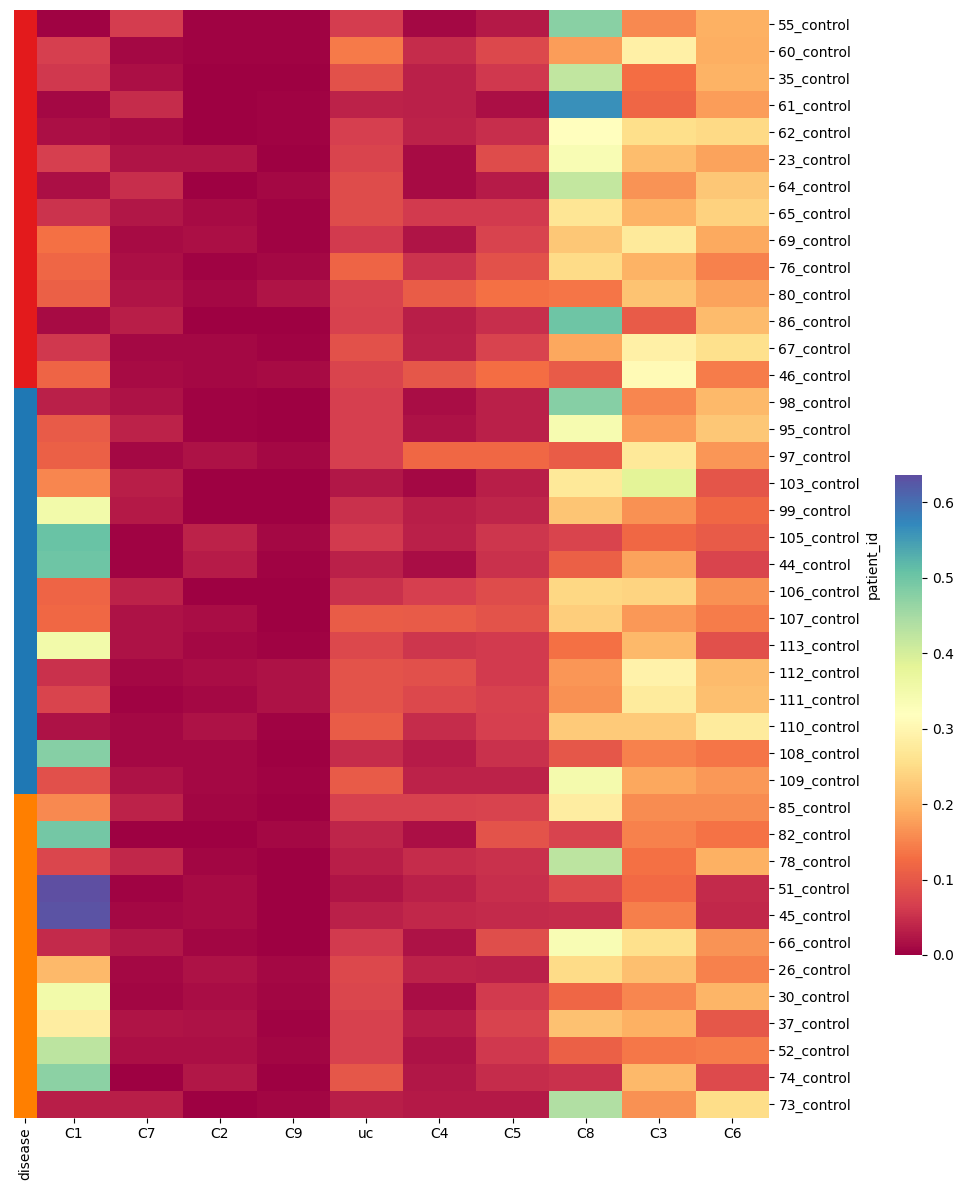

In [245]:
label_to_color = {
    'Diabetic': paired_palette[5],
    'Prediabetic': paired_palette[7],
    'Healthy': paired_palette[1],
}

labels = embedding_control_df_balanced_enrichement_cluster_transpose_filt['disease']
order = labels.sort_values().index

data_ordered = embedding_control_df_balanced_enrichement_cluster_transpose_filt.loc[order]
data_ordered.index = data_ordered['patient_id']

row_colors = data_ordered['disease'].map(label_to_color)

g = sns.clustermap(
    data_ordered.drop(columns=['disease', 'patient_id']),
    row_cluster=False,
    row_colors=row_colors,
    dendrogram_ratio=(0.005, 0.0001),
    figsize=(9, 12),
    cmap='Spectral',
    cbar_pos=(1, 0.2, 0.03, 0.4),
)
plt.title('')
plt.show()

In [246]:
len(data_ordered)
np.unique(row_colors)

array([(0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
       (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
       (1.0, 0.4980392156862745, 0.0)], dtype=object)

In [247]:
count_pat_id = embedding_control_bal_view_good_cells.groupby('patient_id').count()[0].reset_index()
count_pat_id_qualified = count_pat_id[count_pat_id[0]>100]
print(len(count_pat_id_qualified['patient_id'].tolist()))
count_pat_id_qualified['patient_id'].tolist()

#embedding_control_df_balanced_enrichement.replace(np.nan,0)

41


['103_control',
 '105_control',
 '106_control',
 '107_control',
 '108_control',
 '109_control',
 '110_control',
 '111_control',
 '112_control',
 '113_control',
 '23_control',
 '26_control',
 '30_control',
 '35_control',
 '37_control',
 '44_control',
 '45_control',
 '46_control',
 '51_control',
 '52_control',
 '55_control',
 '60_control',
 '61_control',
 '62_control',
 '64_control',
 '65_control',
 '66_control',
 '67_control',
 '69_control',
 '73_control',
 '74_control',
 '76_control',
 '78_control',
 '80_control',
 '82_control',
 '85_control',
 '86_control',
 '95_control',
 '97_control',
 '98_control',
 '99_control']

In [248]:
import igraph as ig
import leidenalg as la
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report, ConfusionMatrixDisplay

def random_forest_classifier_leave_one_out(train,test,columns_drop,column_test):
    
    X_train=train.drop(columns_drop,axis=1)
    y_train=train[column_test]

    X_test=test.drop(columns_drop,axis=1)
    y_test=test[column_test]

#    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    # SMOTE
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X_train, y_train)


    rf_clf = RandomForestClassifier(n_estimators=300,max_features=20, random_state=42)
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(rf_clf, X_train, y_train, cv=kfold, scoring='accuracy')
    cv_predictions = cross_val_predict(rf_clf, X_train, y_train, cv=kfold)

    rf_clf.fit(X_train, y_train)
    y_pred = rf_clf.predict(X_test)
    global_importances = pd.Series(rf_clf.feature_importances_, index=X_train.columns)
    global_importances.sort_values(ascending=True, inplace=True)
    global_importances.plot.barh(color='green')
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title("Global Feature Importance - Built-in Method")
    
    return(y_pred)

/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-lea

['Diabetic' 'Healthy' 'Prediabetic']


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-lea

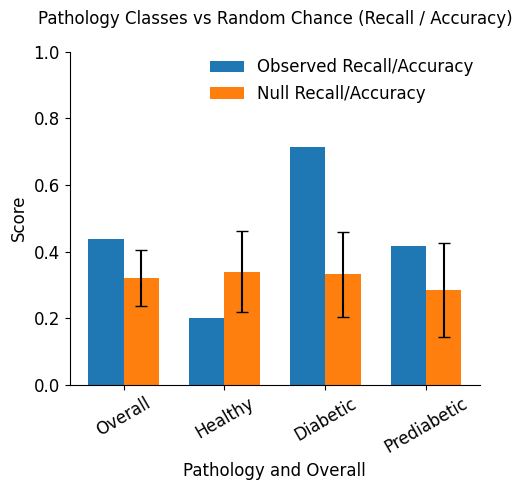

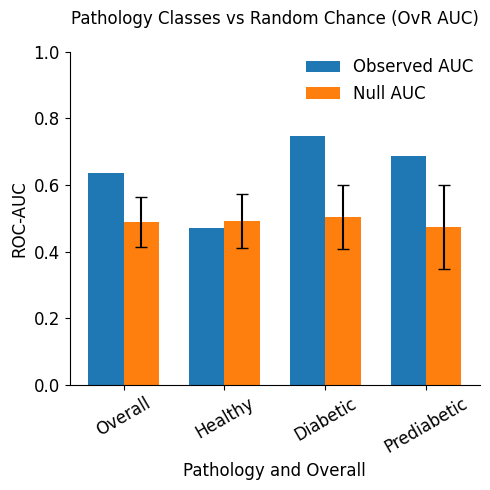

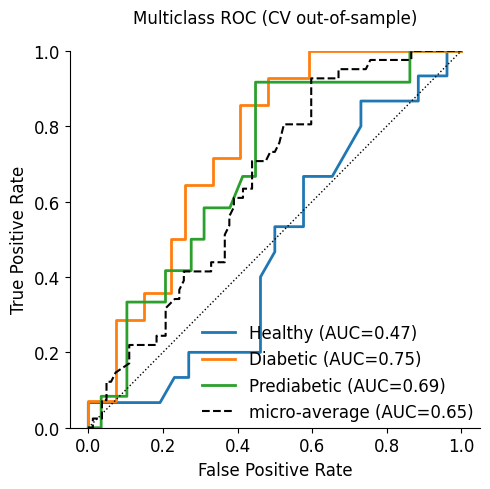

In [249]:
embedding_control_df_balanced_enrichement_cluster_transpose_filt
results, y_true, y_pred, y_proba, classes = global_cv_vs_permutation_null_by_class(
    df=embedding_control_df_balanced_enrichement_cluster_transpose_filt,
    target='disease',
    drop_cols=['patient_id','disease'],
    class_labels=["Healthy","Diabetic","Prediabetic"],
    cv_splits=5,
    n_permutations=50,
    random_state=42
)

plot_cv_vs_null_by_class(results, ["Healthy","Diabetic","Prediabetic"],title="Pathology Classes vs Random Chance")

plot_multiclass_roc_from_cv(y_true, y_proba, classes)

 

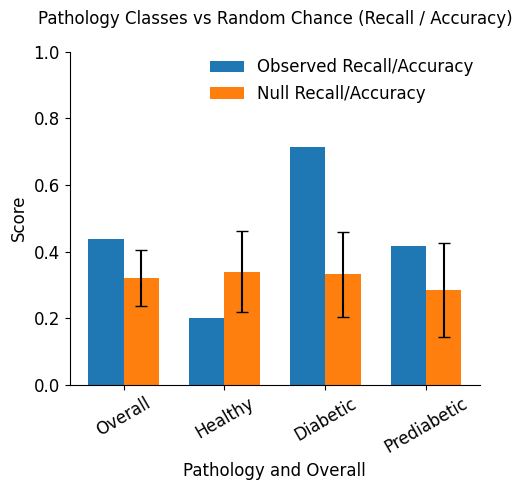

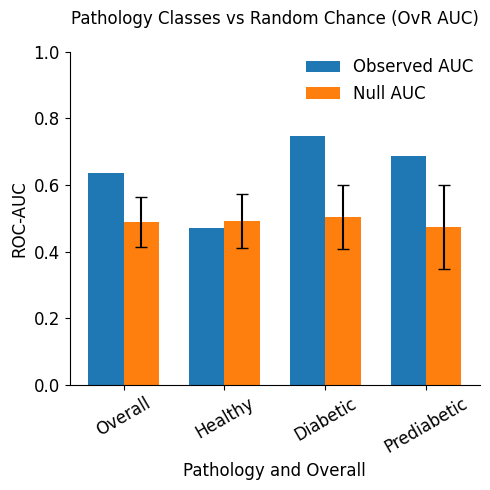

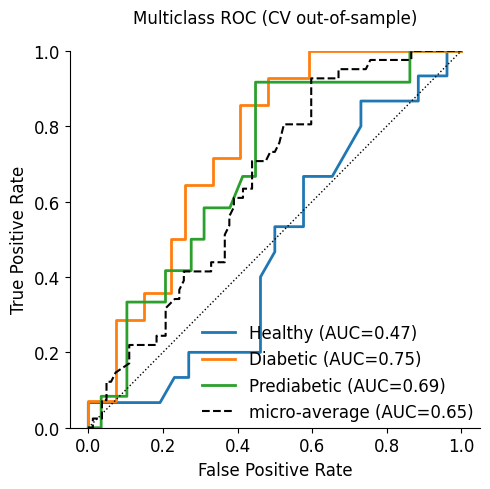

In [250]:
plot_cv_vs_null_by_class(results, ["Healthy","Diabetic","Prediabetic"],title="Pathology Classes vs Random Chance")

plot_multiclass_roc_from_cv(y_true, y_proba, classes)



103_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


105_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


106_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


107_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


108_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


109_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


110_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


111_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


112_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


113_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


23_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


26_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


30_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


35_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


37_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


44_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


45_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


46_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


51_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


52_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


55_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


60_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


61_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


62_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


64_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


65_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


66_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


67_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


69_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


73_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


74_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


76_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


78_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


80_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


82_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


85_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


86_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


95_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


97_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


98_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


99_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


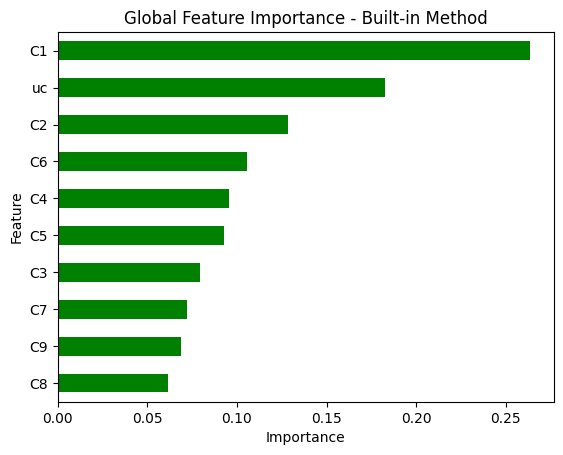

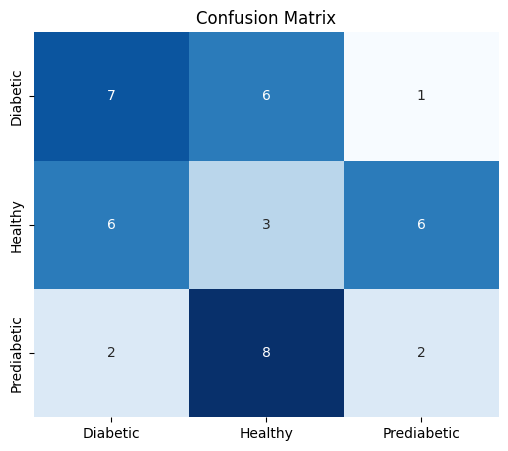

In [251]:
true_label_mat=[]
pid_pred_mat=[]
patient_id_mat = []
for patient_id in embedding_control_df_balanced_enrichement_cluster_transpose_filt['patient_id'].unique():
    print(patient_id)
    this_patient_enrichement =  embedding_control_df_balanced_enrichement_cluster_transpose_filt[embedding_control_df_balanced_enrichement_cluster_transpose_filt['patient_id']==patient_id]
    other_patients_enrichement = embedding_control_df_balanced_enrichement_cluster_transpose_filt[embedding_control_df_balanced_enrichement_cluster_transpose_filt['patient_id']!=patient_id]
    [pid_pred]=random_forest_classifier_leave_one_out(other_patients_enrichement,this_patient_enrichement,['patient_id','disease'],'disease')

    patient_id_mat.append(patient_id)
    true_label_mat.append(this_patient_enrichement['disease'].tolist())    
    pid_pred_mat.append(pid_pred)

from sklearn.metrics import confusion_matrix
import pandas as pd
confusion_matrix = confusion_matrix(true_label_mat, pid_pred_mat)
confusion_matrix_df = pd.DataFrame(confusion_matrix, index=['Diabetic','Healthy', 'Prediabetic'], columns=['Diabetic','Healthy',  'Prediabetic'])
confusion_matrix_df
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.show()


In [252]:

true_vs_pred = pd.DataFrame({'patient_id': patient_id_mat, 'prediction': pid_pred_mat,'disease': true_label_mat})
true_vs_pred
true_vs_pred["disease"] = true_vs_pred["disease"].apply(
    lambda x: x[0] if isinstance(x, (list, tuple)) else x
)
true_vs_pred

patient_id   prediction      disease
0   103_control  Prediabetic      Healthy
1   105_control  Prediabetic      Healthy
2   106_control  Prediabetic      Healthy
3   107_control     Diabetic      Healthy
4   108_control  Prediabetic      Healthy
5   109_control     Diabetic      Healthy
6   110_control     Diabetic      Healthy
7   111_control     Diabetic      Healthy
8   112_control      Healthy      Healthy
9   113_control  Prediabetic      Healthy
10   23_control      Healthy     Diabetic
11   26_control      Healthy  Prediabetic
12   30_control      Healthy  Prediabetic
13   35_control     Diabetic     Diabetic
14   37_control      Healthy  Prediabetic
15   44_control  Prediabetic      Healthy
16   45_control  Prediabetic  Prediabetic
17   46_control      Healthy     Diabetic
18   51_control      Healthy  Prediabetic
19   52_control  Prediabetic  Prediabetic
20   55_control     Diabetic     Diabetic
21   60_control     Diabetic     Diabetic
22   61_control  Prediabetic     Diabetic
23   62_control     Diabetic     Diabetic
24   64_control     Diabetic     Diabetic
25   65_control      Healthy     Diabetic
26   66_control     Diabetic  Prediabetic
27   67_control     Diabetic     Diabetic
28   69_control      Healthy     Diabetic
29   73_control     Diabetic  Prediabetic
30   74_control      Healthy  Prediabetic
31   76_control      Healthy     Diabetic
32   78_control      Healthy  Prediabetic
33   80_control      Healthy     Diabetic
34   82_control      Healthy  Prediabetic
35   85_control      Healthy  Prediabetic
36   86_control     Diabetic     Diabetic
37   95_control      Healthy      Healthy
38   97_control     Diabetic      Healthy
39   98_control     Diabetic      Healthy
40   99_control      Healthy      Healthy

In [253]:
pd_ht_map = embedding_control_df_balanced_enrichement_cluster_transpose_filt.merge(true_vs_pred, on =['patient_id','disease'])
pd_ht_map

patient_id        C1        C2        C3        C4        C5        C6  \
0   103_control  0.152000  0.000000  0.384000  0.008000  0.032000  0.096000   
1   105_control  0.504630  0.037037  0.120370  0.032407  0.055556  0.101852   
2   106_control  0.115741  0.000000  0.240741  0.064815  0.083333  0.162037   
3   107_control  0.120370  0.013889  0.171296  0.101852  0.092593  0.143519   
4   108_control  0.476852  0.009259  0.148148  0.027778  0.050926  0.134259   
5   109_control  0.087963  0.009259  0.185185  0.037037  0.037037  0.171296   
6   110_control  0.018519  0.018519  0.226852  0.046296  0.064815  0.277778   
7   111_control  0.074074  0.009259  0.277778  0.078704  0.069444  0.212963   
8   112_control  0.050926  0.013889  0.291667  0.087963  0.060185  0.208333   
9   113_control  0.351852  0.009259  0.203704  0.055556  0.060185  0.087963   
10   23_control  0.065574  0.020492  0.209016  0.012295  0.081967  0.180328   
11   26_control  0.203704  0.018519  0.212963  0.037037  0.033951  0.148148   
12   30_control  0.351724  0.013793  0.151724  0.013793  0.062069  0.200000   
13   35_control  0.057377  0.000000  0.127049  0.032787  0.057377  0.196721   
14   37_control  0.280864  0.018519  0.194444  0.027778  0.070988  0.098765   
15   44_control  0.500000  0.027778  0.180556  0.013889  0.050926  0.074074   
16   45_control  0.629630  0.012346  0.145062  0.040123  0.043210  0.040123   
17   46_control  0.114754  0.008197  0.307377  0.098361  0.127049  0.143443   
18   51_control  0.635802  0.012346  0.123457  0.033951  0.049383  0.043210   
19   52_control  0.425926  0.015432  0.138889  0.018519  0.058642  0.141975   
20   55_control  0.004444  0.004444  0.155556  0.008889  0.026667  0.195556   
21   60_control  0.065574  0.004098  0.286885  0.045082  0.077869  0.192623   
22   61_control  0.008197  0.000000  0.118852  0.032787  0.016393  0.176230   
23   62_control  0.016393  0.000000  0.254098  0.036885  0.049180  0.245902   
24   64_control  0.016393  0.000000  0.163934  0.012295  0.028689  0.221311   
25   65_control  0.053279  0.012295  0.196721  0.061475  0.061475  0.237705   
26   66_control  0.042945  0.006135  0.257669  0.018405  0.085890  0.165644   
27   67_control  0.057377  0.008197  0.286885  0.032787  0.069672  0.258197   
28   69_control  0.131148  0.016393  0.274590  0.020492  0.069672  0.188525   
29   73_control  0.030303  0.000000  0.161616  0.025253  0.025253  0.252525   
30   74_control  0.474286  0.022857  0.205714  0.022857  0.045714  0.080000   
31   76_control  0.118852  0.004098  0.196721  0.053279  0.090164  0.147541   
32   78_control  0.075377  0.005025  0.130653  0.045226  0.050251  0.195980   
33   80_control  0.110656  0.008197  0.217213  0.106557  0.131148  0.180328   
34   82_control  0.496124  0.000000  0.147287  0.015504  0.093023  0.131783   
35   85_control  0.154321  0.006173  0.157407  0.067901  0.070988  0.157407   
36   86_control  0.012195  0.000000  0.103659  0.030488  0.048780  0.207317   
37   95_control  0.101852  0.004630  0.175926  0.018519  0.032407  0.222222   
38   97_control  0.111111  0.018519  0.273148  0.120370  0.120370  0.166667   
39   98_control  0.032407  0.004630  0.152778  0.013889  0.032407  0.203704   
40   99_control  0.352201  0.000000  0.163522  0.031447  0.037736  0.119497   

          C7        C8        C9        uc      disease   prediction  
0   0.032000  0.272000  0.000000  0.024000      Healthy  Prediabetic  
1   0.004630  0.074074  0.009259  0.060185      Healthy  Prediabetic  
2   0.037037  0.245370  0.000000  0.050926      Healthy  Prediabetic  
3   0.018519  0.231481  0.000000  0.106481      Healthy     Diabetic  
4   0.009259  0.097222  0.000000  0.046296      Healthy  Prediabetic  
5   0.018519  0.347222  0.004630  0.101852      Healthy     Diabetic  
6   0.009259  0.226852  0.004630  0.106481      Healthy     Diabetic  
7   0.004630  0.162037  0.018519  0.092593      Healthy     Diabetic  
8   0.009259  0.166667  0.018519  0.092593     

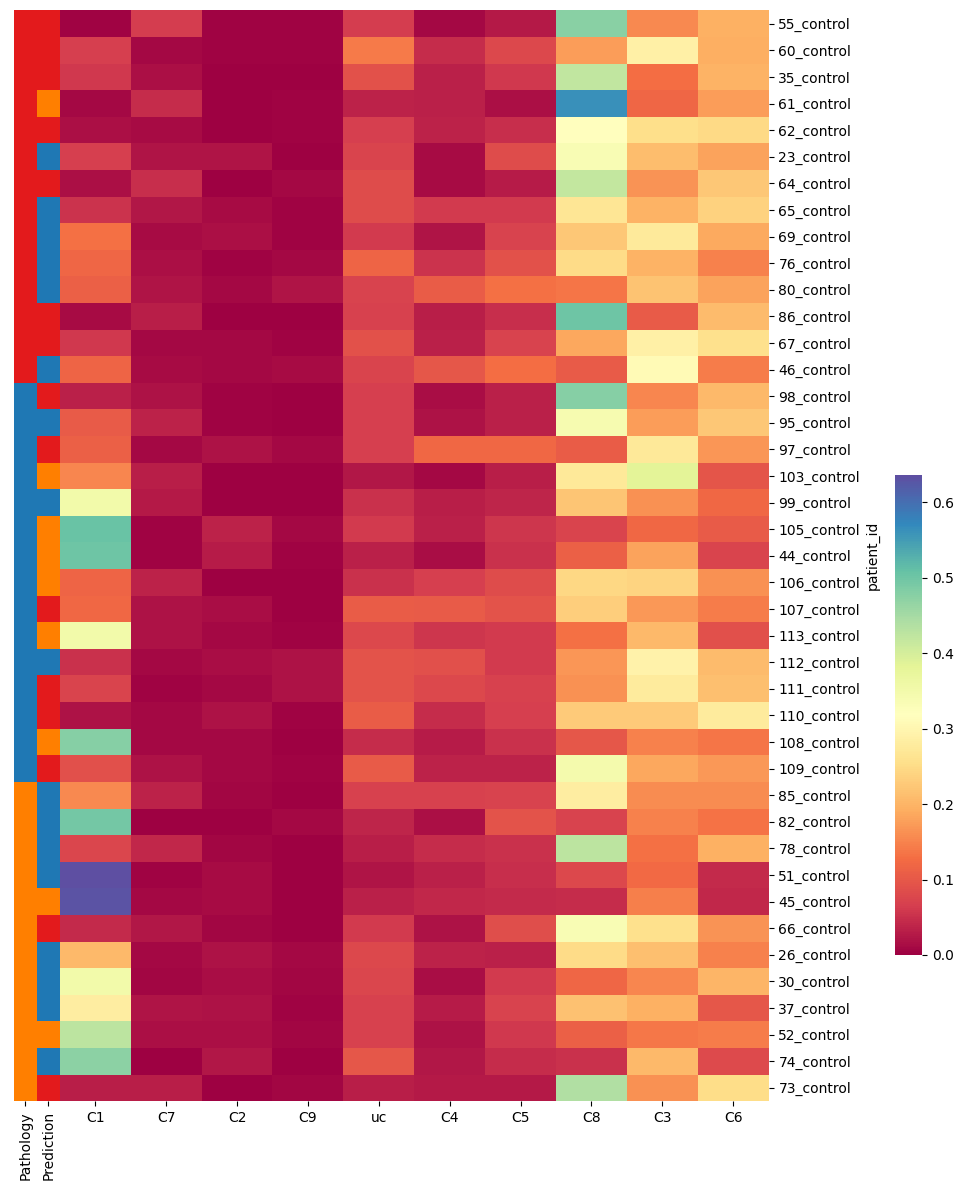

In [ ]:
true_vs_pred = pd.DataFrame({'patient_id': patient_id_mat, 'prediction': pid_pred_mat,'disease': true_label_mat})
true_vs_pred
true_vs_pred["disease"] = true_vs_pred["disease"].apply(
    lambda x: x[0] if isinstance(x, (list, tuple)) else x
)
true_vs_pred

pd_ht_map = embedding_control_df_balanced_enrichement_cluster_transpose_filt.merge(true_vs_pred, on =['patient_id','disease'])
label_to_color = {
    'Diabetic': paired_palette[5],
    'Prediabetic': paired_palette[7],
    'Healthy': paired_palette[1],
}

labels = pd_ht_map['disease']
order = labels.sort_values().index

data_ordered = pd_ht_map.loc[order]
data_ordered.index = data_ordered['patient_id']

row_colors = data_ordered['disease'].map(label_to_color),data_ordered['prediction'].map(label_to_color)
row_colors = pd.DataFrame({
    "Pathology": data_ordered["disease"].map(label_to_color),
    "Prediction": data_ordered["prediction"].map(label_to_color),
}, index=data_ordered.index)
g = sns.clustermap(
    data_ordered.drop(columns=['disease', 'patient_id','prediction']),
    row_cluster=False,
    row_colors=row_colors,
    dendrogram_ratio=(0.005, 0.0001),
    figsize=(9, 12),
    cmap='Spectral',
    cbar_pos=(1, 0.2, 0.03, 0.4),
)

plt.title('')
plt.show()


In [255]:
embedding_control_df_balanced_enrichement_cluster_transpose_filt

patient_id        C1        C2        C3        C4        C5        C6  \
0   103_control  0.152000  0.000000  0.384000  0.008000  0.032000  0.096000   
1   105_control  0.504630  0.037037  0.120370  0.032407  0.055556  0.101852   
2   106_control  0.115741  0.000000  0.240741  0.064815  0.083333  0.162037   
3   107_control  0.120370  0.013889  0.171296  0.101852  0.092593  0.143519   
4   108_control  0.476852  0.009259  0.148148  0.027778  0.050926  0.134259   
5   109_control  0.087963  0.009259  0.185185  0.037037  0.037037  0.171296   
6   110_control  0.018519  0.018519  0.226852  0.046296  0.064815  0.277778   
7   111_control  0.074074  0.009259  0.277778  0.078704  0.069444  0.212963   
8   112_control  0.050926  0.013889  0.291667  0.087963  0.060185  0.208333   
9   113_control  0.351852  0.009259  0.203704  0.055556  0.060185  0.087963   
13   23_control  0.065574  0.020492  0.209016  0.012295  0.081967  0.180328   
14   26_control  0.203704  0.018519  0.212963  0.037037  0.033951  0.148148   
16   30_control  0.351724  0.013793  0.151724  0.013793  0.062069  0.200000   
17   35_control  0.057377  0.000000  0.127049  0.032787  0.057377  0.196721   
18   37_control  0.280864  0.018519  0.194444  0.027778  0.070988  0.098765   
23   44_control  0.500000  0.027778  0.180556  0.013889  0.050926  0.074074   
24   45_control  0.629630  0.012346  0.145062  0.040123  0.043210  0.040123   
25   46_control  0.114754  0.008197  0.307377  0.098361  0.127049  0.143443   
28   51_control  0.635802  0.012346  0.123457  0.033951  0.049383  0.043210   
29   52_control  0.425926  0.015432  0.138889  0.018519  0.058642  0.141975   
30   55_control  0.004444  0.004444  0.155556  0.008889  0.026667  0.195556   
31   60_control  0.065574  0.004098  0.286885  0.045082  0.077869  0.192623   
32   61_control  0.008197  0.000000  0.118852  0.032787  0.016393  0.176230   
33   62_control  0.016393  0.000000  0.254098  0.036885  0.049180  0.245902   
35   64_control  0.016393  0.000000  0.163934  0.012295  0.028689  0.221311   
36   65_control  0.053279  0.012295  0.196721  0.061475  0.061475  0.237705   
37   66_control  0.042945  0.006135  0.257669  0.018405  0.085890  0.165644   
38   67_control  0.057377  0.008197  0.286885  0.032787  0.069672  0.258197   
39   69_control  0.131148  0.016393  0.274590  0.020492  0.069672  0.188525   
41   73_control  0.030303  0.000000  0.161616  0.025253  0.025253  0.252525   
42   74_control  0.474286  0.022857  0.205714  0.022857  0.045714  0.080000   
43   76_control  0.118852  0.004098  0.196721  0.053279  0.090164  0.147541   
44   78_control  0.075377  0.005025  0.130653  0.045226  0.050251  0.195980   
45   80_control  0.110656  0.008197  0.217213  0.106557  0.131148  0.180328   
46   82_control  0.496124  0.000000  0.147287  0.015504  0.093023  0.131783   
47   85_control  0.154321  0.006173  0.157407  0.067901  0.070988  0.157407   
48   86_control  0.012195  0.000000  0.103659  0.030488  0.048780  0.207317   
50   95_control  0.101852  0.004630  0.175926  0.018519  0.032407  0.222222   
52   97_control  0.111111  0.018519  0.273148  0.120370  0.120370  0.166667   
53   98_control  0.032407  0.004630  0.152778  0.013889  0.032407  0.203704   
54   99_control  0.352201  0.000000  0.163522  0.031447  0.037736  0.119497   

          C7        C8        C9        uc      disease  
0   0.032000  0.272000  0.000000  0.024000      Healthy  
1   0.004630  0.074074  0.009259  0.060185      Healthy  
2   0.037037  0.245370  0.000000  0.050926      Healthy  
3   0.018519  0.231481  0.000000  0.106481      Healthy  
4   0.009259  0.097222  0.000000  0.046296      Healthy  
5   0.018519  0.347222  0.004630  0.101852      Healthy  
6   0.009259  0.226852  0.004630  0.106481      Healthy  
7   0.004630  0.162037  0.018519  0.092593      Healthy  
8   0.009259  0.166667  0.018519  0.092593      Healthy  
9   0.018519  0.129630  0.004630  0.078704      Healthy  
13  0.020492  0.336066  0.000000  0.073770     D

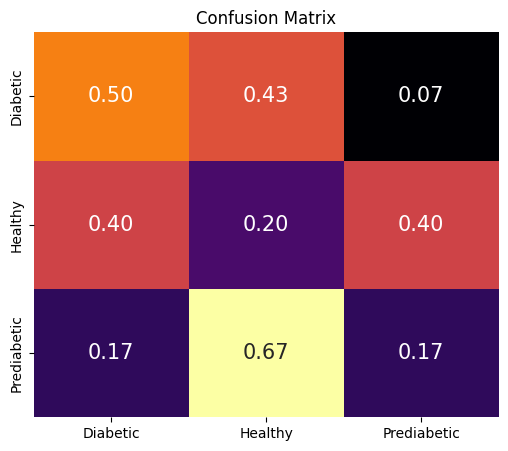

In [256]:
from sklearn.metrics import confusion_matrix
import pandas as pd
confusion_matrix = confusion_matrix(true_label_mat, pid_pred_mat,normalize= "true")
confusion_matrix_df = pd.DataFrame(confusion_matrix, index=['Diabetic','Healthy', 'Prediabetic'], columns=['Diabetic','Healthy',  'Prediabetic'])
confusion_matrix_df
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix_df, annot=True, fmt='.2f', cmap='inferno', cbar=False,annot_kws={"fontsize": 15} )
plt.title('Confusion Matrix')
plt.show()

23_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Diabetic
Diabetic
26_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Prediabetic
Prediabetic
30_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Prediabetic
Prediabetic
35_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Diabetic
Diabetic
37_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Prediabetic
Prediabetic
45_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Prediabetic
Prediabetic
46_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Diabetic
Diabetic
51_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Prediabetic
Prediabetic
52_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Prediabetic
Prediabetic
55_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Diabetic
Diabetic
60_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Diabetic
Diabetic
61_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Diabetic
Prediabetic
62_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Diabetic
Diabetic
64_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Diabetic
Diabetic
65_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Diabetic
Diabetic
66_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Prediabetic
Diabetic
67_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Diabetic
Diabetic
69_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Diabetic
Prediabetic
73_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Prediabetic
Prediabetic
74_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Prediabetic
Prediabetic
76_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Diabetic
Diabetic
78_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Prediabetic
Prediabetic
80_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Diabetic
Diabetic
82_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Prediabetic
Prediabetic
85_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Prediabetic
Diabetic
86_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Diabetic
Diabetic


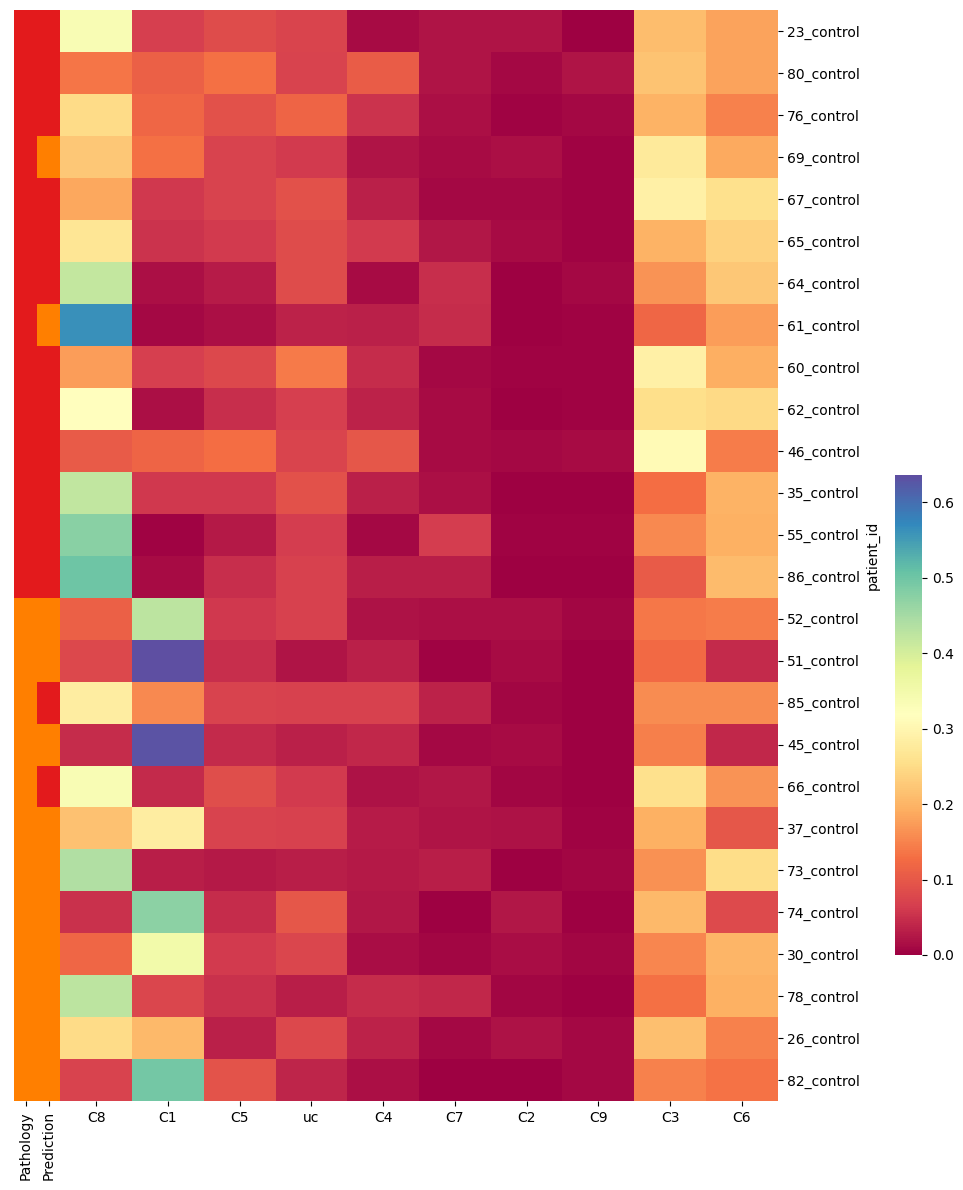

103_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Healthy
Prediabetic
105_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Healthy
Prediabetic
106_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Healthy
Healthy
107_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Healthy
Healthy
108_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Healthy
Prediabetic
109_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Healthy
Prediabetic
110_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Healthy
Healthy
111_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Healthy
Healthy
112_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Healthy
Healthy
113_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Healthy
Prediabetic
26_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Prediabetic
Healthy
30_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Prediabetic
Healthy
37_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Prediabetic
Prediabetic
44_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Healthy
Prediabetic
45_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Prediabetic
Prediabetic
51_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Prediabetic
Prediabetic
52_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Prediabetic
Prediabetic
66_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Prediabetic
Healthy
73_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Prediabetic
Healthy
74_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Prediabetic
Healthy
78_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Prediabetic
Healthy
82_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Prediabetic
Healthy
85_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Prediabetic
Healthy
95_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Healthy
Prediabetic
97_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Healthy
Healthy
98_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Healthy
Prediabetic
99_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Healthy
Prediabetic


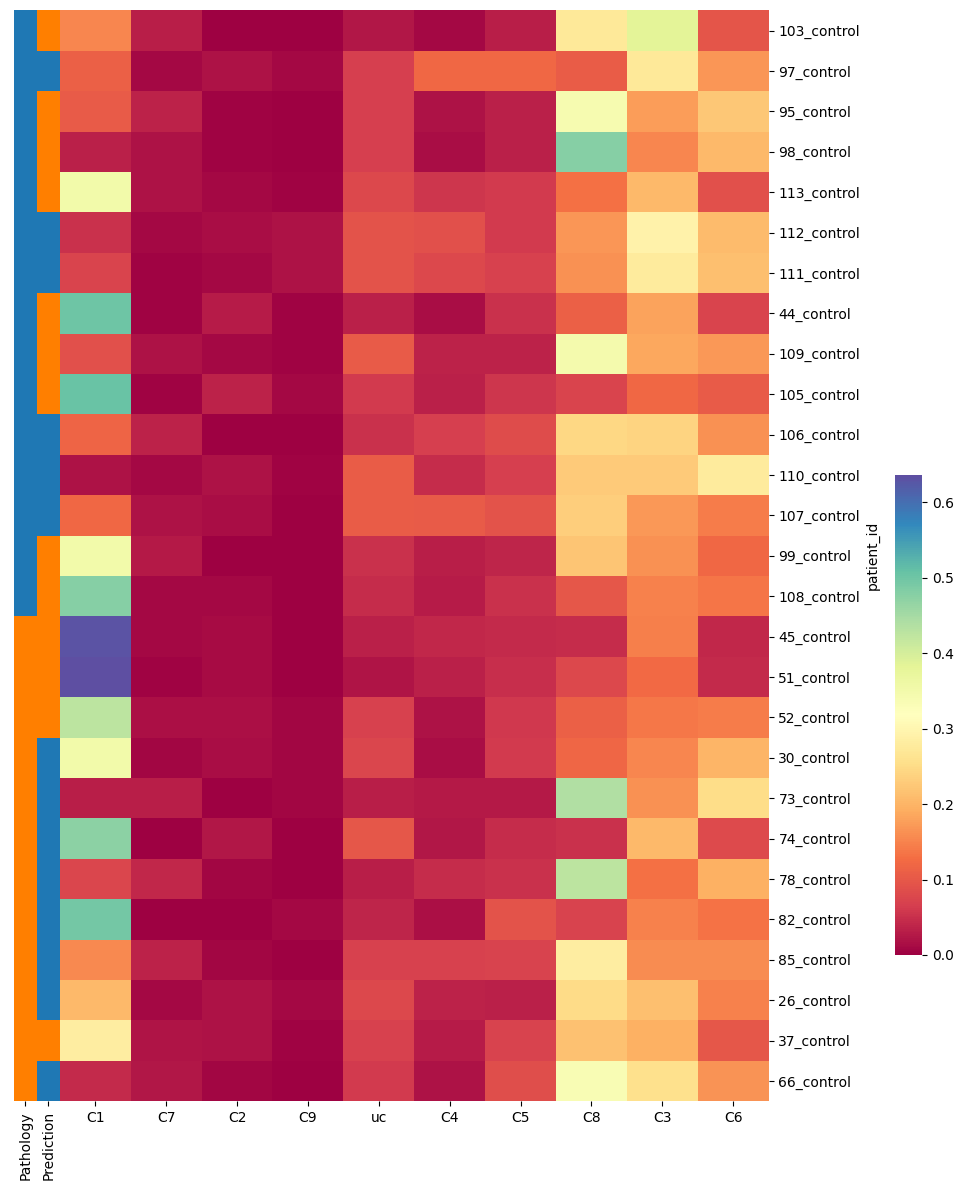

103_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Healthy
Healthy
105_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Healthy
Healthy
106_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Healthy
Diabetic
107_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Healthy
Diabetic
108_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Healthy
Healthy
109_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Healthy
Healthy
110_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Healthy
Diabetic
111_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Healthy
Diabetic
112_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Healthy
Diabetic
113_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Healthy
Healthy
23_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Diabetic
Healthy
35_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Diabetic
Diabetic
44_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Healthy
Healthy
46_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Diabetic
Healthy
55_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Diabetic
Diabetic
60_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Diabetic
Diabetic
61_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Diabetic
Diabetic
62_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Diabetic
Diabetic
64_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Diabetic
Diabetic
65_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Diabetic
Healthy
67_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Diabetic
Diabetic
69_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Diabetic
Healthy
76_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Diabetic
Healthy
80_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Diabetic
Diabetic
86_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Diabetic
Diabetic
95_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Healthy
Healthy
97_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Healthy
Diabetic
98_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Healthy
Diabetic
99_control


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Healthy
Healthy


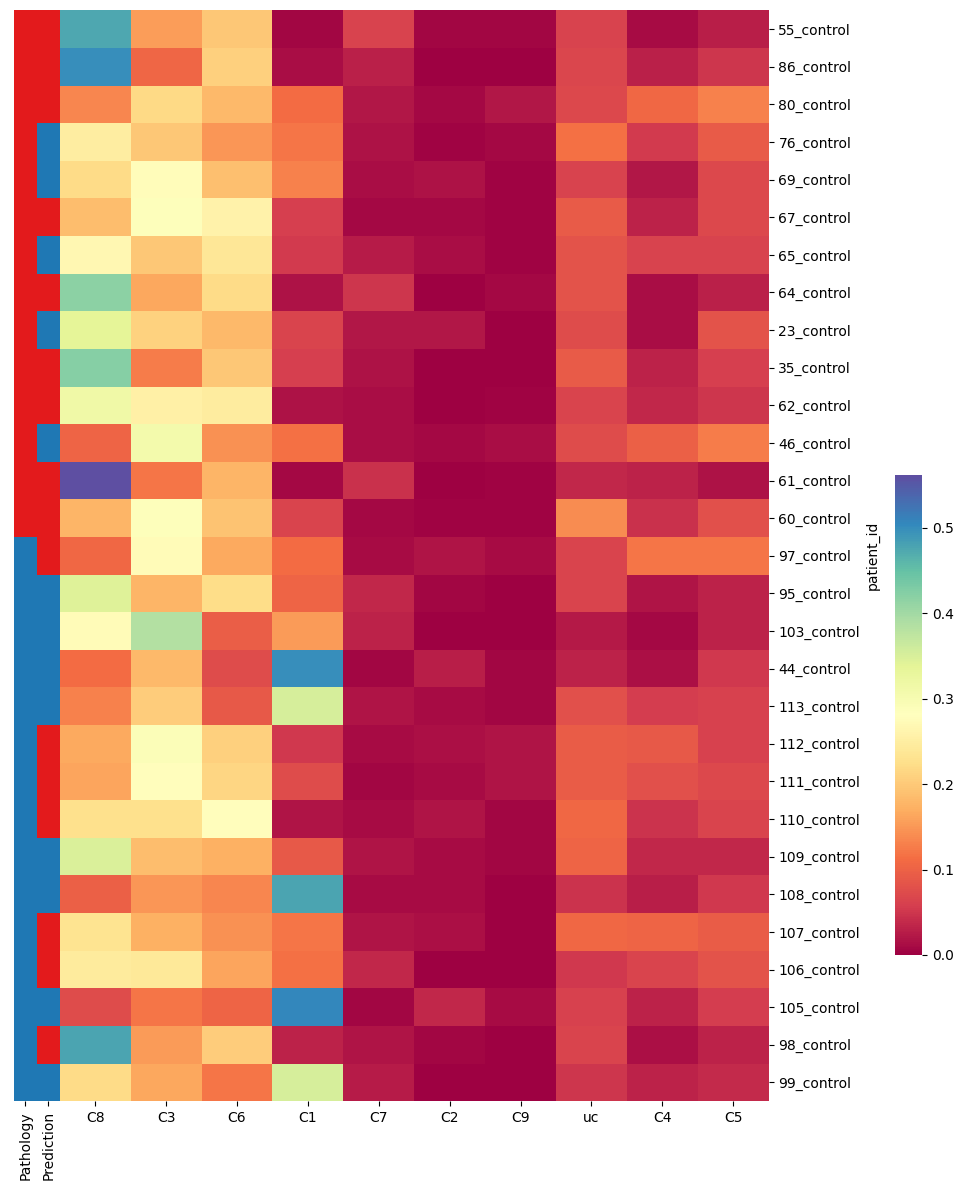

In [257]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def random_forest_classifier_leave_one_out(
    train_df,
    test_df,
    columns_drop,
    column_test,
    *,
    n_estimators=300,
    max_features=20,
    random_state=42,
):
    X_train = train_df.drop(columns_drop, axis=1)
    y_train = train_df[column_test]

    X_test = test_df.drop(columns_drop, axis=1)
    y_test = test_df[column_test]

    smote = SMOTE(random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    X_resampled = pd.DataFrame(X_resampled, columns=X_train.columns)
    y_resampled = pd.Series(y_resampled, name=column_test).reset_index(drop=True)

    rf_clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_features=max_features,
        random_state=random_state,
        n_jobs=-1,
    )
    rf_clf.fit(X_resampled, y_resampled)

    y_pred = rf_clf.predict(X_test)
    y_proba = rf_clf.predict_proba(X_test)

    feature_importances = pd.Series(
        rf_clf.feature_importances_,
        index=X_resampled.columns,
        name="importance",
    ).sort_values(ascending=False)

    return {
        "predictions": y_pred,
        "probabilities": y_proba,
        "classes": rf_clf.classes_,
        "feature_importance": feature_importances,
    }


true_label_mat = []
pid_pred_mat = []
run_type = []
patient_id_list = []

feature_importance_records = []
probability_records = []

two_way_enrichement = (
    embedding_control_df_balanced_enrichement_cluster_transpose_filt.copy()
)

for disease_here in two_way_enrichement["disease"].unique():
    subset = two_way_enrichement[
        two_way_enrichement["disease"] != disease_here
    ]
    labels = subset["disease"].unique()
    patient_id_list_this_run = []
    true_label_mat_this_run = []
    pid_pred_mat_this_run = [] 
    for patient_id in subset["patient_id"].unique():
        print(patient_id)
        test_rows = subset[subset["patient_id"] == patient_id]
        train_rows = subset[subset["patient_id"] != patient_id]

        result = random_forest_classifier_leave_one_out(
            train_rows,
            test_rows,
            ["patient_id", "disease"],
            "disease",
        )

        # Predictions / probabilities (usually a single row per patient)
        true_label = test_rows["disease"].iloc[0]
        pred_label = result["predictions"][0]
        class_probs = result["probabilities"][0]

        print(true_label)
        print(pred_label)

        true_label_mat.append(true_label)
        pid_pred_mat.append(pred_label)
        run_type.append(f"{labels[0]} vs {labels[1]}")
        patient_id_list.append(patient_id)

        probability_entry = {
            "patient_id": patient_id,
            "run_type": f"{labels[0]} vs {labels[1]}",
            "true_label": true_label,
            "pred_label": pred_label,
        }
        probability_entry.update(
            {
                f"prob_{cls}": prob
                for cls, prob in zip(result["classes"], class_probs)
            }
        )
        probability_records.append(probability_entry)

        importance_series = result["feature_importance"]
        feature_importance_records.extend(
            {
                "patient_id": patient_id,
                "run_type": f"{labels[0]} vs {labels[1]}",
                "feature": feature_name,
                "importance": importance_value,
            }
            for feature_name, importance_value in importance_series.items()
        )
        patient_id_list_this_run.append(patient_id)
        true_label_mat_this_run.append(true_label)
        pid_pred_mat_this_run.append(pred_label)
    true_vs_pred = pd.DataFrame({'patient_id': patient_id_list_this_run, 'prediction': pid_pred_mat_this_run,'disease': true_label_mat_this_run})
    true_vs_pred
    true_vs_pred["disease"] = true_vs_pred["disease"].apply(
        lambda x: x[0] if isinstance(x, (list, tuple)) else x
    )
    true_vs_pred

    pd_ht_map = subset.merge(true_vs_pred, on =['patient_id','disease'])
    label_to_color = {
        'Diabetic': paired_palette[5],
        'Prediabetic': paired_palette[7],
        'Healthy': paired_palette[1],
    }

    labels = pd_ht_map['disease']
    order = labels.sort_values().index

    data_ordered = pd_ht_map.loc[order]
    data_ordered.index = data_ordered['patient_id']

    row_colors = data_ordered['disease'].map(label_to_color),data_ordered['prediction'].map(label_to_color)
    row_colors = pd.DataFrame({
        "Pathology": data_ordered["disease"].map(label_to_color),
        "Prediction": data_ordered["prediction"].map(label_to_color),
    }, index=data_ordered.index)
    g = sns.clustermap(
        data_ordered.drop(columns=['disease', 'patient_id','prediction']),
        row_cluster=False,
        row_colors=row_colors,
        dendrogram_ratio=(0.005, 0.0001),
        figsize=(9, 12),
        cmap='Spectral',
        cbar_pos=(1, 0.2, 0.03, 0.4),
    )
    plt.title('')
    plt.show()


probability_df = pd.DataFrame(probability_records)
feature_importance_df = pd.DataFrame(feature_importance_records)

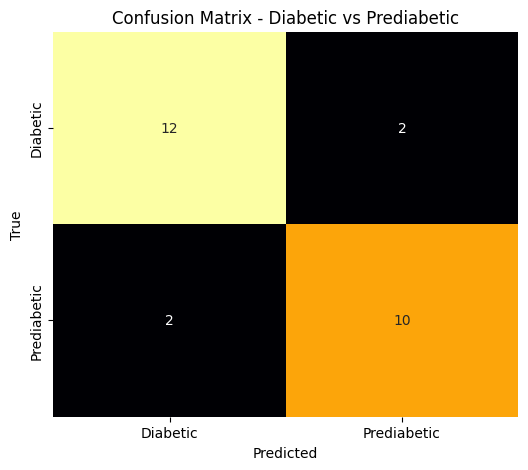

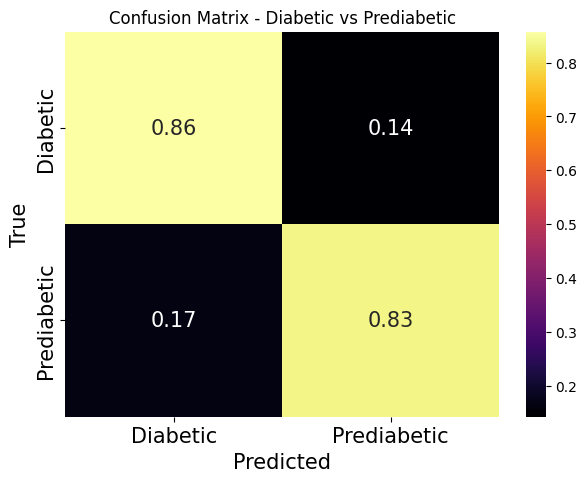

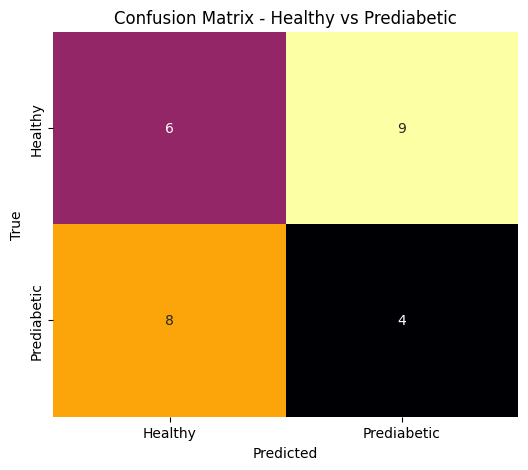

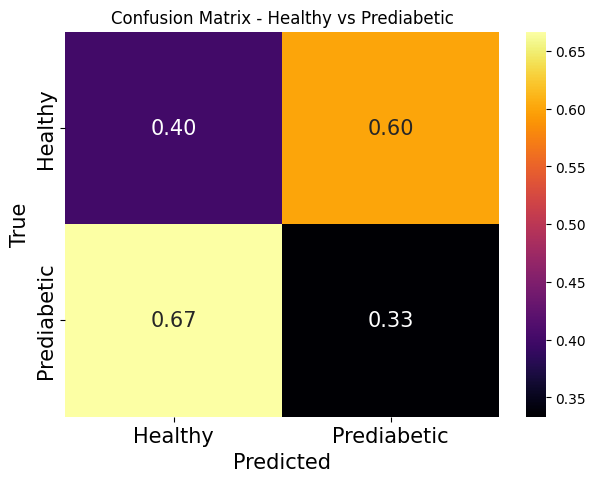

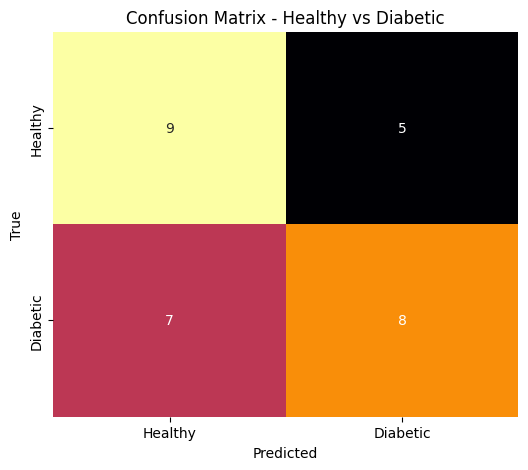

In [258]:
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report, ConfusionMatrixDisplay


two_way_predictions = pd.DataFrame({'true':true_label_mat,'pred':pid_pred_mat,'run_type':run_type,'patient_id':patient_id_list})

for cm in two_way_predictions['run_type'].unique():
    cm_split = cm.split(' vs ')
    true_label_mat_filt = two_way_predictions['true'][two_way_predictions['run_type']==cm]
    pid_pred_mat_filt = two_way_predictions['pred'][two_way_predictions['run_type']==cm]
    confusion_matrix_here = confusion_matrix(true_label_mat_filt, pid_pred_mat_filt)
    confusion_matrix_df = pd.DataFrame(confusion_matrix_here, index=[cm_split[0],cm_split[1]], columns=[cm_split[0],cm_split[1]])
    confusion_matrix_df
    plt.figure(figsize=(6,5))
    sns.heatmap(confusion_matrix_df, annot=True, fmt='d', cmap='inferno', cbar=False)
    plt.title('Confusion Matrix - ' + str(cm))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    confusion_matrix_here_norm = confusion_matrix(true_label_mat_filt, pid_pred_mat_filt, normalize= "true")
    confusion_matrix_df = pd.DataFrame(confusion_matrix_here_norm, index=[cm_split[0],cm_split[1]], columns=[cm_split[0],cm_split[1]])
    confusion_matrix_df
    plt.figure(figsize=(7,5))
    sns.heatmap(confusion_matrix_df, annot=True, fmt='.2f', cmap='inferno', cbar=True, annot_kws={"size": 15},cbar_kws={"label": ""})
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.title('Confusion Matrix - ' + str(cm))
    plt.xlabel('Predicted',fontsize = 15)
    plt.ylabel('True',fontsize = 15)
    plt.show()



In [259]:
two_way_predictions

true         pred                 run_type  patient_id
0      Diabetic     Diabetic  Diabetic vs Prediabetic  23_control
1   Prediabetic  Prediabetic  Diabetic vs Prediabetic  26_control
2   Prediabetic  Prediabetic  Diabetic vs Prediabetic  30_control
3      Diabetic     Diabetic  Diabetic vs Prediabetic  35_control
4   Prediabetic  Prediabetic  Diabetic vs Prediabetic  37_control
..          ...          ...                      ...         ...
77     Diabetic     Diabetic      Healthy vs Diabetic  86_control
78      Healthy      Healthy      Healthy vs Diabetic  95_control
79      Healthy     Diabetic      Healthy vs Diabetic  97_control
80      Healthy     Diabetic      Healthy vs Diabetic  98_control
81      Healthy      Healthy      Healthy vs Diabetic  99_control

[82 rows x 4 columns]

In [260]:
two_way_btw_prediabetes_diabetes = embedding_control_df_balanced_enrichement_cluster_transpose_filt['disease'] != "Healthy"
two_way_enrichement_pre_dia = embedding_control_df_balanced_enrichement_cluster_transpose_filt[two_way_btw_prediabetes_diabetes]
two_way_enrichement_pre_dia


patient_id        C1        C2        C3        C4        C5        C6  \
13  23_control  0.065574  0.020492  0.209016  0.012295  0.081967  0.180328   
14  26_control  0.203704  0.018519  0.212963  0.037037  0.033951  0.148148   
16  30_control  0.351724  0.013793  0.151724  0.013793  0.062069  0.200000   
17  35_control  0.057377  0.000000  0.127049  0.032787  0.057377  0.196721   
18  37_control  0.280864  0.018519  0.194444  0.027778  0.070988  0.098765   
24  45_control  0.629630  0.012346  0.145062  0.040123  0.043210  0.040123   
25  46_control  0.114754  0.008197  0.307377  0.098361  0.127049  0.143443   
28  51_control  0.635802  0.012346  0.123457  0.033951  0.049383  0.043210   
29  52_control  0.425926  0.015432  0.138889  0.018519  0.058642  0.141975   
30  55_control  0.004444  0.004444  0.155556  0.008889  0.026667  0.195556   
31  60_control  0.065574  0.004098  0.286885  0.045082  0.077869  0.192623   
32  61_control  0.008197  0.000000  0.118852  0.032787  0.016393  0.176230   
33  62_control  0.016393  0.000000  0.254098  0.036885  0.049180  0.245902   
35  64_control  0.016393  0.000000  0.163934  0.012295  0.028689  0.221311   
36  65_control  0.053279  0.012295  0.196721  0.061475  0.061475  0.237705   
37  66_control  0.042945  0.006135  0.257669  0.018405  0.085890  0.165644   
38  67_control  0.057377  0.008197  0.286885  0.032787  0.069672  0.258197   
39  69_control  0.131148  0.016393  0.274590  0.020492  0.069672  0.188525   
41  73_control  0.030303  0.000000  0.161616  0.025253  0.025253  0.252525   
42  74_control  0.474286  0.022857  0.205714  0.022857  0.045714  0.080000   
43  76_control  0.118852  0.004098  0.196721  0.053279  0.090164  0.147541   
44  78_control  0.075377  0.005025  0.130653  0.045226  0.050251  0.195980   
45  80_control  0.110656  0.008197  0.217213  0.106557  0.131148  0.180328   
46  82_control  0.496124  0.000000  0.147287  0.015504  0.093023  0.131783   
47  85_control  0.154321  0.006173  0.157407  0.067901  0.070988  0.157407   
48  86_control  0.012195  0.000000  0.103659  0.030488  0.048780  0.207317   

          C7        C8        C9        uc      disease  
13  0.020492  0.336066  0.000000  0.073770     Diabetic  
14  0.009259  0.250000  0.009259  0.077160  Prediabetic  
16  0.006897  0.117241  0.006897  0.075862  Prediabetic  
17  0.016393  0.422131  0.000000  0.090164     Diabetic  
18  0.021605  0.216049  0.003086  0.067901  Prediabetic  
24  0.009259  0.046296  0.000000  0.033951  Prediabetic  
25  0.012295  0.102459  0.012295  0.073770     Diabetic  
28  0.003086  0.077160  0.000000  0.021605  Prediabetic  
29  0.015432  0.111111  0.006173  0.067901  Prediabetic  
30  0.062222  0.475556  0.004444  0.062222     Diabetic  
31  0.008197  0.176230  0.004098  0.139344     Diabetic  
32  0.045082  0.561475  0.004098  0.036885     Diabetic  
33  0.012295  0.315574  0.004098  0.065574     Diabetic  
35  0.049180  0.418033  0.008197  0.081967     Diabetic  
36  0.024590  0.266393  0.004098  0.081967     Diabetic  
37  0.024540  0.337423  0.000000  0.061350  Prediabetic  
38  0.008197  0.184426  0.004098  0.090164     Diabetic  
39  0.012295  0.221311  0.004098  0.061475     Diabetic  
41  0.030303  0.439394  0.005051  0.030303  Prediabetic  
42  0.000000  0.051429  0.000000  0.097143  Prediabetic  
43  0.016393  0.250000  0.008197  0.114754     Diabetic  
44  0.040201  0.427136  0.000000  0.030151  Prediabetic  
45  0.020492  0.135246  0.020492  0.069672     Diabetic  
46  0.000000  0.069767  0.007752  0.038760  Prediabetic  
47  0.037037  0.280864  0.000000  0.067901  Prediabetic  
48  0.030488  0.500000  0.000000  0.067073     Diabetic

In [261]:
two_way_enrichement_pre_dia

patient_id        C1        C2        C3        C4        C5        C6  \
13  23_control  0.065574  0.020492  0.209016  0.012295  0.081967  0.180328   
14  26_control  0.203704  0.018519  0.212963  0.037037  0.033951  0.148148   
16  30_control  0.351724  0.013793  0.151724  0.013793  0.062069  0.200000   
17  35_control  0.057377  0.000000  0.127049  0.032787  0.057377  0.196721   
18  37_control  0.280864  0.018519  0.194444  0.027778  0.070988  0.098765   
24  45_control  0.629630  0.012346  0.145062  0.040123  0.043210  0.040123   
25  46_control  0.114754  0.008197  0.307377  0.098361  0.127049  0.143443   
28  51_control  0.635802  0.012346  0.123457  0.033951  0.049383  0.043210   
29  52_control  0.425926  0.015432  0.138889  0.018519  0.058642  0.141975   
30  55_control  0.004444  0.004444  0.155556  0.008889  0.026667  0.195556   
31  60_control  0.065574  0.004098  0.286885  0.045082  0.077869  0.192623   
32  61_control  0.008197  0.000000  0.118852  0.032787  0.016393  0.176230   
33  62_control  0.016393  0.000000  0.254098  0.036885  0.049180  0.245902   
35  64_control  0.016393  0.000000  0.163934  0.012295  0.028689  0.221311   
36  65_control  0.053279  0.012295  0.196721  0.061475  0.061475  0.237705   
37  66_control  0.042945  0.006135  0.257669  0.018405  0.085890  0.165644   
38  67_control  0.057377  0.008197  0.286885  0.032787  0.069672  0.258197   
39  69_control  0.131148  0.016393  0.274590  0.020492  0.069672  0.188525   
41  73_control  0.030303  0.000000  0.161616  0.025253  0.025253  0.252525   
42  74_control  0.474286  0.022857  0.205714  0.022857  0.045714  0.080000   
43  76_control  0.118852  0.004098  0.196721  0.053279  0.090164  0.147541   
44  78_control  0.075377  0.005025  0.130653  0.045226  0.050251  0.195980   
45  80_control  0.110656  0.008197  0.217213  0.106557  0.131148  0.180328   
46  82_control  0.496124  0.000000  0.147287  0.015504  0.093023  0.131783   
47  85_control  0.154321  0.006173  0.157407  0.067901  0.070988  0.157407   
48  86_control  0.012195  0.000000  0.103659  0.030488  0.048780  0.207317   

          C7        C8        C9        uc      disease  
13  0.020492  0.336066  0.000000  0.073770     Diabetic  
14  0.009259  0.250000  0.009259  0.077160  Prediabetic  
16  0.006897  0.117241  0.006897  0.075862  Prediabetic  
17  0.016393  0.422131  0.000000  0.090164     Diabetic  
18  0.021605  0.216049  0.003086  0.067901  Prediabetic  
24  0.009259  0.046296  0.000000  0.033951  Prediabetic  
25  0.012295  0.102459  0.012295  0.073770     Diabetic  
28  0.003086  0.077160  0.000000  0.021605  Prediabetic  
29  0.015432  0.111111  0.006173  0.067901  Prediabetic  
30  0.062222  0.475556  0.004444  0.062222     Diabetic  
31  0.008197  0.176230  0.004098  0.139344     Diabetic  
32  0.045082  0.561475  0.004098  0.036885     Diabetic  
33  0.012295  0.315574  0.004098  0.065574     Diabetic  
35  0.049180  0.418033  0.008197  0.081967     Diabetic  
36  0.024590  0.266393  0.004098  0.081967     Diabetic  
37  0.024540  0.337423  0.000000  0.061350  Prediabetic  
38  0.008197  0.184426  0.004098  0.090164     Diabetic  
39  0.012295  0.221311  0.004098  0.061475     Diabetic  
41  0.030303  0.439394  0.005051  0.030303  Prediabetic  
42  0.000000  0.051429  0.000000  0.097143  Prediabetic  
43  0.016393  0.250000  0.008197  0.114754     Diabetic  
44  0.040201  0.427136  0.000000  0.030151  Prediabetic  
45  0.020492  0.135246  0.020492  0.069672     Diabetic  
46  0.000000  0.069767  0.007752  0.038760  Prediabetic  
47  0.037037  0.280864  0.000000  0.067901  Prediabetic  
48  0.030488  0.500000  0.000000  0.067073     Diabetic

In [262]:
from sklearn.metrics import recall_score, roc_auc_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import check_random_state
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd

def binary_cv_vs_permutation_null(
    df: pd.DataFrame,
    target: str,
    drop_cols,
    pos_label,                  # e.g. "T2D" (required)
    neg_label=None,             # e.g. "Prediabetes" (optional if dataset is already binary)
    cv_splits: int = 5,
    n_permutations: int = 200,
    random_state: int = 42,
    n_est: int = 300,
    max_feat="sqrt",
    smote_k: int = 3,
):
    """
    Binary observed CV metrics vs permutation null using *named* class labels.
    Returns:
      results: dict with observed metrics and null distributions
      y_true:  original labels (in df order, filtered to the two classes)
      y_pred:  CV out-of-sample predicted labels (same label names)
      y_proba_pos: CV out-of-sample P(pos_label)
      pos_label, neg_label: the label names used
    """
    # Keep only the columns you want as features
    X = df.drop(columns=drop_cols, axis=1).copy()
    y = df[target].values

    # Determine which two labels are used
    uniq = pd.unique(y)
    if pos_label not in uniq:
        raise ValueError(f"pos_label={pos_label!r} not found in labels {uniq.tolist()}.")
    if neg_label is None:
        # If exactly two classes, pick the other as negative; else require explicit neg_label
        if len(uniq) == 2:
            neg_label = next(lbl for lbl in uniq if lbl != pos_label)
        else:
            raise ValueError(
                f"Dataset has >2 classes {uniq.tolist()}. "
                f"Please specify neg_label explicitly."
            )

    # Filter to the two classes only (if df had more than two labels originally)
    keep = (y == pos_label) | (y == neg_label)
    X = X.loc[keep].values
    y = y[keep]

    pipe = Pipeline(steps=[
        ("smote", SMOTE(random_state=random_state, k_neighbors=smote_k)),
        ("rf", RandomForestClassifier(
            n_estimators=n_est,
            max_features=max_feat,
            random_state=random_state,
            n_jobs=-1
        ))
    ])

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    rng = check_random_state(random_state)

    n = len(y)
    y_pred = np.empty(n, dtype=object)
    y_proba_pos = np.empty(n, dtype=float)

    # -------- Observed CV predictions (manual CV; no cross_val_predict) --------
    for tr, va in cv.split(X, y):
        pipe.fit(X[tr], y[tr])
        proba = pipe.predict_proba(X[va])      # (n_val, 2) in the order pipe.rf.classes_
        preds = pipe.predict(X[va])

        classes_fit = pipe.named_steps["rf"].classes_
        pos_idx = int(np.where(classes_fit == pos_label)[0][0])

        y_pred[va] = preds
        y_proba_pos[va] = proba[:, pos_idx]

    # -------- Observed metrics --------
    y_pos = (y == pos_label).astype(int)
    y_pred_pos = (y_pred == pos_label).astype(int)

    acc_obs = accuracy_score(y, y_pred)
    recall_pos_obs = recall_score(y_pos, y_pred_pos)
    auc_obs = roc_auc_score(y_pos, y_proba_pos)

    results = {
        "overall": {
            "acc_obs": acc_obs,
            "recall_pos_obs": recall_pos_obs,
            "auc_obs": auc_obs,
            "acc_perm": [],
            "recall_pos_perm": [],
            "auc_perm": []
        },
        "labels": {"pos": pos_label, "neg": neg_label}
    }

    # -------- Permutation null --------
    for _ in range(n_permutations):
        y_perm = rng.permutation(y)

        y_pred_perm = np.empty(n, dtype=object)
        y_proba_pos_perm = np.empty(n, dtype=float)

        for tr, va in cv.split(X, y_perm):
            pipe.fit(X[tr], y_perm[tr])
            proba = pipe.predict_proba(X[va])
            preds = pipe.predict(X[va])

            classes_fit = pipe.named_steps["rf"].classes_
            pos_idx = int(np.where(classes_fit == pos_label)[0][0])

            y_pred_perm[va] = preds
            y_proba_pos_perm[va] = proba[:, pos_idx]

        y_perm_pos = (y_perm == pos_label).astype(int)
        y_pred_perm_pos = (y_pred_perm == pos_label).astype(int)

        results["overall"]["acc_perm"].append(accuracy_score(y_perm, y_pred_perm))
        results["overall"]["recall_pos_perm"].append(recall_score(y_perm_pos, y_pred_perm_pos))
        results["overall"]["auc_perm"].append(roc_auc_score(y_perm_pos, y_proba_pos_perm))

    # lists -> arrays
    for k in ("acc_perm", "recall_pos_perm", "auc_perm"):
        results["overall"][k] = np.array(results["overall"][k])

    return results, y, y_pred, y_proba_pos, pos_label, neg_label

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt




def plot_cv_vs_null_binary(results, title="Observed CV vs Permutation Null (Binary)"):
    """
    Expects the structure from the binary evaluator:
      results["overall"]["acc_obs"], ["recall_pos_obs"], ["auc_obs"]
      and corresponding *_perm arrays.
    """
    obs_acc   = results["overall"]["acc_obs"]
    obs_rec   = results["overall"]["recall_pos_obs"]
    obs_auc   = results["overall"]["auc_obs"]

    null_acc  = np.mean(results["overall"]["acc_perm"])
    null_rec  = np.mean(results["overall"]["recall_pos_perm"])
    null_auc  = np.mean(results["overall"]["auc_perm"])

    err_acc   = np.std(results["overall"]["acc_perm"])
    err_rec   = np.std(results["overall"]["recall_pos_perm"])
    err_auc   = np.std(results["overall"]["auc_perm"])

    labels = ["Accuracy", "Recall(+)", "ROC-AUC"]
    obs    = [obs_acc, obs_rec, obs_auc]
    null   = [null_acc, null_rec, null_auc]
    errs   = [err_acc, err_rec, err_auc]

    x = np.arange(len(labels))
    width = 0.35

    plt.figure(figsize=(6,5))
    plt.bar(x - width/2, obs,  width, label="Observed")
    plt.bar(x + width/2, null, width, yerr=errs, capsize=4, label="Permutation null")
    plt.xticks(x, labels, fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylabel("Score", fontsize=12)
    plt.title(title, pad=20)
    plt.legend(frameon=False, fontsize=12, borderaxespad=0.0)
    sns.despine()
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()




In [263]:
results, y, y_pred, y_proba_pos, pos, neg = binary_cv_vs_permutation_null(
df=two_way_enrichement_pre_dia,
target='disease',
drop_cols=['patient_id','disease'],
pos_label="Diabetic",                 # your positive class *by name*
neg_label="Prediabetic",
cv_splits=5,
n_permutations=200,
random_state=42
)


/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/local_home/guptaraj/anaconda3/envs/analysis_pipeline/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-lea

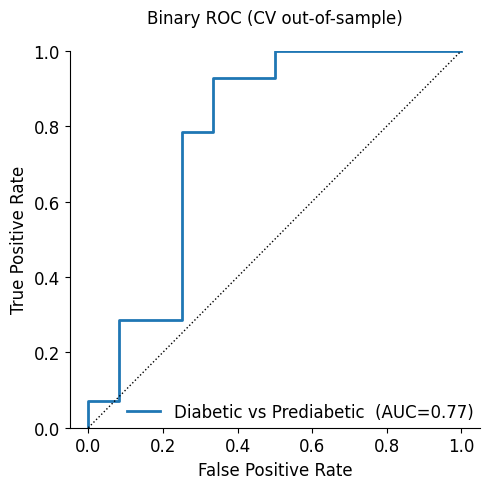

In [264]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

def plot_binary_roc_from_cv(y_true, y_proba, pos_label,neg_label, classes=None,
                            title="Binary ROC (CV out-of-sample)"):
    """
    y_true: 1D array of labels (can be strings/numbers)
    y_proba: either 1D (P(pos)) or 2D (n_samples x 2) probs
    pos_label: the positive class label (e.g., "T2D")
    classes: optional array-like of class labels in the same column order as y_proba (if 2D)
    """
    y_true = np.asarray(y_true)

    # Get P(pos) as a 1D vector
    if y_proba.ndim == 1:
        p_pos = np.asarray(y_proba)
    else:
        if classes is None:
            # Assume column 1 is positive if not specified (common convention)
            pos_idx = 1
        else:
            classes = np.asarray(classes)
            try:
                pos_idx = int(np.where(classes == pos_label)[0][0])
            except IndexError:
                raise ValueError(f"pos_label={pos_label!r} not found in classes={classes.tolist()}")
        p_pos = y_proba[:, pos_idx]

    y_bin = (y_true == pos_label).astype(int)

    fpr, tpr, _ = roc_curve(y_bin, p_pos)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, lw=2, label=f"{pos_label} vs {neg_label}  (AUC={roc_auc:.2f})")
    plt.plot([0,1], [0,1], 'k:', lw=1)
    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(title, pad=20)
    sns.despine()
    plt.legend(frameon=False, fontsize=12, borderaxespad=0.0)
    plt.tight_layout()
    plt.ylim(0,1)
    plt.show()

plot_binary_roc_from_cv(y, y_proba_pos, pos_label="Diabetic", neg_label = "Prediabetic")


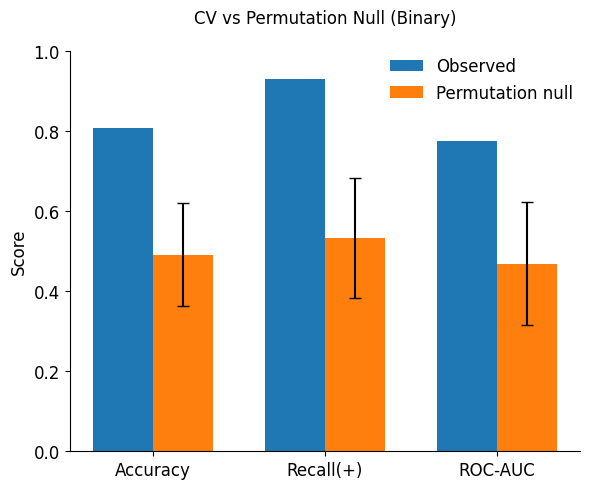

In [265]:
plot_cv_vs_null_binary(results, title="CV vs Permutation Null (Binary)")

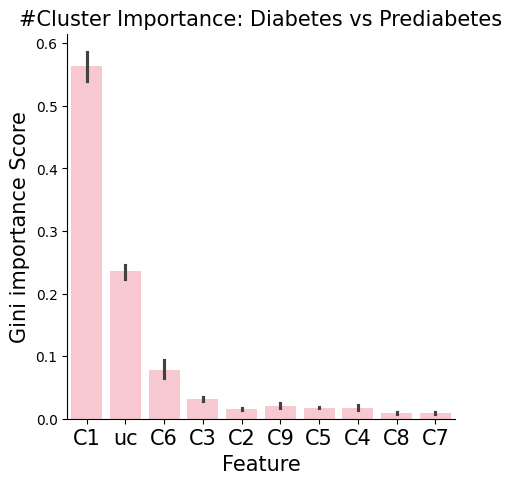

In [284]:
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
feature_importance_df_T2DMvsPre = feature_importance_df[feature_importance_df['run_type'] == "Diabetic vs Prediabetic"]
plt.figure(figsize=(5, 5))
sns.barplot(data = feature_importance_df_T2DMvsPre ,y = feature_importance_df_T2DMvsPre['importance'], x = feature_importance_df_T2DMvsPre['feature'], color = 'pink')
sns.despine()
plt.title('#Cluster Importance: Diabetes vs Prediabetes', fontsize = 15)

plt.xlabel('Feature', fontsize = 15)
plt.ylabel('Gini importance Score', fontsize = 15)
plt.xticks(fontsize = 15)
# plt.text(0.98, 0.98,
#         f"F = {F:.2f}\nP = {p:.3e}",
#         transform=ax.transAxes, ha='right', va='top',
#         bbox=dict(boxstyle='round', fc='white', ec='black'))
# print(anova_table)  # check overall p-value
plt.show()
model = ols('importance ~ C(feature)', data=feature_importance_df_T2DMvsPre).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
p = float(anova_table.loc['C(feature)', 'PR(>F)'])
F = float(anova_table.loc['C(feature)', 'F'])



In [267]:
embedding_control_df_balanced_enrichement_cluster_transpose_filt

patient_id        C1        C2        C3        C4        C5        C6  \
0   103_control  0.152000  0.000000  0.384000  0.008000  0.032000  0.096000   
1   105_control  0.504630  0.037037  0.120370  0.032407  0.055556  0.101852   
2   106_control  0.115741  0.000000  0.240741  0.064815  0.083333  0.162037   
3   107_control  0.120370  0.013889  0.171296  0.101852  0.092593  0.143519   
4   108_control  0.476852  0.009259  0.148148  0.027778  0.050926  0.134259   
5   109_control  0.087963  0.009259  0.185185  0.037037  0.037037  0.171296   
6   110_control  0.018519  0.018519  0.226852  0.046296  0.064815  0.277778   
7   111_control  0.074074  0.009259  0.277778  0.078704  0.069444  0.212963   
8   112_control  0.050926  0.013889  0.291667  0.087963  0.060185  0.208333   
9   113_control  0.351852  0.009259  0.203704  0.055556  0.060185  0.087963   
13   23_control  0.065574  0.020492  0.209016  0.012295  0.081967  0.180328   
14   26_control  0.203704  0.018519  0.212963  0.037037  0.033951  0.148148   
16   30_control  0.351724  0.013793  0.151724  0.013793  0.062069  0.200000   
17   35_control  0.057377  0.000000  0.127049  0.032787  0.057377  0.196721   
18   37_control  0.280864  0.018519  0.194444  0.027778  0.070988  0.098765   
23   44_control  0.500000  0.027778  0.180556  0.013889  0.050926  0.074074   
24   45_control  0.629630  0.012346  0.145062  0.040123  0.043210  0.040123   
25   46_control  0.114754  0.008197  0.307377  0.098361  0.127049  0.143443   
28   51_control  0.635802  0.012346  0.123457  0.033951  0.049383  0.043210   
29   52_control  0.425926  0.015432  0.138889  0.018519  0.058642  0.141975   
30   55_control  0.004444  0.004444  0.155556  0.008889  0.026667  0.195556   
31   60_control  0.065574  0.004098  0.286885  0.045082  0.077869  0.192623   
32   61_control  0.008197  0.000000  0.118852  0.032787  0.016393  0.176230   
33   62_control  0.016393  0.000000  0.254098  0.036885  0.049180  0.245902   
35   64_control  0.016393  0.000000  0.163934  0.012295  0.028689  0.221311   
36   65_control  0.053279  0.012295  0.196721  0.061475  0.061475  0.237705   
37   66_control  0.042945  0.006135  0.257669  0.018405  0.085890  0.165644   
38   67_control  0.057377  0.008197  0.286885  0.032787  0.069672  0.258197   
39   69_control  0.131148  0.016393  0.274590  0.020492  0.069672  0.188525   
41   73_control  0.030303  0.000000  0.161616  0.025253  0.025253  0.252525   
42   74_control  0.474286  0.022857  0.205714  0.022857  0.045714  0.080000   
43   76_control  0.118852  0.004098  0.196721  0.053279  0.090164  0.147541   
44   78_control  0.075377  0.005025  0.130653  0.045226  0.050251  0.195980   
45   80_control  0.110656  0.008197  0.217213  0.106557  0.131148  0.180328   
46   82_control  0.496124  0.000000  0.147287  0.015504  0.093023  0.131783   
47   85_control  0.154321  0.006173  0.157407  0.067901  0.070988  0.157407   
48   86_control  0.012195  0.000000  0.103659  0.030488  0.048780  0.207317   
50   95_control  0.101852  0.004630  0.175926  0.018519  0.032407  0.222222   
52   97_control  0.111111  0.018519  0.273148  0.120370  0.120370  0.166667   
53   98_control  0.032407  0.004630  0.152778  0.013889  0.032407  0.203704   
54   99_control  0.352201  0.000000  0.163522  0.031447  0.037736  0.119497   

          C7        C8        C9        uc      disease  
0   0.032000  0.272000  0.000000  0.024000      Healthy  
1   0.004630  0.074074  0.009259  0.060185      Healthy  
2   0.037037  0.245370  0.000000  0.050926      Healthy  
3   0.018519  0.231481  0.000000  0.106481      Healthy  
4   0.009259  0.097222  0.000000  0.046296      Healthy  
5   0.018519  0.347222  0.004630  0.101852      Healthy  
6   0.009259  0.226852  0.004630  0.106481      Healthy  
7   0.004630  0.162037  0.018519  0.092593      Healthy  
8   0.009259  0.166667  0.018519  0.092593      Healthy  
9   0.018519  0.129630  0.004630  0.078704      Healthy  
13  0.020492  0.336066  0.000000  0.073770     D

C1
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Healthy vs. Diabetic: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.384e-03 U_stat=1.650e+02
Diabetic vs. Prediabetic: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.552e-03 U_stat=2.200e+01
Healthy vs. Prediabetic: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.515e-01 U_stat=6.600e+01


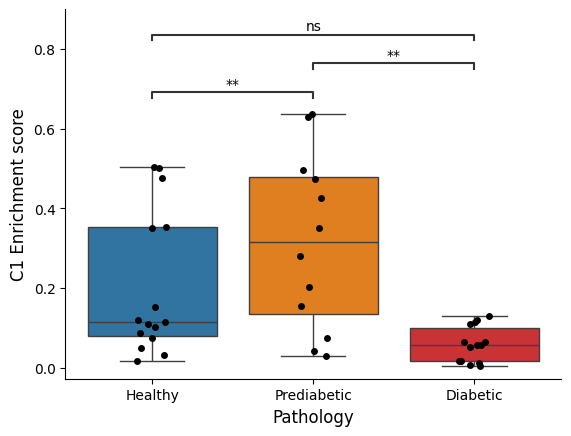

uc
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Healthy vs. Diabetic: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.045e-01 U_stat=8.100e+01
Diabetic vs. Prediabetic: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.741e-02 (ns) U_stat=1.230e+02
Healthy vs. Prediabetic: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.164e-01 U_stat=1.110e+02


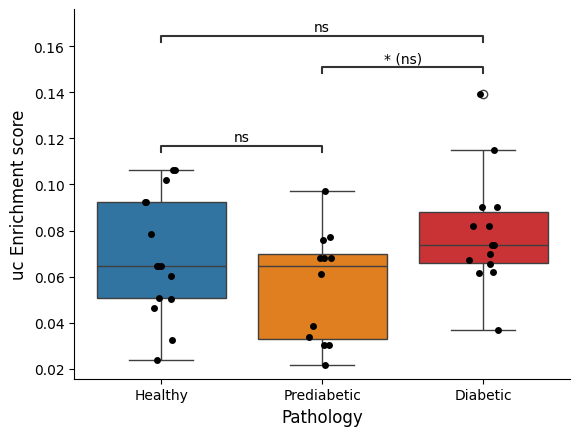

C6
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Healthy vs. Diabetic: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.760e-02 U_stat=6.100e+01
Diabetic vs. Prediabetic: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.454e-02 U_stat=1.320e+02
Healthy vs. Prediabetic: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.667e-01 U_stat=1.090e+02


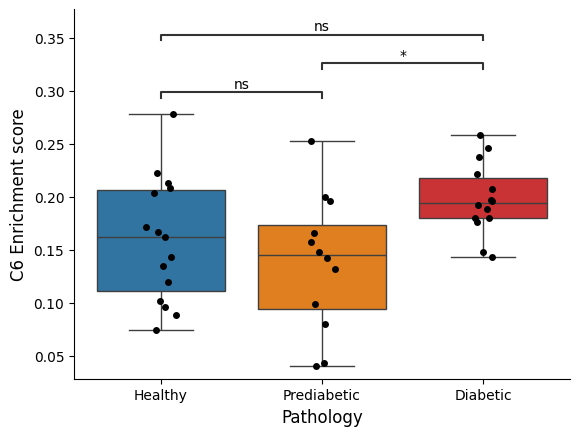

C3
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Healthy vs. Diabetic: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.000e+00 U_stat=1.050e+02
Diabetic vs. Prediabetic: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.425e-01 U_stat=1.130e+02
Healthy vs. Prediabetic: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.393e-02 U_stat=1.300e+02


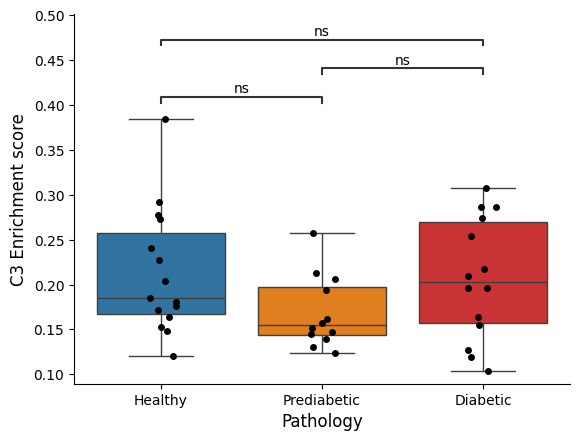

C2
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Healthy vs. Diabetic: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.705e-02 U_stat=1.455e+02
Diabetic vs. Prediabetic: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.104e-02 U_stat=5.100e+01
Healthy vs. Prediabetic: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.023e-01 U_stat=8.700e+01


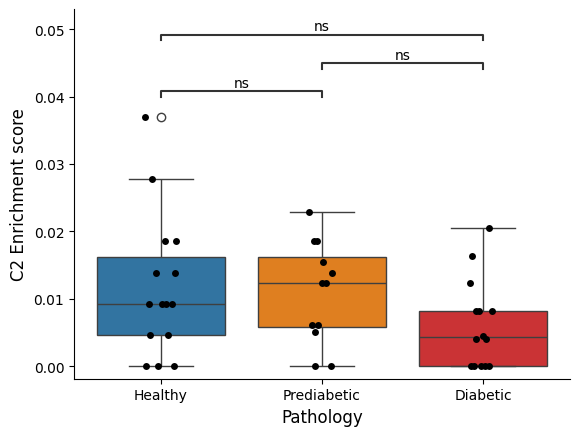

C9
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Healthy vs. Diabetic: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.577e-01 U_stat=1.005e+02
Diabetic vs. Prediabetic: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.026e-01 U_stat=1.040e+02
Healthy vs. Prediabetic: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.753e-01 U_stat=9.600e+01


C5
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Healthy vs. Diabetic: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.555e-01 U_stat=9.100e+01
Diabetic vs. Prediabetic: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.250e-01 U_stat=9.400e+01
Healthy vs. Prediabetic: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.416e-01 U_stat=8.800e+01


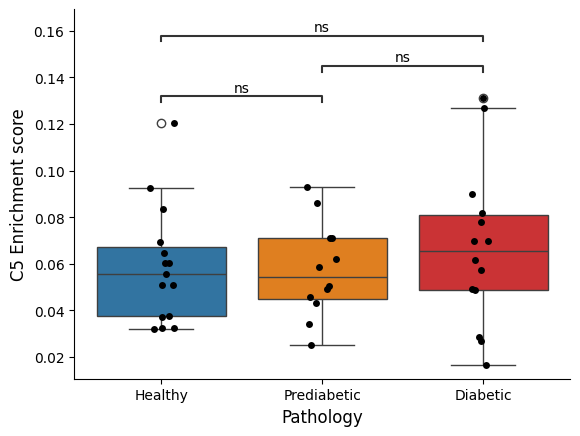

C4
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Healthy vs. Diabetic: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.465e-01 U_stat=1.160e+02
Diabetic vs. Prediabetic: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.538e-01 U_stat=9.600e+01
Healthy vs. Prediabetic: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.222e-01 U_stat=1.155e+02


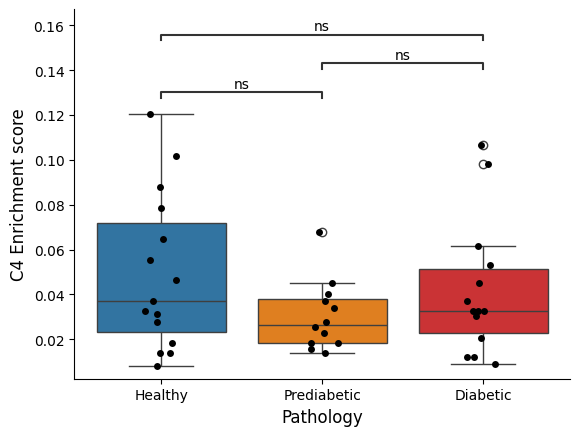

C8
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Healthy vs. Diabetic: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.011e-02 U_stat=6.300e+01
Diabetic vs. Prediabetic: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.028e-02 U_stat=1.185e+02
Healthy vs. Prediabetic: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.914e-01 U_stat=1.015e+02


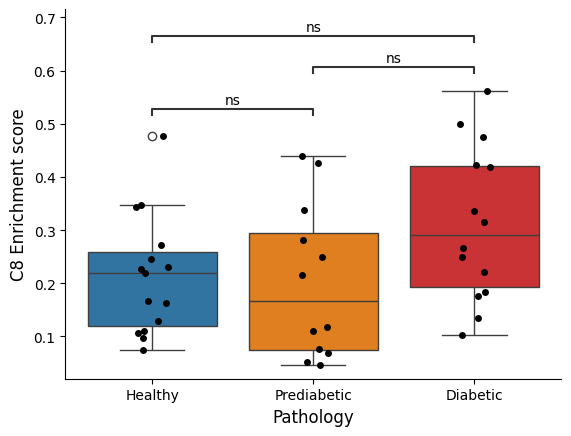

C7
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Healthy vs. Diabetic: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.639e-01 U_stat=7.900e+01
Diabetic vs. Prediabetic: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.069e-01 U_stat=1.090e+02
Healthy vs. Prediabetic: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.491e-01 U_stat=9.700e+01


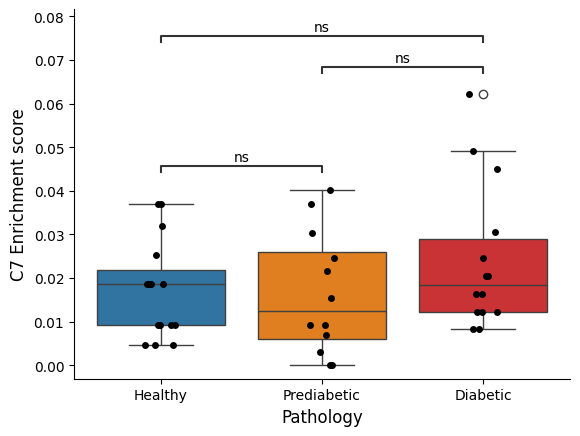

In [268]:
from statannotations.Annotator import Annotator
pairs = [('Healthy', 'Prediabetic'), ('Healthy', 'Diabetic'),('Prediabetic','Diabetic')]
val = ['0.13','0.063','0.17','0.2','0.01','0.01','0.07','0.04','0.2','0.02']
for i,value in zip(feature_importance_df_T2DMvsPre['feature'].unique(),val):
    print(i)
    cond1 = embedding_control_df_balanced_enrichement_cluster_transpose_filt['disease'] != 'Healthy'
    concentration_score = embedding_control_df_balanced_enrichement_cluster_transpose_filt#[cond1]
    order = ['Healthy', 'Prediabetic', 'Diabetic']
    ax = sns.boxplot(concentration_score, x= 'disease' ,y = str(i), hue = 'disease', palette =(control_palette[1],control_palette[0],control_palette[2]), order = order)
    ax = sns.stripplot(concentration_score, x= 'disease' ,y = str(i),color = "black")
    sns.despine()
    # y_line = float(value) # adjust as needed
    # plt.axhline(y=y_line, color="red", linestyle="--", linewidth=1.5)
    annotator = Annotator(ax, pairs, data=concentration_score, x='disease', y=str(i))

    annotator.configure(
        test="Mann-Whitney",
        text_format="star",      # or "simple", "passthrough"
        comparisons_correction="BH",  # Benjamini-Hochberg; set to None to skip
        verbose=2,               # prints stats to console
    )
    annotator.apply_and_annotate()
    # plt.annotate(
    #     "Threshold ="+str(value),
    #     xy=(0.02, y_line + 0.02),  # small offset
    #     xycoords=("axes fraction", "data"),
    #     color="black",
    # )
    plt.ylabel(str(i)+' Enrichment score', fontsize = 12)
    plt.xlabel('Pathology', fontsize = 12)
    plt.show()

In [ ]:
control_palettecohort_details = pd.read_csv('cohort_details.csv')

cohort_details = cohort_details.rename(columns={"Sample No": "patient_id"})
cohort_details
table_control_pat_spec_vec_df_filt = pd.DataFrame(table_control_pat_spec_vec_df_filt)

[(0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.0)]

In [309]:
recon_list

[array([[[[1.7720925e-04, 1.1071692e-06, 2.5503085e-05, ...,
           8.1277534e-04, 3.5870163e-04, 3.7797280e-03],
          [2.2509441e-06, 0.0000000e+00, 8.0027212e-06, ...,
           2.4380987e-04, 1.2941886e-04, 3.4527638e-04],
          [3.2730293e-06, 5.2982011e-07, 2.5529331e-05, ...,
           9.9197868e-04, 1.6555103e-04, 1.9027494e-03],
          ...,
          [7.5262971e-04, 2.9394191e-04, 6.1498798e-04, ...,
           8.3981344e-04, 9.6763036e-04, 9.1553747e-04],
          [3.0317332e-04, 1.9697365e-04, 2.2583581e-04, ...,
           4.6029579e-04, 2.0387789e-04, 5.9973774e-04],
          [4.3040379e-03, 6.2504195e-04, 2.0145329e-03, ...,
           1.1462086e-03, 1.6633468e-03, 5.2403854e-03]]]], dtype=float32),
 array([[[[2.3501641e-03, 3.8627117e-05, 4.3463885e-04, ...,
           1.4168036e-03, 8.4148720e-04, 7.2287028e-03],
          [9.5714968e-05, 5.5465495e-07, 6.2047831e-05, ...,
           4.6831227e-04, 3.2213298e-04, 7.6711015e-04],
          [1.2966344e-

In [ ]:
embedding_control_bal_view_good_cells.groupby

0         1  patient_id constriction_size      disease  \
6070  -0.039000  3.643773  35_control           control     Diabetic   
6072   3.957104  5.444647  46_control           control     Diabetic   
6076   0.977679  4.866217  67_control           control     Diabetic   
6078   3.808086  3.266724  35_control           control     Diabetic   
6079   1.288270  3.212469  62_control           control     Diabetic   
...         ...       ...         ...               ...          ...   
48016  1.846043  6.425914  37_control           control  Prediabetic   
48017  7.793948  2.020196  26_control           control  Prediabetic   
48019  7.096259  0.868580  45_control           control  Prediabetic   
48022  5.109960  5.688972  37_control           control  Prediabetic   
48023  8.124804  0.310678  82_control           control  Prediabetic   

          disease_constric            pathalogy treatment  balanced_sample  \
6070      Diabetic_control     Diabetic_control   control              1.0   
6072      Diabetic_control     Diabetic_control   control              1.0   
6076      Diabetic_control     Diabetic_control   control              1.0   
6078      Diabetic_control     Diabetic_control   control              1.0   
6079      Diabetic_control     Diabetic_control   control              1.0   
...                    ...                  ...       ...              ...   
48016  Prediabetic_control  Prediabetic_control   control              1.0   
48017  Prediabetic_control  Prediabetic_control   control              1.0   
48019  Prediabetic_control  Prediabetic_control   control              1.0   
48022  Prediabetic_control  Prediabetic_control   control              1.0   
48023  Prediabetic_control  Prediabetic_control   control              1.0   

      label_leiden  
6070            C8  
6072            C5  
6076            C6  
6078            uc  
6079            C3  
...            ...  
48016           C7  
48017           C1  
48019           C1  
48022           C5  
48023           C1  

[9936 rows x 10 columns]

In [316]:
sampled = (
    embedding_control_bal_view_good_cells.groupby(["label_leiden", "disease"], group_keys=False)
      .apply(lambda g: g.sample(n=min(len(g), 5), random_state=42))
)
sampled

0         1  patient_id constriction_size      disease  \
9343   9.159362  0.533794  69_control           control     Diabetic   
6571   8.091506  0.905726  35_control           control     Diabetic   
7376   6.469820  2.196086  69_control           control     Diabetic   
12048  6.656853  3.140319  23_control           control     Diabetic   
13282  5.740318  2.591712  62_control           control     Diabetic   
...         ...       ...         ...               ...          ...   
41630  5.867324  1.341574  52_control           control  Prediabetic   
42641  3.658677  4.475738  52_control           control  Prediabetic   
46954  3.327571  0.613269  74_control           control  Prediabetic   
45408  4.515776  2.462960  37_control           control  Prediabetic   
46489  1.027989  3.356096  85_control           control  Prediabetic   

          disease_constric            pathalogy treatment  balanced_sample  \
9343      Diabetic_control     Diabetic_control   control              1.0   
6571      Diabetic_control     Diabetic_control   control              1.0   
7376      Diabetic_control     Diabetic_control   control              1.0   
12048     Diabetic_control     Diabetic_control   control              1.0   
13282     Diabetic_control     Diabetic_control   control              1.0   
...                    ...                  ...       ...              ...   
41630  Prediabetic_control  Prediabetic_control   control              1.0   
42641  Prediabetic_control  Prediabetic_control   control              1.0   
46954  Prediabetic_control  Prediabetic_control   control              1.0   
45408  Prediabetic_control  Prediabetic_control   control              1.0   
46489  Prediabetic_control  Prediabetic_control   control              1.0   

      label_leiden  
9343            C1  
6571            C1  
7376            C1  
12048           C1  
13282           C1  
...            ...  
41630           uc  
42641           uc  
46954           uc  
45408           uc  
46489           uc  

[150 rows x 10 columns]

Diabetic
C1
C2
C3
C4
C5
C6
C7
C8
C9
uc


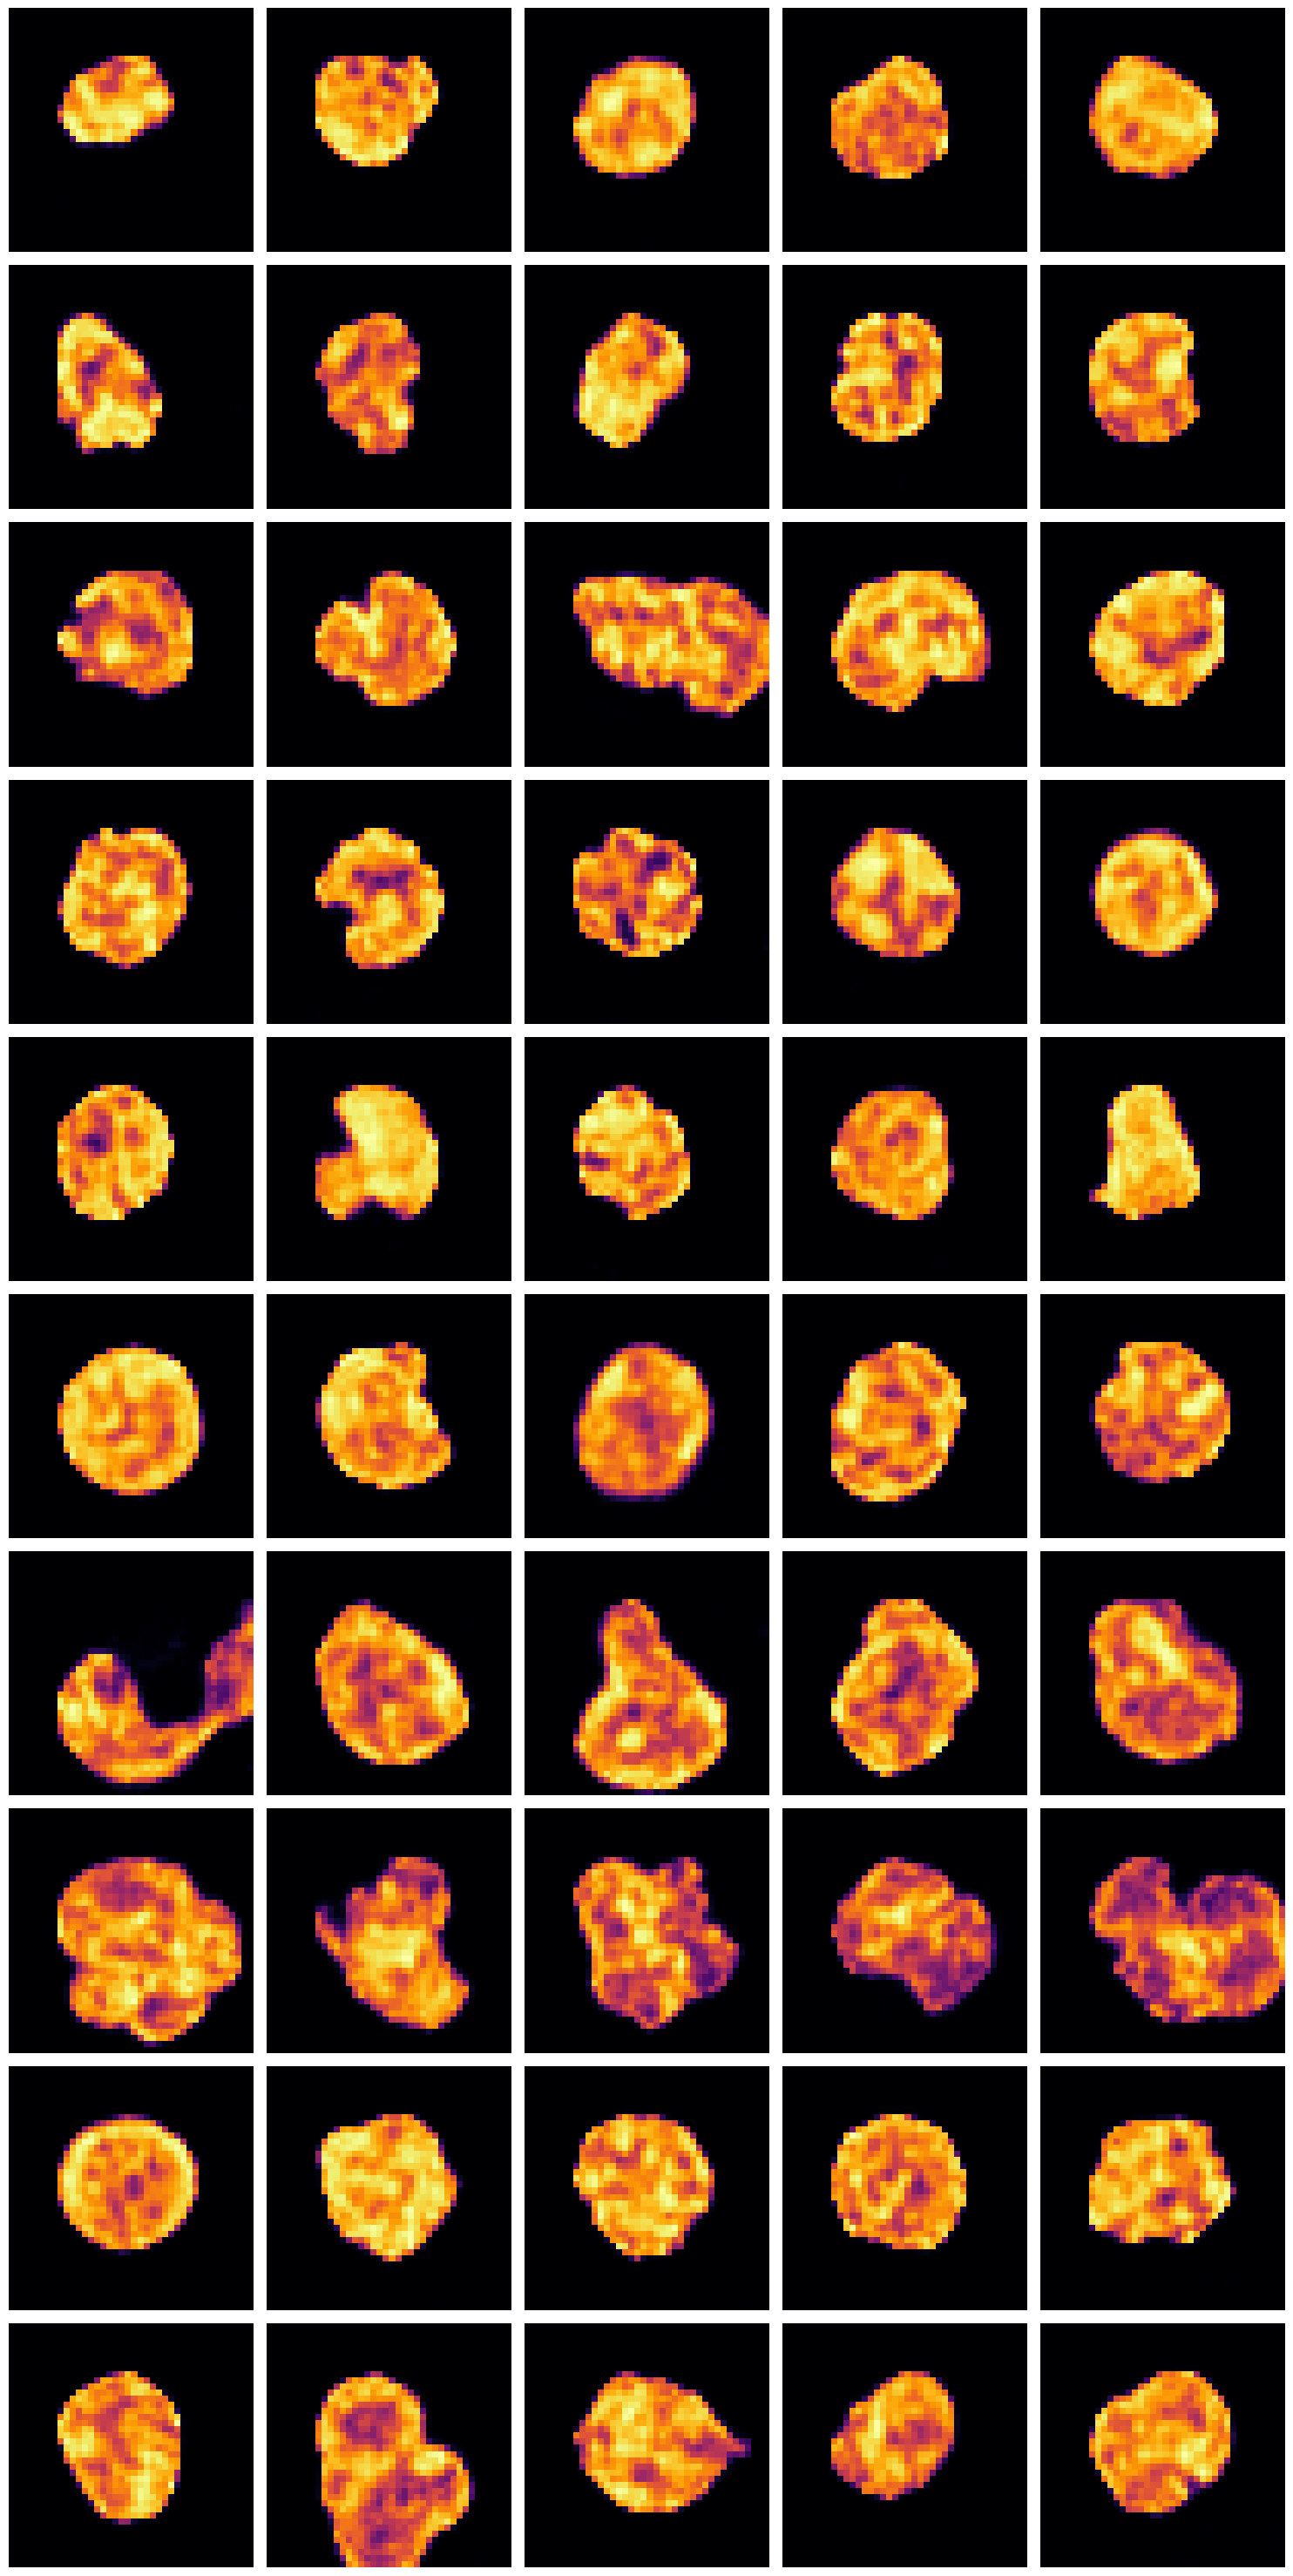

Healthy
C1
C2
C3
C4
C5
C6
C7
C8
C9
uc


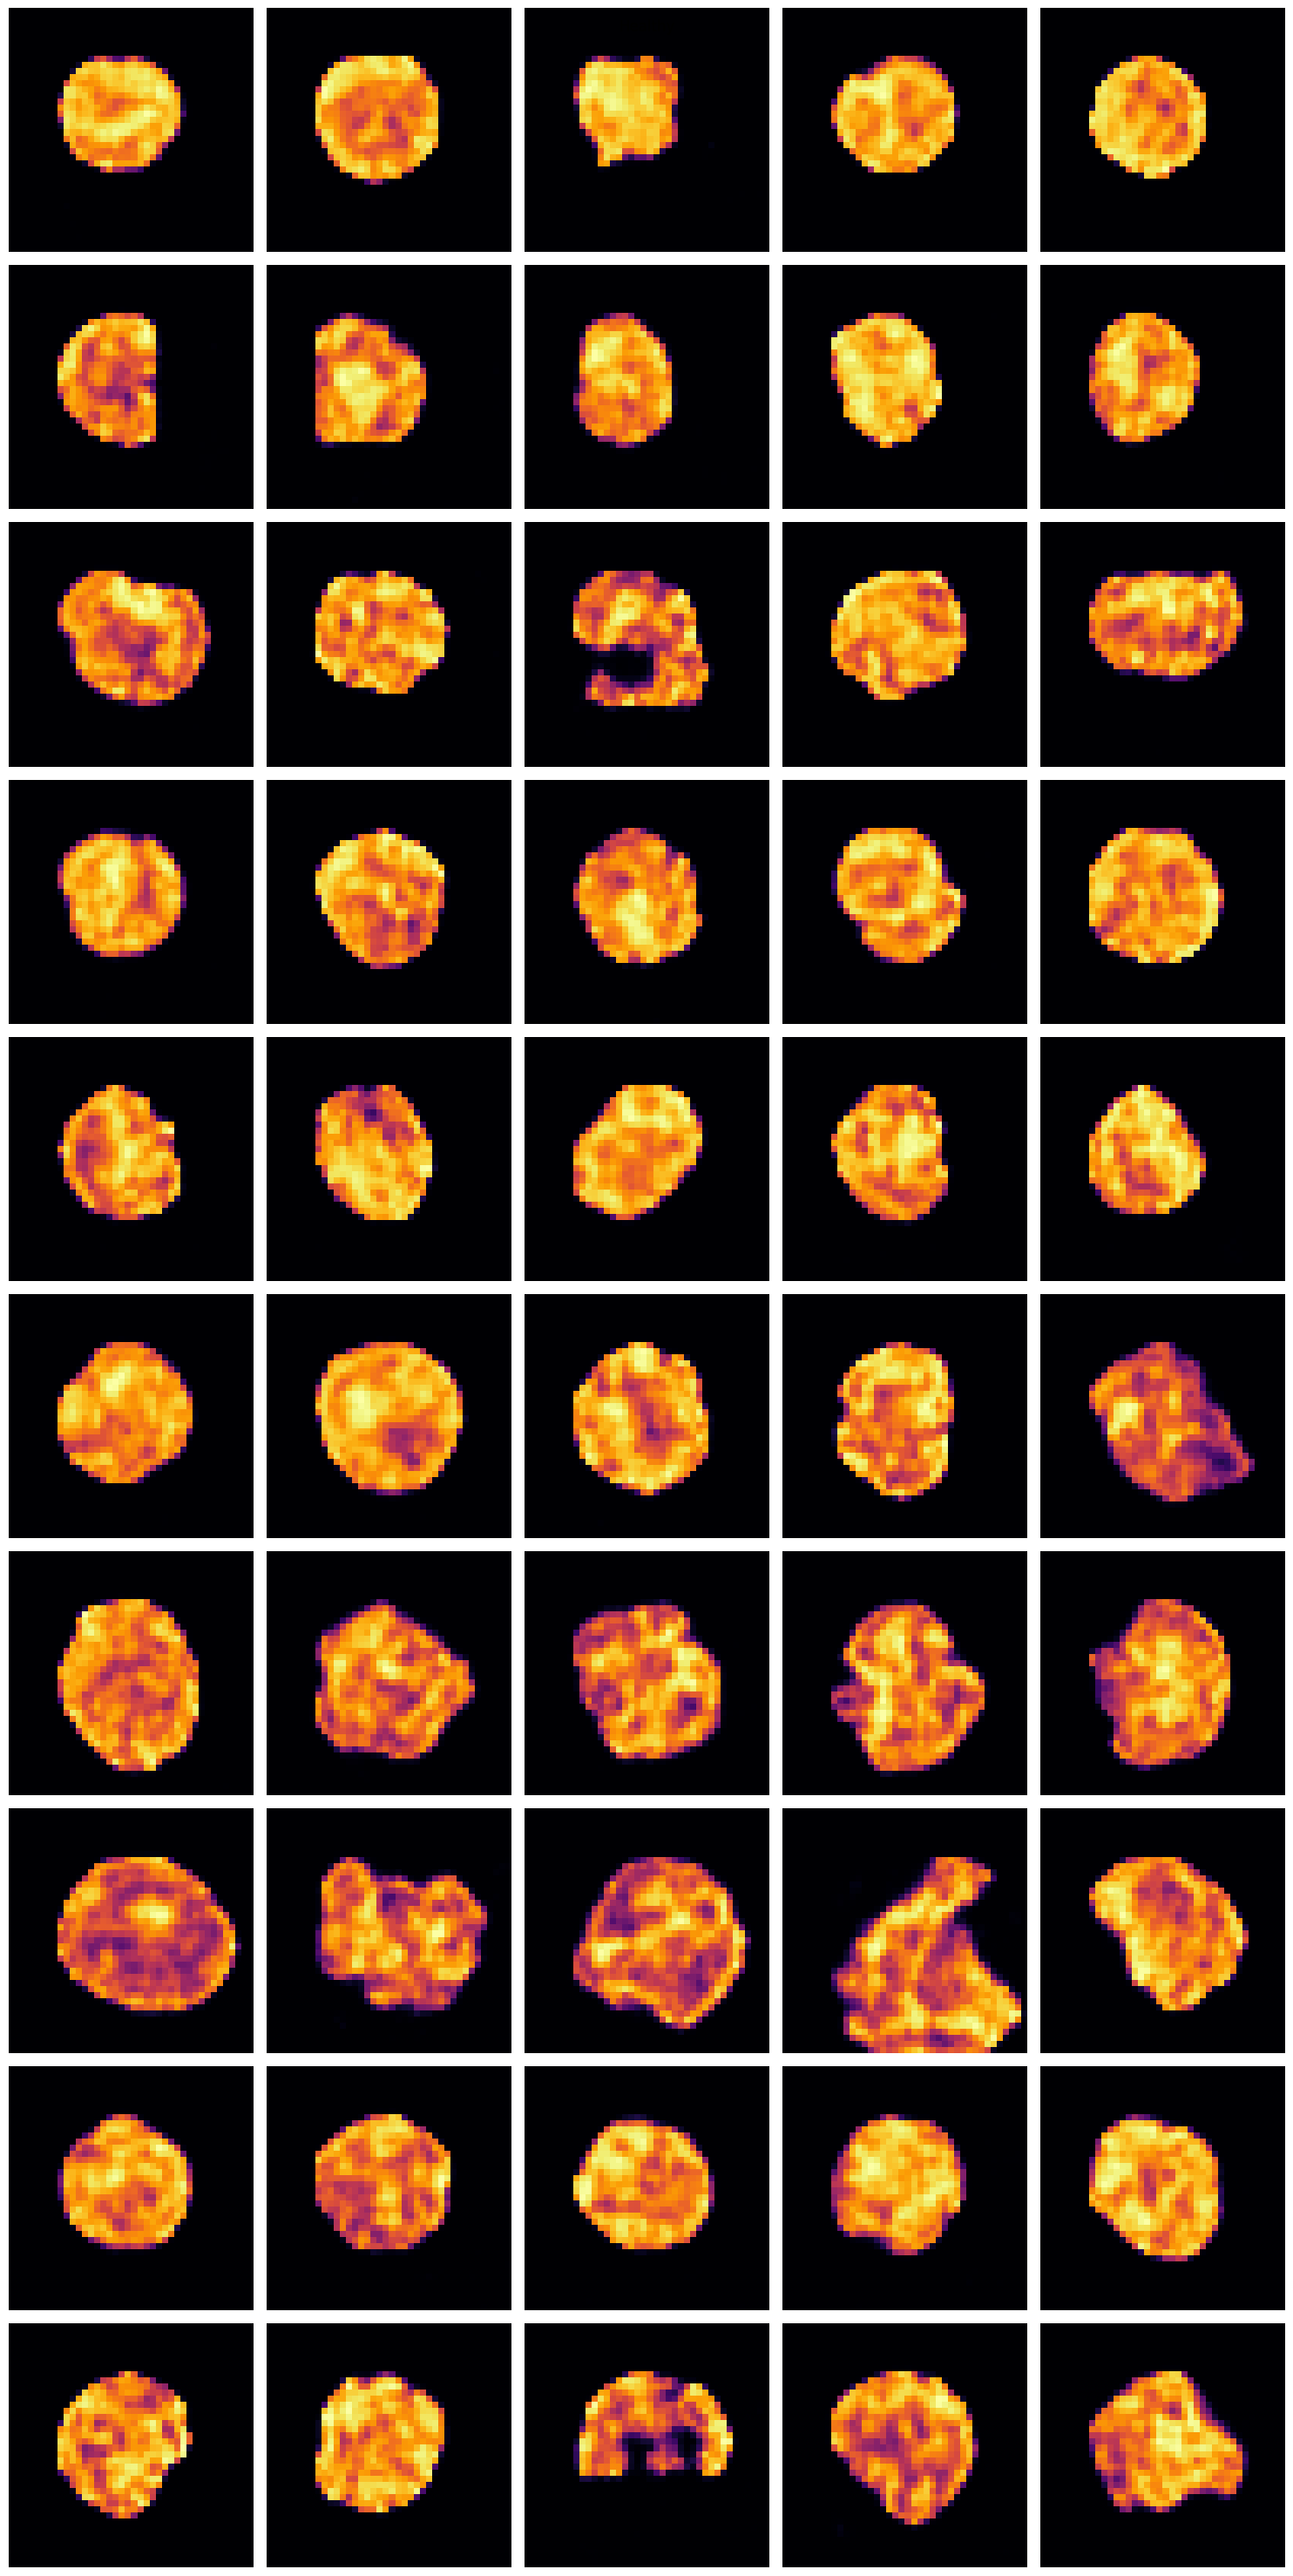

Prediabetic
C1
C2
C3
C4
C5
C6
C7
C8
C9
uc


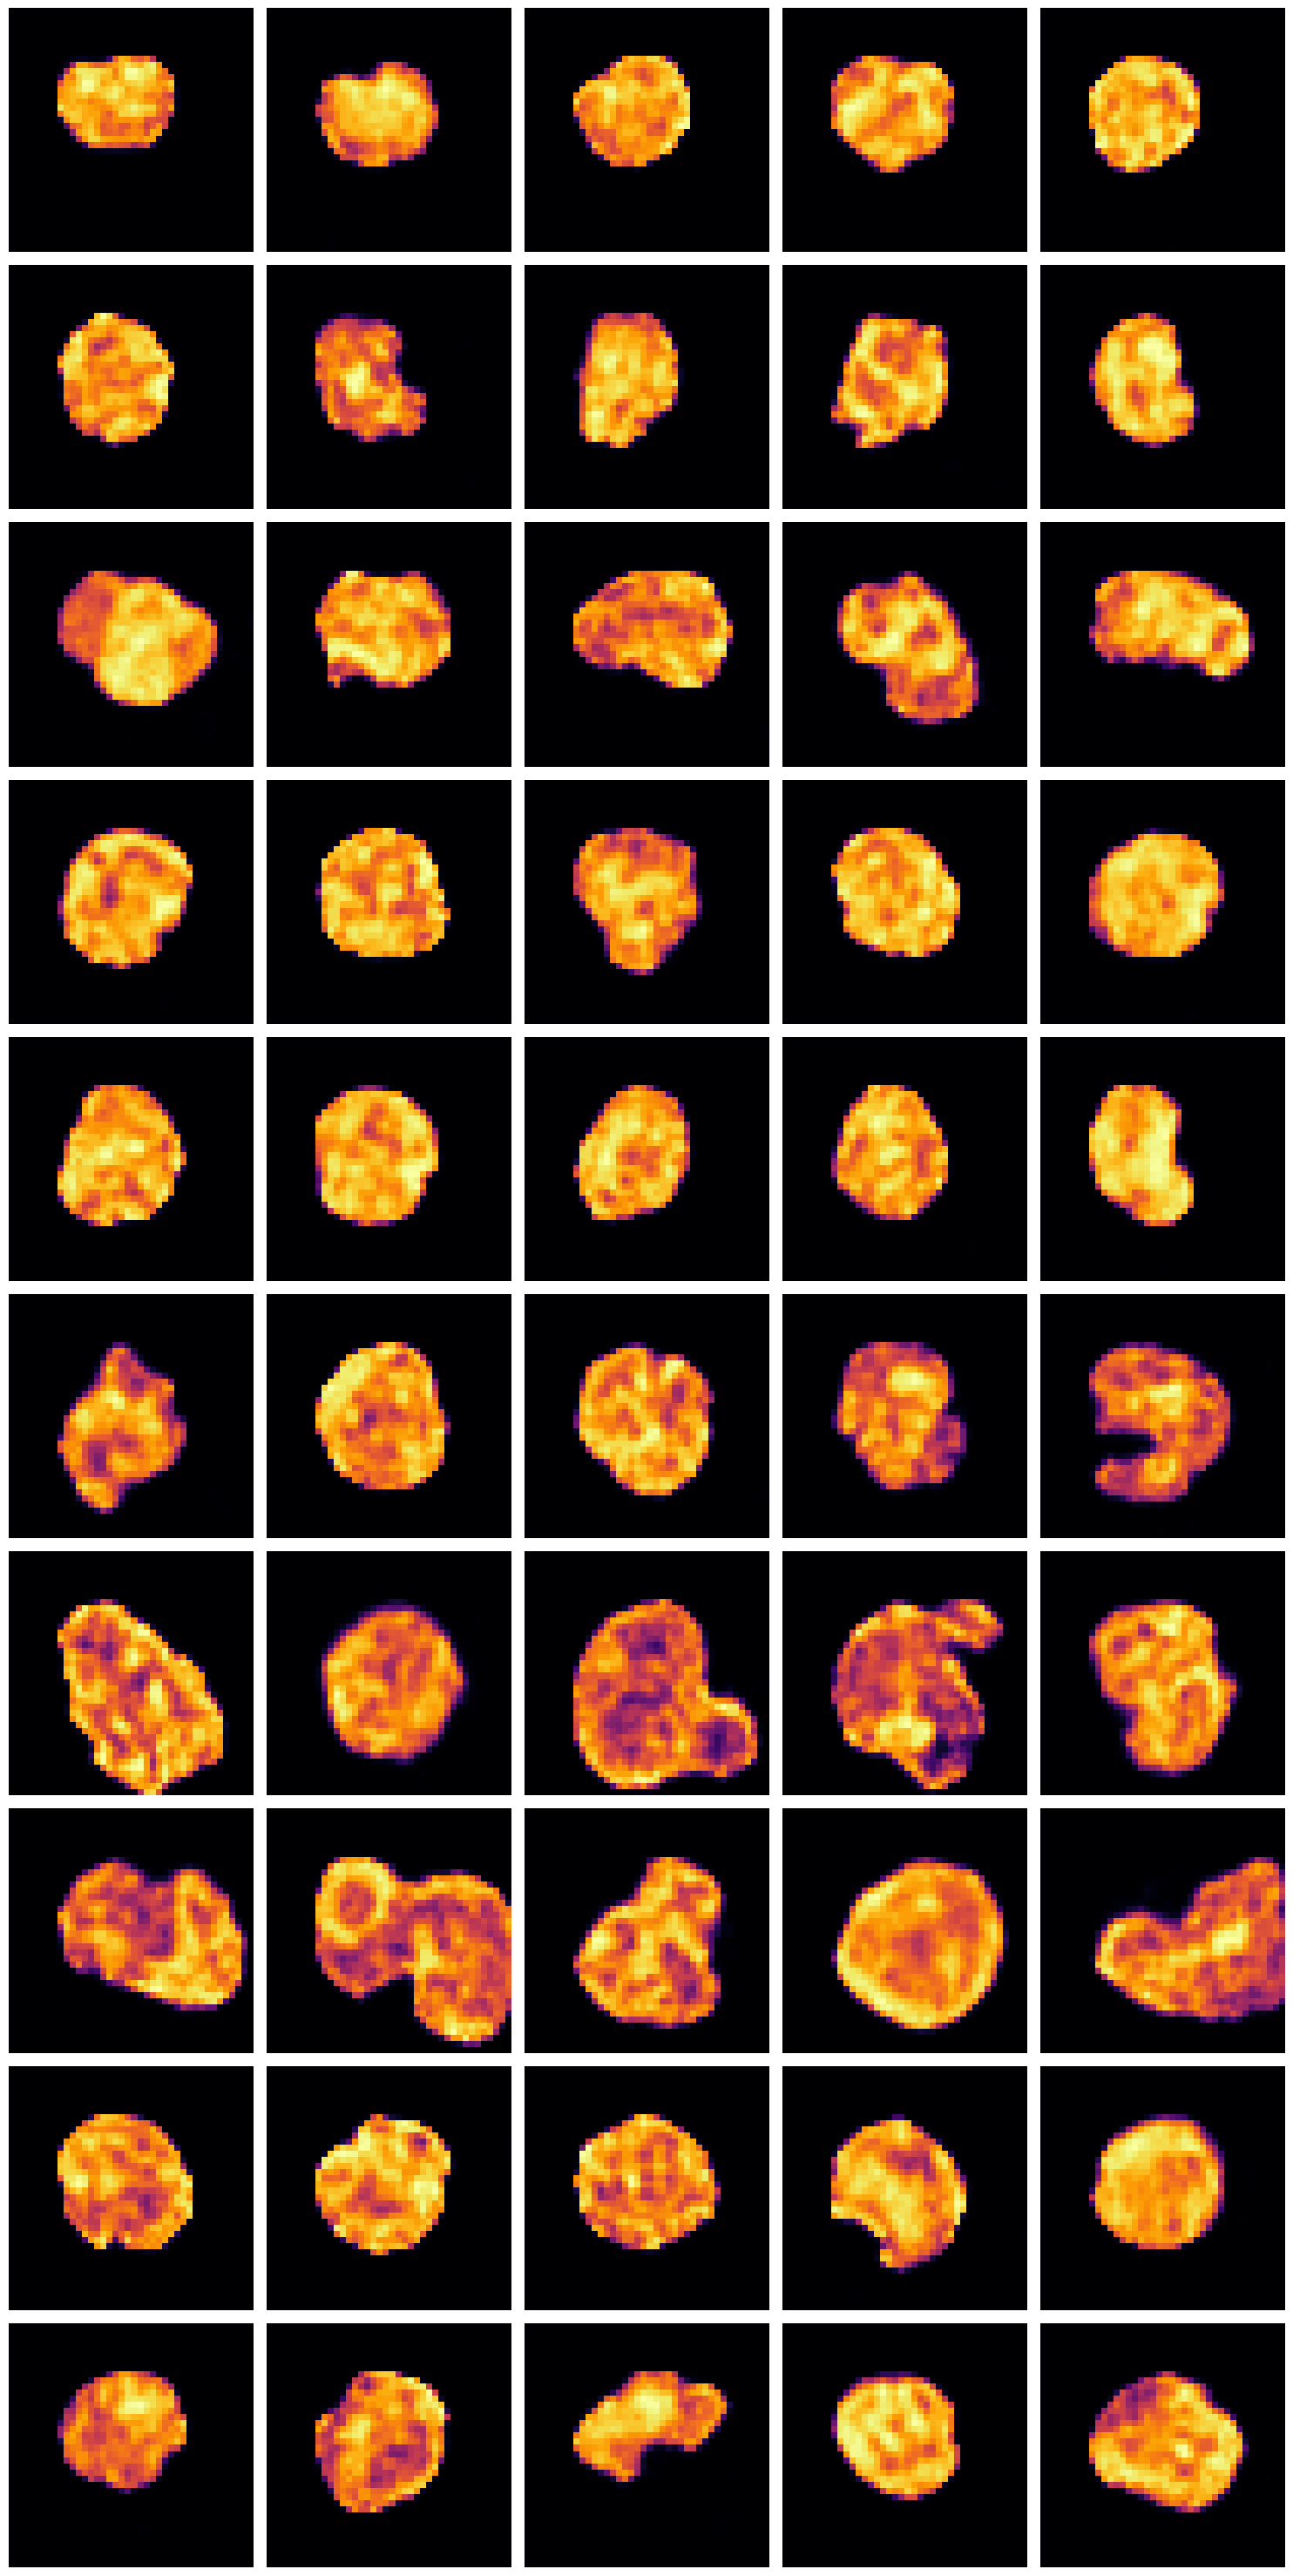

In [344]:
max_cols = 5      # how many images per label row
pad_top = 7
pad_left = 7

for disease, disease_df in sampled.groupby("disease"):
    print(disease)
    label_groups = list(disease_df.groupby("label_leiden"))
    n_rows = len(label_groups)
    fig, axes = plt.subplots(
        n_rows,
        max_cols,
        figsize=(max_cols * 3, n_rows * 3),
        squeeze=False,
    )

    for row, (label, label_df) in enumerate(label_groups):
        print(label)
        idxs = label_df.index.tolist()[:max_cols]
        images = [recon_list[i] for i in idxs]
        padded = [
            np.pad(
                img.squeeze(),
                ((pad_top, 0), (pad_left, 0)),
                mode="constant",
                constant_values=0,
            )
            for img in images
        ]

        for col in range(max_cols):
            ax = axes[row, col]
            if col < len(padded):
                ax.imshow(padded[col][0:40, 0:40], cmap="inferno")
            ax.set_axis_off()

        axes[row, 0].set_ylabel(f"{label}", rotation=0, ha="right", va="center")

    fig.suptitle(f"{disease}")
    plt.tight_layout()
    plt.show()